In [60]:
import os
import pickle

# import the package needed to solve the environnement
from scipy.optimize import linear_sum_assignment #hungarian matching algorithm
import numpy as np
from scipy.stats import beta, bernoulli,norm
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import fsolve
from scipy.optimize import root,root_scalar

from statsmodels.distributions.empirical_distribution import ECDF

# 2 Decisions env

In [6]:
class Two_decision_env():
    """
    Create an environment with 2 decisions composed of d items with reward a and b with a>b>1/2
    
    """ 
    def __init__(self,m,a = 1,b = 0.9,sigma = 1,random_variable = "bernoulli"):
        self.m = m
        self.a = a
        self.b = b
        self.sigma = sigma
        
        self.random_variable = random_variable
                 
    def draw(self, decision):
        """
        Draw a vector of reward
        
        """
        if self.random_variable == "bernoulli":
            if decision == 0:
                reward = bernoulli.rvs(self.a, size = self.m)
            elif decision == 1:
                reward = bernoulli.rvs(self.b, size = self.m)
                
        elif self.random_variable == "gaussian":
            if decision == 0:
                reward = norm.rvs(self.a, scale=self.sigma, size = self.m)
            elif decision == 1:
                reward = norm.rvs(self.b, scale=self.sigma, size = self.m)
            
        if decision == 1:
            regret = (self.a-self.b)*self.m
        elif decision == 0:
            regret = 0
            
        return reward, regret

# ESCB

In [135]:
# def newton(f,df,x0):
#     xn = x0
#     for n in range(100):
#         fxn = f(xn)
#         dfxn = df(xn)
#         if np.abs(fxn) < 10**-3:
#             return(xn)
#         xn = xn - fxn/dfxn
#         print(dfxn)
#     print("Zero not found")
#     return(xn)

# def dicho(f,a,b):
    
#     for n in range(100):
#         fa = f(a)
#         fb = f(b)
#         fxn = f(xn)
#         if np.abs(fxn) < 10**-3:
#             return(xn)
#         fab = 3
#         if fxn < 0:
#             a =5+6
#         if fxn > 0:
#             a = 5+7
#         print(dfxn)
#     print("Zero not found")
#     return(xn)

class ESCB():
    """
    TS for the two decision environnement
    """
    def __init__(self, m,n_init = 0,index = 2):
        
        self.iteration = 0
        self.m = m
    
        self.numplayed = np.zeros(2)
        
        self.mu = np.zeros(2*self.m)
        self.sigma = np.zeros(2*self.m)
        
        self.initialization = False
        
        self.n_init = n_init # sample n_init time each decision
        if self.n_init > 0:   
            self.initialization = True
        
        self.playhist = []
        
        self.index = index
        
         
    def reset(self):
        self.iteration = 0
        self.weight_draw = np.zeros(2*m)
        self.numplayed = np.zeros(2)
        self.playhist = []
        
        if self.n_init > 0:   
            self.initialization = True
        
        
    def play(self):
        """
        This will drow a sample (arm played) using the parameters 

        """
        
        if self.iteration < self.n_init:
            self.decision = 0
            self.playhist.append(self.decision)
            return(self.decision)
        
        if self.iteration < 2*self.n_init:
            self.decision = 1
            self.playhist.append(self.decision)
            return(self.decision)
        else:       
            self.initialization = False
        
        # can be done better, the derivativ can be provided
        if self.index == 1:
            function1, dfunction1 = self.fgenerator(self.mu[:self.m],0)
            index_a = np.sum(newton(function1,dfunction1,np.ones(self.m)*0.5))
            #index_a = np.sum(root_scalar(function1, x0 = np.ones(self.m)*0.5,x1 = np.ones(self.m)).root)

            function1, dfunction1 = self.fgenerator(self.mu[self.m:],0)
            index_b = np.sum(newton(function1,dfunction1,np.ones(self.m)*0.5))
            #index_b = np.sum(root_scalar(function1, x0 = np.ones(self.m)*0.5,x1 = np.ones(self.m)).root)


            
        elif self.index == 2:                 
            index_a = np.sum(self.mu[:self.m])+np.sqrt(m/2*self.f()/self.numplayed[0])
            index_b = np.sum(self.mu[self.m:])+np.sqrt(m/2*self.f()/self.numplayed[1])
            
        if index_a > index_b:
            self.decision = 0
        else :
            self.decision = 1
            
            
        self.playhist.append(self.decision)

        return self.decision
    
    def fgenerator(self,p,number):
        def function1(q):
            return self.kl(p,q)*self.numplayed[number] - self.f()
        def dfunction1(q):
            return (-p/q + (1-p)/(1-q))*self.numplayed[number]
        return function1, dfunction1
    
    def kl(self,p,q):
        return np.sum(p*np.log(p/(q+10**-8))+(1-p)*np.log((1-p+10**-8)/(1-q)))
    
    def f(self):
        return np.log(self.iteration)+4*self.m*np.log(np.log(self.iteration))

    def update(self, observation):
        """
        update the parameter of the arms
        observation are a dictionary of reward
        """
        self.iteration += 1
        self.numplayed[self.decision] += 1
        
        if self.decision == 0:    
            self.mu[:self.m] = (self.mu[:self.m]*(self.numplayed[self.decision]-1)+observation)/self.numplayed[self.decision]
        elif self.decision == 1:
            self.mu[self.m:] = (self.mu[self.m:]*(self.numplayed[self.decision]-1)+observation)/self.numplayed[self.decision]


In [34]:
root(player.fgenerator(np.array([0.5,0.5,0.5,0.5,0.5]),0),np.array([0.5,0.5,0.5,0.5,0.5]))

TypeError: fsolve: there is a mismatch between the input and output shape of the 'func' argument 'index1'.Shape should be (5,) but it is (1,).

In [134]:
player.fgenerator(np.array([0.9,0.9,0.9,0.9,0.9]),0)[0](np.array([0.9999999999999999,0.99999999999,0.999999999999,0.9999999,0.9999999]))

-1.907777890946985

# TS

In [8]:
class CTS_exp():
    """
    TS for the two decision environnement
    """
    def __init__(self, m,n_init = 0, post_distrib = "beta"):
        
        self.iteration = 0
        self.m = m
        
        
        self.weight_draw = np.zeros(2*m)
        self.numplayed = np.zeros(2)
        
        self.initialization = False
        
        self.n_init = n_init # sample n_init time each decision
        if self.n_init > 0:   
            self.initialization = True
        
        
        self.post_distrib = post_distrib
        self.playhist = []
        self.decision = 1
        
        
        if self.post_distrib == "beta":
            self.alpha = np.ones(2*self.m)
            self.beta = np.ones(2*self.m)
        elif self.post_distrib == "gaussian":
            self.mu = np.zeros(2*self.m)
            self.sigma = np.zeros(2*self.m)
        
        

         
    def reset(self):
        self.iteration = 0
        self.weight_draw = np.zeros(2*m)
        self.numplayed = np.zeros(2)
        self.playhist = []
        self.decision = 1
        
        if self.n_init > 0:   
            self.initialization = True
    
        if self.random_variable == "beta":
            self.alpha = np.ones(2*self.m)
            self.beta = np.ones(2*self.m)
        elif self.random_variable == "gaussian":
            self.mu = np.zeros(2*self.m)
            self.sigma = np.zeros(2*self.m)
        
        
    def play(self):
        """
        This will drow a sample (arm played) using the parameters 

        """
        
        if self.iteration < self.n_init:
            self.decision = 0
            self.playhist.append(self.decision)
            return(self.decision)
        
        if self.iteration < 2*self.n_init:
            self.decision = 1
            self.playhist.append(self.decision)
            return(self.decision)
        else:       
            self.initialization = False
        
            
        if self.post_distrib == "beta":
            self.weight_draw = beta.rvs(self.alpha, self.beta)
            
        elif self.post_distrib == "gaussian": 
            self.weight_draw = norm.rvs(self.mu, self.sigma)
                    
        mean_a = np.sum(self.weight_draw[:self.m])
        mean_b = np.sum(self.weight_draw[self.m:])
        if mean_a > mean_b:
            self.decision = 0
        else :
            self.decision = 1
            
            
        self.playhist.append(self.decision)

        return self.decision


    def update(self, observation):
        """
        update the parameter of the arms
        observation are a dictionary of reward
        """
        self.iteration += 1
        self.numplayed[self.decision] += 1
        
        if self.post_distrib == "beta":
            if self.decision == 0:    
                self.alpha[:self.m] += observation
                self.beta[:self.m] += 1-observation
            elif self.decision == 1:
                self.alpha[self.m:] += observation
                self.beta[self.m:] += 1-observation
        if self.post_distrib == "gaussian":
            if self.decision == 0:    
                self.mu[:self.m] = (self.mu[:self.m]*(self.numplayed[self.decision]-1)+observation)/self.numplayed[self.decision]
                self.sigma[:self.m] =  1/np.sqrt(self.numplayed[self.decision])
            elif self.decision == 1:
                self.mu[self.m:] = (self.mu[self.m:]*(self.numplayed[self.decision]-1)+observation)/self.numplayed[self.decision]
                self.sigma[self.m:] =  1/np.sqrt(self.numplayed[self.decision])

# TS First Optimal play 

## Cold Start

m =  160
begin_trial 0
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 2200

Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still n

Have still not played the optimal arm at time 332000
Have still not played the optimal arm at time 334000
Have still not played the optimal arm at time 336000
Have still not played the optimal arm at time 338000
Have still not played the optimal arm at time 340000
Have still not played the optimal arm at time 342000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still

Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 196000
Have still not played the optimal arm at time 198000
Have still not played the optimal arm at time 200000
Have still not played the optimal arm at time 202000
Have still not played the optimal arm at time 204000
Have still not played the optimal arm at time 206000
Have still not played the optimal arm at time 208000
Have still not played the optimal arm at time 210000
Have still not played the optimal arm at time 212000
Have still not played the optimal arm at time 214000
Have still not played the optimal arm at time 216000
Have still not played the optimal arm at time 218000
Have still not played the optimal arm at time 220000
Have still not played the optimal arm at time 222000
Have still not played the optimal arm at time 224000
Have still not played the optimal arm at time 226000
Have still not played the optimal arm at time 228000
Have still not played the optimal arm at time 230000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still n

Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not

Have still not played the optimal arm at time 280000
Have still not played the optimal arm at time 282000
Have still not played the optimal arm at time 284000
Have still not played the optimal arm at time 286000
Have still not played the optimal arm at time 288000
Have still not played the optimal arm at time 290000
Have still not played the optimal arm at time 292000
Have still not played the optimal arm at time 294000
Have still not played the optimal arm at time 296000
Have still not played the optimal arm at time 298000
Have still not played the optimal arm at time 300000
Have still not played the optimal arm at time 302000
Have still not played the optimal arm at time 304000
Have still not played the optimal arm at time 306000
Have still not played the optimal arm at time 308000
Have still not played the optimal arm at time 310000
Have still not played the optimal arm at time 312000
Have still not played the optimal arm at time 314000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 222000
Have still not played the optimal arm at time 224000
Have still not played the optimal arm at time 226000
Have still not played the optimal arm at time 228000
Have still not played the optimal arm at time 230000
Have still not played the optimal arm at time 232000
Have still not played the optimal arm at time 234000
Have still not played the optimal arm at time 236000
Have still not played the optimal arm at time 238000
Have still not played the optimal arm at time 240000
Have still not played the optimal arm at time 242000
Have still not played the optimal arm at time 244000
Have still not played the optimal arm at time 246000
Have still not played the optimal arm at time 248000
Have still not played the optimal arm at time 250000
Have still not played the optimal arm at time 252000
Have still not played the optimal arm at time 254000
Have still not played the optimal arm at time 256000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 532000
Have still not played the optimal arm at time 534000
Have still not played the optimal arm at time 536000
Have still not played the optimal arm at time 538000
Have still not played the optimal arm at time 540000
Have still not played the optimal arm at time 542000
Have still not played the optimal arm at time 544000
Have still not played the optimal arm at time 546000
Have still not played the optimal arm at time 548000
Have still not played the optimal arm at time 550000
Have still not played the optimal arm at time 552000
Have still not played the optimal arm at time 554000
Have still not played the optimal arm at time 556000
Have still not played the optimal arm at time 558000
Have still not played the optimal arm at time 560000
Have still not played the optimal arm at time 562000
Have still not played the optimal arm at time 564000
Have still not played the optimal arm at time 566000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have 

Have still not played the optimal arm at time 386000
Have still not played the optimal arm at time 388000
Have still not played the optimal arm at time 390000
Have still not played the optimal arm at time 392000
Have still not played the optimal arm at time 394000
Have still not played the optimal arm at time 396000
Have still not played the optimal arm at time 398000
Have still not played the optimal arm at time 400000
Have still not played the optimal arm at time 402000
Have still not played the optimal arm at time 404000
Have still not played the optimal arm at time 406000
Have still not played the optimal arm at time 408000
Have still not played the optimal arm at time 410000
Have still not played the optimal arm at time 412000
Have still not played the optimal arm at time 414000
Have still not played the optimal arm at time 416000
Have still not played the optimal arm at time 418000
Have still not played the optimal arm at time 420000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have st

Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still n

Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still n

Have still not played the optimal arm at time 178000
Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 182000
Have still not played the optimal arm at time 184000
Have still not played the optimal arm at time 186000
Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 196000
Have still not played the optimal arm at time 198000
Have still not played the optimal arm at time 200000
Have still not played the optimal arm at time 202000
Have still not played the optimal arm at time 204000
Have still not played the optimal arm at time 206000
Have still not played the optimal arm at time 208000
Have still not played the optimal arm at time 210000
Have still not played the optimal arm at time 212000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 260000
Have still not played the optimal arm at time 262000
Have still not played the optimal arm at time 264000
Have still not played the optimal arm at time 266000
Have still not played the optimal arm at time 268000
Have still not played the optimal arm at time 270000
Have still not played the optimal arm at time 272000
Have still not played the optimal arm at time 274000
Have still not played the optimal arm at time 276000
Have still not played the optimal arm at time 278000
Have still not played the optimal arm at time 280000
Have still not played the optimal arm at time 282000
Have still not played the optimal arm at time 284000
Have still not played the optimal arm at time 286000
Have still not played the optimal arm at time 288000
Have still not played the optimal arm at time 290000
Have still not played the optimal arm at time 292000
Have still not played the optimal arm at time 294000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 170000
Have still not played the optimal arm at time 172000
Have still not played the optimal arm at time 174000
Have still not played the optimal arm at time 176000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 452000
Have still not played the optimal arm at time 454000
Have still not played the optimal arm at time 456000
Have still not played the optimal arm at time 458000
Have still not played the optimal arm at time 460000
Have still not played the optimal arm at time 462000
Have still not played the optimal arm at time 464000
Have still not played the optimal arm at time 466000
Have still not played the optimal arm at time 468000
Have still not played the optimal arm at time 470000
Have still not played the optimal arm at time 472000
Have still not played the optimal arm at time 474000
Have still not played the optimal arm at time 476000
Have still not played the optimal arm at time 478000
Have still not played the optimal arm at time 480000
Have still not played the optimal arm at time 482000
Have still not played the optimal arm at time 484000
Have still not played the optimal arm at time 486000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still n

Have still not played the optimal arm at time 364000
Have still not played the optimal arm at time 366000
Have still not played the optimal arm at time 368000
Have still not played the optimal arm at time 370000
Have still not played the optimal arm at time 372000
Have still not played the optimal arm at time 374000
Have still not played the optimal arm at time 376000
Have still not played the optimal arm at time 378000
Have still not played the optimal arm at time 380000
Have still not played the optimal arm at time 382000
Have still not played the optimal arm at time 384000
Have still not played the optimal arm at time 386000
Have still not played the optimal arm at time 388000
Have still not played the optimal arm at time 390000
Have still not played the optimal arm at time 392000
Have still not played the optimal arm at time 394000
Have still not played the optimal arm at time 396000
Have still not played the optimal arm at time 398000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 674000
Have still not played the optimal arm at time 676000
Have still not played the optimal arm at time 678000
Have still not played the optimal arm at time 680000
Have still not played the optimal arm at time 682000
Have still not played the optimal arm at time 684000
Have still not played the optimal arm at time 686000
Have still not played the optimal arm at time 688000
Have still not played the optimal arm at time 690000
Have still not played the optimal arm at time 692000
Have still not played the optimal arm at time 694000
Have still not played the optimal arm at time 696000
Have still not played the optimal arm at time 698000
Have still not played the optimal arm at time 700000
Have still not played the optimal arm at time 702000
Have still not played the optimal arm at time 704000
Have still not played the optimal arm at time 706000
Have still not played the optimal arm at time 708000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still n

Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 182000
Have still not played the optimal arm at time 184000
Have still not played the optimal arm at time 186000
Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 196000
Have still not played the optimal arm at time 198000
Have still not played the optimal arm at time 200000
Have still not played the optimal arm at time 202000
Have still not played the optimal arm at time 204000
Have still not played the optimal arm at time 206000
Have still not played the optimal arm at time 208000
Have still not played the optimal arm at time 210000
Have still not played the optimal arm at time 212000
Have still not played the optimal arm at time 214000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still n

Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000

Have still not played the optimal arm at time 222000
Have still not played the optimal arm at time 224000
Have still not played the optimal arm at time 226000
Have still not played the optimal arm at time 228000
Have still not played the optimal arm at time 230000
Have still not played the optimal arm at time 232000
Have still not played the optimal arm at time 234000
Have still not played the optimal arm at time 236000
Have still not played the optimal arm at time 238000
Have still not played the optimal arm at time 240000
Have still not played the optimal arm at time 242000
Have still not played the optimal arm at time 244000
Have still not played the optimal arm at time 246000
Have still not played the optimal arm at time 248000
Have still not played the optimal arm at time 250000
Have still not played the optimal arm at time 252000
Have still not played the optimal arm at time 254000
Have still not played the optimal arm at time 256000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 532000
Have still not played the optimal arm at time 534000
Have still not played the optimal arm at time 536000
Have still not played the optimal arm at time 538000
Have still not played the optimal arm at time 540000
Have still not played the optimal arm at time 542000
Have still not played the optimal arm at time 544000
Have still not played the optimal arm at time 546000
Have still not played the optimal arm at time 548000
Have still not played the optimal arm at time 550000
Have still not played the optimal arm at time 552000
Have still not played the optimal arm at time 554000
Have still not played the optimal arm at time 556000
Have still not played the optimal arm at time 558000
Have still not played the optimal arm at time 560000
Have still not played the optimal arm at time 562000
Have still not played the optimal arm at time 564000
Have still not played the optimal arm at time 566000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still

Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 2000
Have

Have still not played the optimal arm at time 186000
Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 196000
Have still not played the optimal arm at time 198000
Have still not played the optimal arm at time 200000
Have still not played the optimal arm at time 202000
Have still not played the optimal arm at time 204000
Have still not played the optimal arm at time 206000
Have still not played the optimal arm at time 208000
Have still not played the optimal arm at time 210000
Have still not played the optimal arm at time 212000
Have still not played the optimal arm at time 214000
Have still not played the optimal arm at time 216000
Have still not played the optimal arm at time 218000
Have still not played the optimal arm at time 220000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 496000
Have still not played the optimal arm at time 498000
Have still not played the optimal arm at time 500000
Have still not played the optimal arm at time 502000
Have still not played the optimal arm at time 504000
Have still not played the optimal arm at time 506000
Have still not played the optimal arm at time 508000
Have still not played the optimal arm at time 510000
Have still not played the optimal arm at time 512000
Have still not played the optimal arm at time 514000
Have still not played the optimal arm at time 516000
Have still not played the optimal arm at time 518000
Have still not played the optimal arm at time 520000
Have still not played the optimal arm at time 522000
Have still not played the optimal arm at time 524000
Have still not played the optimal arm at time 526000
Have still not played the optimal arm at time 528000
Have still not played the optimal arm at time 530000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still n

Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 440000
Have still not played the optimal arm at time 442000
Have still not played the optimal arm at time 444000
Have still not played the optimal arm at time 446000
Have still not played the optimal arm at time 448000
Have still not played the optimal arm at time 450000
Have still not played the optimal arm at time 452000
Have still not played the optimal arm at time 454000
Have still not played the optimal arm at time 456000
Have still not played the optimal arm at time 458000
Have still not played the optimal arm at time 460000
Have still not played the optimal arm at time 462000
Have still not played the optimal arm at time 464000
Have still not played the optimal arm at time 466000
Have still not played the optimal arm at time 468000
Have still not played the optimal arm at time 470000
Have still not played the optimal arm at time 472000
Have still not played the optimal arm at time 474000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have stil

Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have 

Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 170000
Have still not played the optimal arm at time 172000
Have still not played the optimal arm at time 174000
Have still not played the optimal arm at time 176000
Have still not played the optimal arm at time 178000
Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 182000
Have still not played the optimal arm at time 184000
Have still not played the optimal arm at time 186000
Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 196000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still n

Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still n

Have still not played the optimal arm at time 366000
Have still not played the optimal arm at time 368000
Have still not played the optimal arm at time 370000
Have still not played the optimal arm at time 372000
Have still not played the optimal arm at time 374000
Have still not played the optimal arm at time 376000
Have still not played the optimal arm at time 378000
Have still not played the optimal arm at time 380000
Have still not played the optimal arm at time 382000
Have still not played the optimal arm at time 384000
Have still not played the optimal arm at time 386000
Have still not played the optimal arm at time 388000
Have still not played the optimal arm at time 390000
Have still not played the optimal arm at time 392000
Have still not played the optimal arm at time 394000
Have still not played the optimal arm at time 396000
Have still not played the optimal arm at time 398000
Have still not played the optimal arm at time 400000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still n

Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still n

Have still not played the optimal arm at time 372000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not 

Have still not played the optimal arm at time 226000
Have still not played the optimal arm at time 228000
Have still not played the optimal arm at time 230000
Have still not played the optimal arm at time 232000
Have still not played the optimal arm at time 234000
Have still not played the optimal arm at time 236000
Have still not played the optimal arm at time 238000
Have still not played the optimal arm at time 240000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have sti

Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still n

Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
begin_trial 200
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have

Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 170000
Have still not played the optimal arm at time 172000
Have still not played the optimal arm at time 174000
Have still not played the optimal arm at time 176000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 228000
Have still not played the optimal arm at time 230000
Have still not played the optimal arm at time 232000
Have still not played the optimal arm at time 234000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still n

Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still n

Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 1280

Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still no

Have still not played the optimal arm at time 320000
Have still not played the optimal arm at time 322000
Have still not played the optimal arm at time 324000
Have still not played the optimal arm at time 326000
Have still not played the optimal arm at time 328000
Have still not played the optimal arm at time 330000
Have still not played the optimal arm at time 332000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have stil

Have still not played the optimal arm at time 218000
Have still not played the optimal arm at time 220000
Have still not played the optimal arm at time 222000
Have still not played the optimal arm at time 224000
Have still not played the optimal arm at time 226000
Have still not played the optimal arm at time 228000
Have still not played the optimal arm at time 230000
Have still not played the optimal arm at time 232000
Have still not played the optimal arm at time 234000
Have still not played the optimal arm at time 236000
Have still not played the optimal arm at time 238000
Have still not played the optimal arm at time 240000
Have still not played the optimal arm at time 242000
Have still not played the optimal arm at time 244000
Have still not played the optimal arm at time 246000
Have still not played the optimal arm at time 248000
Have still not played the optimal arm at time 250000
Have still not played the optimal arm at time 252000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not p

Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not p

Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still

Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not p

Have still not played the optimal arm at time 234000
Have still not played the optimal arm at time 236000
Have still not played the optimal arm at time 238000
Have still not played the optimal arm at time 240000
Have still not played the optimal arm at time 242000
Have still not played the optimal arm at time 244000
Have still not played the optimal arm at time 246000
Have still not played the optimal arm at time 248000
Have still not played the optimal arm at time 250000
Have still not played the optimal arm at time 252000
Have still not played the optimal arm at time 254000
Have still not played the optimal arm at time 256000
Have still not played the optimal arm at time 258000
Have still not played the optimal arm at time 260000
Have still not played the optimal arm at time 262000
Have still not played the optimal arm at time 264000
Have still not played the optimal arm at time 266000
Have still not played the optimal arm at time 268000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not

Have still not played the optimal arm at time 186000
Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 196000
Have still not played the optimal arm at time 198000
Have still not played the optimal arm at time 200000
Have still not played the optimal arm at time 202000
Have still not played the optimal arm at time 204000
Have still not played the optimal arm at time 206000
Have still not played the optimal arm at time 208000
Have still not played the optimal arm at time 210000
Have still not played the optimal arm at time 212000
Have still not played the optimal arm at time 214000
Have still not played the optimal arm at time 216000
Have still not played the optimal arm at time 218000
Have still not played the optimal arm at time 220000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 496000
Have still not played the optimal arm at time 498000
Have still not played the optimal arm at time 500000
Have still not played the optimal arm at time 502000
Have still not played the optimal arm at time 504000
Have still not played the optimal arm at time 506000
Have still not played the optimal arm at time 508000
Have still not played the optimal arm at time 510000
Have still not played the optimal arm at time 512000
Have still not played the optimal arm at time 514000
Have still not played the optimal arm at time 516000
Have still not played the optimal arm at time 518000
Have still not played the optimal arm at time 520000
Have still not played the optimal arm at time 522000
Have still not played the optimal arm at time 524000
Have still not played the optimal arm at time 526000
Have still not played the optimal arm at time 528000
Have still not played the optimal arm at time 530000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not p

Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not p

Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 170000
Have still not played the optimal arm at time 172000
Have still not played the optimal arm at time 174000
Have still not played the optimal arm at time 176000
begin_trial 300
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at ti

Have still not played the optimal arm at time 296000
Have still not played the optimal arm at time 298000
Have still not played the optimal arm at time 300000
Have still not played the optimal arm at time 302000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still n

Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 170000
Have still not played the optimal arm at time 172000
Have still not played the optimal arm at time 174000
Have still not played the optimal arm at time 176000
Have still not played the optimal arm at time 178000
Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 182000
Have still not played the optimal arm at time 184000
Have still not played the optimal arm at time 186000
Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 196000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have 

Have still not played the optimal arm at time 270000
Have still not played the optimal arm at time 272000
Have still not played the optimal arm at time 274000
Have still not played the optimal arm at time 276000
Have still not played the optimal arm at time 278000
Have still not played the optimal arm at time 280000
Have still not played the optimal arm at time 282000
Have still not played the optimal arm at time 284000
Have still not played the optimal arm at time 286000
Have still not played the optimal arm at time 288000
Have still not played the optimal arm at time 290000
Have still not played the optimal arm at time 292000
Have still not played the optimal arm at time 294000
Have still not played the optimal arm at time 296000
Have still not played the optimal arm at time 298000
Have still not played the optimal arm at time 300000
Have still not played the optimal arm at time 302000
Have still not played the optimal arm at time 304000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 580000
Have still not played the optimal arm at time 582000
Have still not played the optimal arm at time 584000
Have still not played the optimal arm at time 586000
Have still not played the optimal arm at time 588000
Have still not played the optimal arm at time 590000
Have still not played the optimal arm at time 592000
Have still not played the optimal arm at time 594000
Have still not played the optimal arm at time 596000
Have still not played the optimal arm at time 598000
Have still not played the optimal arm at time 600000
Have still not played the optimal arm at time 602000
Have still not played the optimal arm at time 604000
Have still not played the optimal arm at time 606000
Have still not played the optimal arm at time 608000
Have still not played the optimal arm at time 610000
Have still not played the optimal arm at time 612000
Have still not played the optimal arm at time 614000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not playe

Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still n

Have still not played the optimal arm at time 372000
Have still not played the optimal arm at time 374000
Have still not played the optimal arm at time 376000
Have still not played the optimal arm at time 378000
Have still not played the optimal arm at time 380000
Have still not played the optimal arm at time 382000
Have still not played the optimal arm at time 384000
Have still not played the optimal arm at time 386000
Have still not played the optimal arm at time 388000
Have still not played the optimal arm at time 390000
Have still not played the optimal arm at time 392000
Have still not played the optimal arm at time 394000
Have still not played the optimal arm at time 396000
Have still not played the optimal arm at time 398000
Have still not played the optimal arm at time 400000
Have still not played the optimal arm at time 402000
Have still not played the optimal arm at time 404000
Have still not played the optimal arm at time 406000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000


Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 170000
Have still not played the optimal arm at time 172000
Have still not played the optimal arm at time 174000
Have still not played the optimal arm at time 176000
Have still not played the optimal arm at time 178000
Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 196000
Have still not played the optimal arm at time 198000
Have still not played the optimal arm at time 200000
Have still not played the optimal arm at time 202000
Have still not played the optimal arm at time 204000
Have still not played the optimal arm at time 206000
Have still not played the optimal arm at time 208000
Have still not played the optimal arm at time 210000
Have still not played the optimal arm at time 212000
Have still not played the optimal arm at time 214000
Have still not played the optimal arm at time 216000
Have still not played the optimal arm at time 218000
Have still not played the optimal arm at time 220000
Have still not played the optimal arm at time 222000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 266000
Have still not played the optimal arm at time 268000
Have still not played the optimal arm at time 270000
Have still not played the optimal arm at time 272000
Have still not played the optimal arm at time 274000
Have still not played the optimal arm at time 276000
Have still not played the optimal arm at time 278000
Have still not played the optimal arm at time 280000
Have still not played the optimal arm at time 282000
Have still not played the optimal arm at time 284000
Have still not played the optimal arm at time 286000
Have still not played the optimal arm at time 288000
Have still not played the optimal arm at time 290000
Have still not played the optimal arm at time 292000
Have still not played the optimal arm at time 294000
Have still not played the optimal arm at time 296000
Have still not played the optimal arm at time 298000
Have still not played the optimal arm at time 300000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Hav

Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still

Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have stil

Have still not played the optimal arm at time 378000
Have still not played the optimal arm at time 380000
Have still not played the optimal arm at time 382000
Have still not played the optimal arm at time 384000
Have still not played the optimal arm at time 386000
Have still not played the optimal arm at time 388000
Have still not played the optimal arm at time 390000
Have still not played the optimal arm at time 392000
Have still not played the optimal arm at time 394000
Have still not played the optimal arm at time 396000
Have still not played the optimal arm at time 398000
Have still not played the optimal arm at time 400000
Have still not played the optimal arm at time 402000
Have still not played the optimal arm at time 404000
Have still not played the optimal arm at time 406000
Have still not played the optimal arm at time 408000
Have still not played the optimal arm at time 410000
Have still not played the optimal arm at time 412000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still n

Have still not played the optimal arm at time 324000
Have still not played the optimal arm at time 326000
Have still not played the optimal arm at time 328000
Have still not played the optimal arm at time 330000
Have still not played the optimal arm at time 332000
Have still not played the optimal arm at time 334000
Have still not played the optimal arm at time 336000
Have still not played the optimal arm at time 338000
Have still not played the optimal arm at time 340000
Have still not played the optimal arm at time 342000
Have still not played the optimal arm at time 344000
Have still not played the optimal arm at time 346000
Have still not played the optimal arm at time 348000
Have still not played the optimal arm at time 350000
Have still not played the optimal arm at time 352000
Have still not played the optimal arm at time 354000
Have still not played the optimal arm at time 356000
Have still not played the optimal arm at time 358000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have sti

Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still n

Have still not played the optimal arm at time 226000
Have still not played the optimal arm at time 228000
Have still not played the optimal arm at time 230000
Have still not played the optimal arm at time 232000
Have still not played the optimal arm at time 234000
Have still not played the optimal arm at time 236000
Have still not played the optimal arm at time 238000
Have still not played the optimal arm at time 240000
Have still not played the optimal arm at time 242000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have st

Have still not played the optimal arm at time 184000
Have still not played the optimal arm at time 186000
Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 196000
Have still not played the optimal arm at time 198000
Have still not played the optimal arm at time 200000
Have still not played the optimal arm at time 202000
Have still not played the optimal arm at time 204000
Have still not played the optimal arm at time 206000
Have still not played the optimal arm at time 208000
Have still not played the optimal arm at time 210000
Have still not played the optimal arm at time 212000
Have still not played the optimal arm at time 214000
Have still not played the optimal arm at time 216000
Have still not played the optimal arm at time 218000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 260000
Have still not played the optimal arm at time 262000
Have still not played the optimal arm at time 264000
Have still not played the optimal arm at time 266000
Have still not played the optimal arm at time 268000
Have still not played the optimal arm at time 270000
Have still not played the optimal arm at time 272000
Have still not played the optimal arm at time 274000
Have still not played the optimal arm at time 276000
Have still not played the optimal arm at time 278000
Have still not played the optimal arm at time 280000
Have still not played the optimal arm at time 282000
Have still not played the optimal arm at time 284000
Have still not played the optimal arm at time 286000
Have still not played the optimal arm at time 288000
Have still not played the optimal arm at time 290000
Have still not played the optimal arm at time 292000
Have still not played the optimal arm at time 294000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 1

Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 170000
Have still not played the optimal arm at time 172000
Have still not played the optimal arm at time 174000
Have still not played the optimal arm at time 176000
Have still not played the optimal arm at time 178000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 170000
Have still not played the optimal arm at time 172000
Have still not played the optimal arm at time 174000
Have still not played the optimal arm at time 176000
Have still not played the optimal arm at time 178000
Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 182000
Have still not played the optimal arm at time 184000
Have still not played the optimal arm at time 186000
Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 464000
Have still not played the optimal arm at time 466000
Have still not played the optimal arm at time 468000
Have still not played the optimal arm at time 470000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still n

Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have st

Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 170000
Have still not played the optimal arm at time 172000
Have still not played the optimal arm at time 174000
Have still not played the optimal arm at time 176000
Have still not played the optimal arm at time 178000
Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 182000
Have still not played the optimal arm at time 184000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 460000
Have still not played the optimal arm at time 462000
Have still not played the optimal arm at time 464000
Have still not played the optimal arm at time 466000
Have still not played the optimal arm at time 468000
Have still not played the optimal arm at time 470000
Have still not played the optimal arm at time 472000
Have still not played the optimal arm at time 474000
Have still not played the optimal arm at time 476000
Have still not played the optimal arm at time 478000
Have still not played the optimal arm at time 480000
Have still not played the optimal arm at time 482000
Have still not played the optimal arm at time 484000
Have still not played the optimal arm at time 486000
Have still not played the optimal arm at time 488000
Have still not played the optimal arm at time 490000
Have still not played the optimal arm at time 492000
Have still not played the optimal arm at time 494000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have sti

Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still n

Have still not played the optimal arm at time 352000
Have still not played the optimal arm at time 354000
Have still not played the optimal arm at time 356000
Have still not played the optimal arm at time 358000
Have still not played the optimal arm at time 360000
Have still not played the optimal arm at time 362000
Have still not played the optimal arm at time 364000
Have still not played the optimal arm at time 366000
Have still not played the optimal arm at time 368000
Have still not played the optimal arm at time 370000
Have still not played the optimal arm at time 372000
Have still not played the optimal arm at time 374000
Have still not played the optimal arm at time 376000
Have still not played the optimal arm at time 378000
Have still not played the optimal arm at time 380000
Have still not played the optimal arm at time 382000
Have still not played the optimal arm at time 384000
Have still not played the optimal arm at time 386000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not

Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still n

Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still n

Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Hav

Have still not played the optimal arm at time 248000
Have still not played the optimal arm at time 250000
Have still not played the optimal arm at time 252000
Have still not played the optimal arm at time 254000
Have still not played the optimal arm at time 256000
Have still not played the optimal arm at time 258000
Have still not played the optimal arm at time 260000
Have still not played the optimal arm at time 262000
Have still not played the optimal arm at time 264000
Have still not played the optimal arm at time 266000
Have still not played the optimal arm at time 268000
Have still not played the optimal arm at time 270000
Have still not played the optimal arm at time 272000
Have still not played the optimal arm at time 274000
Have still not played the optimal arm at time 276000
Have still not played the optimal arm at time 278000
Have still not played the optimal arm at time 280000
Have still not played the optimal arm at time 282000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not p

Have still not played the optimal arm at time 286000
Have still not played the optimal arm at time 288000
Have still not played the optimal arm at time 290000
Have still not played the optimal arm at time 292000
Have still not played the optimal arm at time 294000
Have still not played the optimal arm at time 296000
Have still not played the optimal arm at time 298000
Have still not played the optimal arm at time 300000
Have still not played the optimal arm at time 302000
Have still not played the optimal arm at time 304000
Have still not played the optimal arm at time 306000
Have still not played the optimal arm at time 308000
Have still not played the optimal arm at time 310000
Have still not played the optimal arm at time 312000
Have still not played the optimal arm at time 314000
Have still not played the optimal arm at time 316000
Have still not played the optimal arm at time 318000
Have still not played the optimal arm at time 320000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 170000
Have still not played the optimal arm at time 172000
Have still not played the optimal arm at time 174000
Have still not played the optimal arm at time 176000
Have still not played the optimal arm at time 178000
Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 182000
Have still not played the optimal arm at time 184000
Have still not played the optimal arm at time 186000
Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 196000
Have still not played the optimal arm at time 198000
Have still not played the optimal arm at time 200000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 252000
Have still not played the optimal arm at time 254000
Have still not played the optimal arm at time 256000
Have still not played the optimal arm at time 258000
Have still not played the optimal arm at time 260000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still 

Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
begin_trial 500
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000


Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have 

Have still not played the optimal arm at time 246000
Have still not played the optimal arm at time 248000
Have still not played the optimal arm at time 250000
Have still not played the optimal arm at time 252000
Have still not played the optimal arm at time 254000
Have still not played the optimal arm at time 256000
Have still not played the optimal arm at time 258000
Have still not played the optimal arm at time 260000
Have still not played the optimal arm at time 262000
Have still not played the optimal arm at time 264000
Have still not played the optimal arm at time 266000
Have still not played the optimal arm at time 268000
Have still not played the optimal arm at time 270000
Have still not played the optimal arm at time 272000
Have still not played the optimal arm at time 274000
Have still not played the optimal arm at time 276000
Have still not played the optimal arm at time 278000
Have still not played the optimal arm at time 280000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 556000
Have still not played the optimal arm at time 558000
Have still not played the optimal arm at time 560000
Have still not played the optimal arm at time 562000
Have still not played the optimal arm at time 564000
Have still not played the optimal arm at time 566000
Have still not played the optimal arm at time 568000
Have still not played the optimal arm at time 570000
Have still not played the optimal arm at time 572000
Have still not played the optimal arm at time 574000
Have still not played the optimal arm at time 576000
Have still not played the optimal arm at time 578000
Have still not played the optimal arm at time 580000
Have still not played the optimal arm at time 582000
Have still not played the optimal arm at time 584000
Have still not played the optimal arm at time 586000
Have still not played the optimal arm at time 588000
Have still not played the optimal arm at time 590000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 170000
Have still not played the optimal arm at time 172000
Have still not played the optimal arm at time 174000
Have still not played the optimal arm at time 176000
Have still not played the optimal arm at time 178000
Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 182000
Have still not played the optimal arm at time 184000
Have still not played the optimal arm at time 186000
Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 196000
Have still not played the optimal arm at time 198000
Have still not played the optimal arm at time 200000
Have still not played the optimal arm at time 202000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 204000
Have still not played the optimal arm at time 206000
Have still not played the optimal arm at time 208000
Have still not played the optimal arm at time 210000
Have still not played the optimal arm at time 212000
Have still not played the optimal arm at time 214000
Have still not played the optimal arm at time 216000
Have still not played the optimal arm at time 218000
Have still not played the optimal arm at time 220000
Have still not played the optimal arm at time 222000
Have still not played the optimal arm at time 224000
Have still not played the optimal arm at time 226000
Have still not played the optimal arm at time 228000
Have still not played the optimal arm at time 230000
Have still not played the optimal arm at time 232000
Have still not played the optimal arm at time 234000
Have still not played the optimal arm at time 236000
Have still not played the optimal arm at time 238000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 254000
Have still not played the optimal arm at time 256000
Have still not played the optimal arm at time 258000
Have still not played the optimal arm at time 260000
Have still not played the optimal arm at time 262000
Have still not played the optimal arm at time 264000
Have still not played the optimal arm at time 266000
Have still not played the optimal arm at time 268000
Have still not played the optimal arm at time 270000
Have still not played the optimal arm at time 272000
Have still not played the optimal arm at time 274000
Have still not played the optimal arm at time 276000
Have still not played the optimal arm at time 278000
Have still not played the optimal arm at time 280000
Have still not played the optimal arm at time 282000
Have still not played the optimal arm at time 284000
Have still not played the optimal arm at time 286000
Have still not played the optimal arm at time 288000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 170000
Have still not played the optimal arm at time 172000
Have still not played the optimal arm at time 174000
Have still not played the optimal arm at time 176000
Have still not played the optimal arm at time 178000
Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 182000
Have still not played the optimal arm at time 184000
Have still not played the optimal arm at time 186000
Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 196000
Have still not played the optimal arm at time 198000
Have still not played the optimal arm at time 200000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 476000
Have still not played the optimal arm at time 478000
Have still not played the optimal arm at time 480000
Have still not played the optimal arm at time 482000
Have still not played the optimal arm at time 484000
Have still not played the optimal arm at time 486000
Have still not played the optimal arm at time 488000
Have still not played the optimal arm at time 490000
Have still not played the optimal arm at time 492000
Have still not played the optimal arm at time 494000
Have still not played the optimal arm at time 496000
Have still not played the optimal arm at time 498000
Have still not played the optimal arm at time 500000
Have still not played the optimal arm at time 502000
Have still not played the optimal arm at time 504000
Have still not played the optimal arm at time 506000
Have still not played the optimal arm at time 508000
Have still not played the optimal arm at time 510000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 202000
Have still not played the optimal arm at time 204000
Have still not played the optimal arm at time 206000
Have still not played the optimal arm at time 208000
Have still not played the optimal arm at time 210000
Have still not played the optimal arm at time 212000
Have still not played the optimal arm at time 214000
Have still not played the optimal arm at time 216000
Have still not played the optimal arm at time 218000
Have still not played the optimal arm at time 220000
Have still not played the optimal arm at time 222000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have 

Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 1280

Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still n

Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still 

Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have sti

Have still not played the optimal arm at time 298000
Have still not played the optimal arm at time 300000
Have still not played the optimal arm at time 302000
Have still not played the optimal arm at time 304000
Have still not played the optimal arm at time 306000
Have still not played the optimal arm at time 308000
Have still not played the optimal arm at time 310000
Have still not played the optimal arm at time 312000
Have still not played the optimal arm at time 314000
Have still not played the optimal arm at time 316000
Have still not played the optimal arm at time 318000
Have still not played the optimal arm at time 320000
Have still not played the optimal arm at time 322000
Have still not played the optimal arm at time 324000
Have still not played the optimal arm at time 326000
Have still not played the optimal arm at time 328000
Have still not played the optimal arm at time 330000
Have still not played the optimal arm at time 332000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 200000
Have still not played the optimal arm at time 202000
Have still not played the optimal arm at time 204000
Have still not played the optimal arm at time 206000
Have still not played the optimal arm at time 208000
Have still not played the optimal arm at time 210000
Have still not played the optimal arm at time 212000
Have still not played the optimal arm at time 214000
Have still not played the optimal arm at time 216000
Have still not played the optimal arm at time 218000
Have still not played the optimal arm at time 220000
Have still not played the optimal arm at time 222000
Have still not played the optimal arm at time 224000
Have still not played the optimal arm at time 226000
Have still not played the optimal arm at time 228000
Have still not played the optimal arm at time 230000
Have still not played the optimal arm at time 232000
Have still not played the optimal arm at time 234000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still n

Have still not played the optimal arm at time 206000
Have still not played the optimal arm at time 208000
Have still not played the optimal arm at time 210000
Have still not played the optimal arm at time 212000
Have still not played the optimal arm at time 214000
Have still not played the optimal arm at time 216000
Have still not played the optimal arm at time 218000
Have still not played the optimal arm at time 220000
Have still not played the optimal arm at time 222000
Have still not played the optimal arm at time 224000
Have still not played the optimal arm at time 226000
Have still not played the optimal arm at time 228000
Have still not played the optimal arm at time 230000
Have still not played the optimal arm at time 232000
Have still not played the optimal arm at time 234000
Have still not played the optimal arm at time 236000
Have still not played the optimal arm at time 238000
Have still not played the optimal arm at time 240000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 516000
Have still not played the optimal arm at time 518000
Have still not played the optimal arm at time 520000
Have still not played the optimal arm at time 522000
Have still not played the optimal arm at time 524000
Have still not played the optimal arm at time 526000
Have still not played the optimal arm at time 528000
Have still not played the optimal arm at time 530000
Have still not played the optimal arm at time 532000
Have still not played the optimal arm at time 534000
Have still not played the optimal arm at time 536000
Have still not played the optimal arm at time 538000
Have still not played the optimal arm at time 540000
Have still not played the optimal arm at time 542000
Have still not played the optimal arm at time 544000
Have still not played the optimal arm at time 546000
Have still not played the optimal arm at time 548000
Have still not played the optimal arm at time 550000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 264000
Have still not played the optimal arm at time 266000
Have still not played the optimal arm at time 268000
Have still not played the optimal arm at time 270000
Have still not played the optimal arm at time 272000
Have still not played the optimal arm at time 274000
Have still not played the optimal arm at time 276000
Have still not played the optimal arm at time 278000
Have still not played the optimal arm at time 280000
Have still not played the optimal arm at time 282000
Have still not played the optimal arm at time 284000
Have still not played the optimal arm at time 286000
Have still not played the optimal arm at time 288000
Have still not played the optimal arm at time 290000
Have still not played the optimal arm at time 292000
Have still not played the optimal arm at time 294000
Have still not played the optimal arm at time 296000
Have still not played the optimal arm at time 298000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 2000
Have still no

Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still n

Have still not played the optimal arm at time 196000
Have still not played the optimal arm at time 198000
Have still not played the optimal arm at time 200000
Have still not played the optimal arm at time 202000
Have still not played the optimal arm at time 204000
Have still not played the optimal arm at time 206000
Have still not played the optimal arm at time 208000
Have still not played the optimal arm at time 210000
Have still not played the optimal arm at time 212000
Have still not played the optimal arm at time 214000
Have still not played the optimal arm at time 216000
Have still not played the optimal arm at time 218000
Have still not played the optimal arm at time 220000
Have still not played the optimal arm at time 222000
Have still not played the optimal arm at time 224000
Have still not played the optimal arm at time 226000
Have still not played the optimal arm at time 228000
Have still not played the optimal arm at time 230000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 506000
Have still not played the optimal arm at time 508000
Have still not played the optimal arm at time 510000
Have still not played the optimal arm at time 512000
Have still not played the optimal arm at time 514000
Have still not played the optimal arm at time 516000
Have still not played the optimal arm at time 518000
Have still not played the optimal arm at time 520000
Have still not played the optimal arm at time 522000
Have still not played the optimal arm at time 524000
Have still not played the optimal arm at time 526000
Have still not played the optimal arm at time 528000
Have still not played the optimal arm at time 530000
Have still not played the optimal arm at time 532000
Have still not played the optimal arm at time 534000
Have still not played the optimal arm at time 536000
Have still not played the optimal arm at time 538000
Have still not played the optimal arm at time 540000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still n

Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still n

Have still not played the optimal arm at time 204000
Have still not played the optimal arm at time 206000
Have still not played the optimal arm at time 208000
Have still not played the optimal arm at time 210000
Have still not played the optimal arm at time 212000
Have still not played the optimal arm at time 214000
Have still not played the optimal arm at time 216000
Have still not played the optimal arm at time 218000
Have still not played the optimal arm at time 220000
Have still not played the optimal arm at time 222000
Have still not played the optimal arm at time 224000
Have still not played the optimal arm at time 226000
Have still not played the optimal arm at time 228000
Have still not played the optimal arm at time 230000
Have still not played the optimal arm at time 232000
Have still not played the optimal arm at time 234000
Have still not played the optimal arm at time 236000
Have still not played the optimal arm at time 238000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000

Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still n

Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Ha

Have still not played the optimal arm at time 392000
Have still not played the optimal arm at time 394000
Have still not played the optimal arm at time 396000
Have still not played the optimal arm at time 398000
Have still not played the optimal arm at time 400000
Have still not played the optimal arm at time 402000
Have still not played the optimal arm at time 404000
Have still not played the optimal arm at time 406000
Have still not played the optimal arm at time 408000
Have still not played the optimal arm at time 410000
Have still not played the optimal arm at time 412000
Have still not played the optimal arm at time 414000
Have still not played the optimal arm at time 416000
Have still not played the optimal arm at time 418000
Have still not played the optimal arm at time 420000
Have still not played the optimal arm at time 422000
Have still not played the optimal arm at time 424000
Have still not played the optimal arm at time 426000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 170000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 446000
Have still not played the optimal arm at time 448000
Have still not played the optimal arm at time 450000
Have still not played the optimal arm at time 452000
Have still not played the optimal arm at time 454000
Have still not played the optimal arm at time 456000
Have still not played the optimal arm at time 458000
Have still not played the optimal arm at time 460000
Have still not played the optimal arm at time 462000
Have still not played the optimal arm at time 464000
Have still not played the optimal arm at time 466000
Have still not played the optimal arm at time 468000
Have still not played the optimal arm at time 470000
Have still not played the optimal arm at time 472000
Have still not played the optimal arm at time 474000
Have still not played the optimal arm at time 476000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000

Have still not played the optimal arm at time 282000
Have still not played the optimal arm at time 284000
Have still not played the optimal arm at time 286000
Have still not played the optimal arm at time 288000
Have still not played the optimal arm at time 290000
Have still not played the optimal arm at time 292000
Have still not played the optimal arm at time 294000
Have still not played the optimal arm at time 296000
Have still not played the optimal arm at time 298000
Have still not played the optimal arm at time 300000
Have still not played the optimal arm at time 302000
Have still not played the optimal arm at time 304000
Have still not played the optimal arm at time 306000
Have still not played the optimal arm at time 308000
Have still not played the optimal arm at time 310000
Have still not played the optimal arm at time 312000
Have still not played the optimal arm at time 314000
Have still not played the optimal arm at time 316000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 170000
Have still not played the optimal arm at time 172000
Have still not played the optimal arm at time 174000
Have still not played the optimal arm at time 176000
Have still not played the optimal arm at time 178000
Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 182000
Have still not played the optimal arm at time 184000
Have still not played the optimal arm at time 186000
Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still n

Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not p

Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still n

Have still not played the optimal arm at time 360000
Have still not played the optimal arm at time 362000
Have still not played the optimal arm at time 364000
Have still not played the optimal arm at time 366000
Have still not played the optimal arm at time 368000
Have still not played the optimal arm at time 370000
Have still not played the optimal arm at time 372000
Have still not played the optimal arm at time 374000
Have still not played the optimal arm at time 376000
Have still not played the optimal arm at time 378000
Have still not played the optimal arm at time 380000
Have still not played the optimal arm at time 382000
Have still not played the optimal arm at time 384000
Have still not played the optimal arm at time 386000
Have still not played the optimal arm at time 388000
Have still not played the optimal arm at time 390000
Have still not played the optimal arm at time 392000
Have still not played the optimal arm at time 394000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 670000
Have still not played the optimal arm at time 672000
Have still not played the optimal arm at time 674000
Have still not played the optimal arm at time 676000
Have still not played the optimal arm at time 678000
Have still not played the optimal arm at time 680000
Have still not played the optimal arm at time 682000
Have still not played the optimal arm at time 684000
Have still not played the optimal arm at time 686000
Have still not played the optimal arm at time 688000
Have still not played the optimal arm at time 690000
Have still not played the optimal arm at time 692000
Have still not played the optimal arm at time 694000
Have still not played the optimal arm at time 696000
Have still not played the optimal arm at time 698000
Have still not played the optimal arm at time 700000
Have still not played the optimal arm at time 702000
Have still not played the optimal arm at time 704000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 170000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 170000
Have still not played the optimal arm at time 172000
Have still not played the optimal arm at time 174000
Have still not played the optimal arm at time 176000
Have still not played the optimal arm at time 178000
Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 182000
Have still not played the optimal arm at time 184000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have s

Have still not played the optimal arm at time 384000
Have still not played the optimal arm at time 386000
Have still not played the optimal arm at time 388000
Have still not played the optimal arm at time 390000
Have still not played the optimal arm at time 392000
Have still not played the optimal arm at time 394000
Have still not played the optimal arm at time 396000
Have still not played the optimal arm at time 398000
Have still not played the optimal arm at time 400000
Have still not played the optimal arm at time 402000
Have still not played the optimal arm at time 404000
Have still not played the optimal arm at time 406000
Have still not played the optimal arm at time 408000
Have still not played the optimal arm at time 410000
Have still not played the optimal arm at time 412000
Have still not played the optimal arm at time 414000
Have still not played the optimal arm at time 416000
Have still not played the optimal arm at time 418000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still n

Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not pla

Have still not played the optimal arm at time 252000
Have still not played the optimal arm at time 254000
Have still not played the optimal arm at time 256000
Have still not played the optimal arm at time 258000
Have still not played the optimal arm at time 260000
Have still not played the optimal arm at time 262000
Have still not played the optimal arm at time 264000
Have still not played the optimal arm at time 266000
Have still not played the optimal arm at time 268000
Have still not played the optimal arm at time 270000
Have still not played the optimal arm at time 272000
Have still not played the optimal arm at time 274000
Have still not played the optimal arm at time 276000
Have still not played the optimal arm at time 278000
Have still not played the optimal arm at time 280000
Have still not played the optimal arm at time 282000
Have still not played the optimal arm at time 284000
Have still not played the optimal arm at time 286000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 264000
Have still not played the optimal arm at time 266000
Have still not played the optimal arm at time 268000
Have still not played the optimal arm at time 270000
Have still not played the optimal arm at time 272000
Have still not played the optimal arm at time 274000
Have still not played the optimal arm at time 276000
Have still not played the optimal arm at time 278000
Have still not played the optimal arm at time 280000
Have still not played the optimal arm at time 282000
Have still not played the optimal arm at time 284000
Have still not played the optimal arm at time 286000
Have still not played the optimal arm at time 288000
Have still not played the optimal arm at time 290000
Have still not played the optimal arm at time 292000
Have still not played the optimal arm at time 294000
Have still not played the optimal arm at time 296000
Have still not played the optimal arm at time 298000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not

Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still n

Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still n

Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not p

Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not play

Have still not played the optimal arm at time 290000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 2000
Have still not p

Have still not played the optimal arm at time 234000
Have still not played the optimal arm at time 236000
Have still not played the optimal arm at time 238000
Have still not played the optimal arm at time 240000
Have still not played the optimal arm at time 242000
Have still not played the optimal arm at time 244000
Have still not played the optimal arm at time 246000
Have still not played the optimal arm at time 248000
Have still not played the optimal arm at time 250000
Have still not played the optimal arm at time 252000
Have still not played the optimal arm at time 254000
Have still not played the optimal arm at time 256000
Have still not played the optimal arm at time 258000
Have still not played the optimal arm at time 260000
Have still not played the optimal arm at time 262000
Have still not played the optimal arm at time 264000
Have still not played the optimal arm at time 266000
Have still not played the optimal arm at time 268000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not

Have still not played the optimal arm at time 258000
Have still not played the optimal arm at time 260000
Have still not played the optimal arm at time 262000
Have still not played the optimal arm at time 264000
Have still not played the optimal arm at time 266000
Have still not played the optimal arm at time 268000
Have still not played the optimal arm at time 270000
Have still not played the optimal arm at time 272000
Have still not played the optimal arm at time 274000
Have still not played the optimal arm at time 276000
Have still not played the optimal arm at time 278000
Have still not played the optimal arm at time 280000
Have still not played the optimal arm at time 282000
Have still not played the optimal arm at time 284000
Have still not played the optimal arm at time 286000
Have still not played the optimal arm at time 288000
Have still not played the optimal arm at time 290000
Have still not played the optimal arm at time 292000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 252000
Have still not played the optimal arm at time 254000
Have still not played the optimal arm at time 256000
Have still not played the optimal arm at time 258000
Have still not played the optimal arm at time 260000
Have still not played the optimal arm at time 262000
Have still not played the optimal arm at time 264000
Have still not played the optimal arm at time 266000
Have still not played the optimal arm at time 268000
Have still not played the optimal arm at time 270000
Have still not played the optimal arm at time 272000
Have still not played the optimal arm at time 274000
Have still not played the optimal arm at time 276000
Have still not played the optimal arm at time 278000
Have still not played the optimal arm at time 280000
Have still not played the optimal arm at time 282000
Have still not played the optimal arm at time 284000
Have still not played the optimal arm at time 286000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 562000
Have still not played the optimal arm at time 564000
Have still not played the optimal arm at time 566000
Have still not played the optimal arm at time 568000
Have still not played the optimal arm at time 570000
Have still not played the optimal arm at time 572000
Have still not played the optimal arm at time 574000
Have still not played the optimal arm at time 576000
Have still not played the optimal arm at time 578000
Have still not played the optimal arm at time 580000
Have still not played the optimal arm at time 582000
Have still not played the optimal arm at time 584000
Have still not played the optimal arm at time 586000
Have still not played the optimal arm at time 588000
Have still not played the optimal arm at time 590000
Have still not played the optimal arm at time 592000
Have still not played the optimal arm at time 594000
Have still not played the optimal arm at time 596000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have 

Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130

Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not

Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Hav

Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still

Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still n

Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000

Have still not played the optimal arm at time 208000
Have still not played the optimal arm at time 210000
Have still not played the optimal arm at time 212000
Have still not played the optimal arm at time 214000
Have still not played the optimal arm at time 216000
Have still not played the optimal arm at time 218000
Have still not played the optimal arm at time 220000
Have still not played the optimal arm at time 222000
Have still not played the optimal arm at time 224000
Have still not played the optimal arm at time 226000
Have still not played the optimal arm at time 228000
Have still not played the optimal arm at time 230000
Have still not played the optimal arm at time 232000
Have still not played the optimal arm at time 234000
Have still not played the optimal arm at time 236000
Have still not played the optimal arm at time 238000
Have still not played the optimal arm at time 240000
Have still not played the optimal arm at time 242000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 172000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not 

Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still n

Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still n

Have still not played the optimal arm at time 216000
Have still not played the optimal arm at time 218000
Have still not played the optimal arm at time 220000
Have still not played the optimal arm at time 222000
Have still not played the optimal arm at time 224000
Have still not played the optimal arm at time 226000
Have still not played the optimal arm at time 228000
Have still not played the optimal arm at time 230000
Have still not played the optimal arm at time 232000
Have still not played the optimal arm at time 234000
Have still not played the optimal arm at time 236000
Have still not played the optimal arm at time 238000
Have still not played the optimal arm at time 240000
Have still not played the optimal arm at time 242000
Have still not played the optimal arm at time 244000
Have still not played the optimal arm at time 246000
Have still not played the optimal arm at time 248000
Have still not played the optimal arm at time 250000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 526000
Have still not played the optimal arm at time 528000
Have still not played the optimal arm at time 530000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still no

Have still not played the optimal arm at time 242000
Have still not played the optimal arm at time 244000
Have still not played the optimal arm at time 246000
Have still not played the optimal arm at time 248000
Have still not played the optimal arm at time 250000
Have still not played the optimal arm at time 252000
Have still not played the optimal arm at time 254000
Have still not played the optimal arm at time 256000
Have still not played the optimal arm at time 258000
Have still not played the optimal arm at time 260000
Have still not played the optimal arm at time 262000
Have still not played the optimal arm at time 264000
Have still not played the optimal arm at time 266000
Have still not played the optimal arm at time 268000
Have still not played the optimal arm at time 270000
Have still not played the optimal arm at time 272000
Have still not played the optimal arm at time 274000
Have still not played the optimal arm at time 276000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 552000
Have still not played the optimal arm at time 554000
Have still not played the optimal arm at time 556000
Have still not played the optimal arm at time 558000
Have still not played the optimal arm at time 560000
Have still not played the optimal arm at time 562000
Have still not played the optimal arm at time 564000
Have still not played the optimal arm at time 566000
Have still not played the optimal arm at time 568000
Have still not played the optimal arm at time 570000
Have still not played the optimal arm at time 572000
Have still not played the optimal arm at time 574000
Have still not played the optimal arm at time 576000
Have still not played the optimal arm at time 578000
Have still not played the optimal arm at time 580000
Have still not played the optimal arm at time 582000
Have still not played the optimal arm at time 584000
Have still not played the optimal arm at time 586000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still n

Have still not played the optimal arm at time 334000
Have still not played the optimal arm at time 336000
Have still not played the optimal arm at time 338000
Have still not played the optimal arm at time 340000
Have still not played the optimal arm at time 342000
Have still not played the optimal arm at time 344000
Have still not played the optimal arm at time 346000
Have still not played the optimal arm at time 348000
Have still not played the optimal arm at time 350000
Have still not played the optimal arm at time 352000
Have still not played the optimal arm at time 354000
Have still not played the optimal arm at time 356000
Have still not played the optimal arm at time 358000
Have still not played the optimal arm at time 360000
Have still not played the optimal arm at time 362000
Have still not played the optimal arm at time 364000
Have still not played the optimal arm at time 366000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 40

Have still not played the optimal arm at time 280000
Have still not played the optimal arm at time 282000
Have still not played the optimal arm at time 284000
Have still not played the optimal arm at time 286000
Have still not played the optimal arm at time 288000
Have still not played the optimal arm at time 290000
Have still not played the optimal arm at time 292000
Have still not played the optimal arm at time 294000
Have still not played the optimal arm at time 296000
Have still not played the optimal arm at time 298000
Have still not played the optimal arm at time 300000
Have still not played the optimal arm at time 302000
Have still not played the optimal arm at time 304000
Have still not played the optimal arm at time 306000
Have still not played the optimal arm at time 308000
Have still not played the optimal arm at time 310000
Have still not played the optimal arm at time 312000
Have still not played the optimal arm at time 314000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still n

Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still n

Have still not played the optimal arm at time 352000
Have still not played the optimal arm at time 354000
Have still not played the optimal arm at time 356000
Have still not played the optimal arm at time 358000
Have still not played the optimal arm at time 360000
Have still not played the optimal arm at time 362000
Have still not played the optimal arm at time 364000
Have still not played the optimal arm at time 366000
Have still not played the optimal arm at time 368000
Have still not played the optimal arm at time 370000
Have still not played the optimal arm at time 372000
Have still not played the optimal arm at time 374000
Have still not played the optimal arm at time 376000
Have still not played the optimal arm at time 378000
Have still not played the optimal arm at time 380000
Have still not played the optimal arm at time 382000
Have still not played the optimal arm at time 384000
Have still not played the optimal arm at time 386000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 172000
Have still not played the optimal arm at time 174000
Have still not played the optimal arm at time 176000
Have still not played the optimal arm at time 178000
Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 182000
Have still not played the optimal arm at time 184000
Have still not played the optimal arm at time 186000
Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 196000
Have still not played the optimal arm at time 198000
Have still not played the optimal arm at time 200000
Have still not played the optimal arm at time 202000
Have still not played the optimal arm at time 204000
Have still not played the optimal arm at time 206000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 482000
Have still not played the optimal arm at time 484000
Have still not played the optimal arm at time 486000
Have still not played the optimal arm at time 488000
Have still not played the optimal arm at time 490000
Have still not played the optimal arm at time 492000
Have still not played the optimal arm at time 494000
Have still not played the optimal arm at time 496000
Have still not played the optimal arm at time 498000
Have still not played the optimal arm at time 500000
Have still not played the optimal arm at time 502000
Have still not played the optimal arm at time 504000
Have still not played the optimal arm at time 506000
Have still not played the optimal arm at time 508000
Have still not played the optimal arm at time 510000
Have still not played the optimal arm at time 512000
Have still not played the optimal arm at time 514000
Have still not played the optimal arm at time 516000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 170000
Have still not played the optimal arm at time 172000
Have still not played the optimal arm at time 174000
Have still not played the optimal arm at time 176000
Have still not played the optimal arm at time 178000
Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 182000
Have still not played the optimal arm at time 184000
Have still not played the optimal arm at time 186000
Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still n

Have still not played the optimal arm at time 350000
Have still not played the optimal arm at time 352000
Have still not played the optimal arm at time 354000
Have still not played the optimal arm at time 356000
Have still not played the optimal arm at time 358000
Have still not played the optimal arm at time 360000
Have still not played the optimal arm at time 362000
Have still not played the optimal arm at time 364000
Have still not played the optimal arm at time 366000
Have still not played the optimal arm at time 368000
Have still not played the optimal arm at time 370000
Have still not played the optimal arm at time 372000
Have still not played the optimal arm at time 374000
Have still not played the optimal arm at time 376000
Have still not played the optimal arm at time 378000
Have still not played the optimal arm at time 380000
Have still not played the optimal arm at time 382000
Have still not played the optimal arm at time 384000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still n

Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still 

Have still not played the optimal arm at time 374000
Have still not played the optimal arm at time 376000
Have still not played the optimal arm at time 378000
Have still not played the optimal arm at time 380000
Have still not played the optimal arm at time 382000
Have still not played the optimal arm at time 384000
Have still not played the optimal arm at time 386000
Have still not played the optimal arm at time 388000
Have still not played the optimal arm at time 390000
Have still not played the optimal arm at time 392000
Have still not played the optimal arm at time 394000
Have still not played the optimal arm at time 396000
Have still not played the optimal arm at time 398000
Have still not played the optimal arm at time 400000
Have still not played the optimal arm at time 402000
Have still not played the optimal arm at time 404000
Have still not played the optimal arm at time 406000
Have still not played the optimal arm at time 408000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 274000
Have still not played the optimal arm at time 276000
Have still not played the optimal arm at time 278000
Have still not played the optimal arm at time 280000
Have still not played the optimal arm at time 282000
Have still not played the optimal arm at time 284000
Have still not played the optimal arm at time 286000
Have still not played the optimal arm at time 288000
Have still not played the optimal arm at time 290000
Have still not played the optimal arm at time 292000
Have still not played the optimal arm at time 294000
Have still not played the optimal arm at time 296000
Have still not played the optimal arm at time 298000
Have still not played the optimal arm at time 300000
Have still not played the optimal arm at time 302000
Have still not played the optimal arm at time 304000
Have still not played the optimal arm at time 306000
Have still not played the optimal arm at time 308000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 584000
Have still not played the optimal arm at time 586000
Have still not played the optimal arm at time 588000
Have still not played the optimal arm at time 590000
Have still not played the optimal arm at time 592000
Have still not played the optimal arm at time 594000
Have still not played the optimal arm at time 596000
Have still not played the optimal arm at time 598000
Have still not played the optimal arm at time 600000
Have still not played the optimal arm at time 602000
Have still not played the optimal arm at time 604000
Have still not played the optimal arm at time 606000
Have still not played the optimal arm at time 608000
Have still not played the optimal arm at time 610000
Have still not played the optimal arm at time 612000
Have still not played the optimal arm at time 614000
Have still not played the optimal arm at time 616000
Have still not played the optimal arm at time 618000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 894000
Have still not played the optimal arm at time 896000
Have still not played the optimal arm at time 898000
Have still not played the optimal arm at time 900000
Have still not played the optimal arm at time 902000
Have still not played the optimal arm at time 904000
Have still not played the optimal arm at time 906000
Have still not played the optimal arm at time 908000
Have still not played the optimal arm at time 910000
Have still not played the optimal arm at time 912000
Have still not played the optimal arm at time 914000
Have still not played the optimal arm at time 916000
Have still not played the optimal arm at time 918000
Have still not played the optimal arm at time 920000
Have still not played the optimal arm at time 922000
Have still not played the optimal arm at time 924000
Have still not played the optimal arm at time 926000
Have still not played the optimal arm at time 928000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Hav

Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have s

Have still not played the optimal arm at time 384000
Have still not played the optimal arm at time 386000
Have still not played the optimal arm at time 388000
Have still not played the optimal arm at time 390000
Have still not played the optimal arm at time 392000
Have still not played the optimal arm at time 394000
Have still not played the optimal arm at time 396000
Have still not played the optimal arm at time 398000
Have still not played the optimal arm at time 400000
Have still not played the optimal arm at time 402000
Have still not played the optimal arm at time 404000
Have still not played the optimal arm at time 406000
Have still not played the optimal arm at time 408000
Have still not played the optimal arm at time 410000
Have still not played the optimal arm at time 412000
Have still not played the optimal arm at time 414000
Have still not played the optimal arm at time 416000
Have still not played the optimal arm at time 418000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still n

Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not p

Have still not played the optimal arm at time 208000
Have still not played the optimal arm at time 210000
Have still not played the optimal arm at time 212000
Have still not played the optimal arm at time 214000
Have still not played the optimal arm at time 216000
Have still not played the optimal arm at time 218000
Have still not played the optimal arm at time 220000
Have still not played the optimal arm at time 222000
Have still not played the optimal arm at time 224000
Have still not played the optimal arm at time 226000
Have still not played the optimal arm at time 228000
Have still not played the optimal arm at time 230000
Have still not played the optimal arm at time 232000
Have still not played the optimal arm at time 234000
Have still not played the optimal arm at time 236000
Have still not played the optimal arm at time 238000
Have still not played the optimal arm at time 240000
Have still not played the optimal arm at time 242000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still n

Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have st

Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not p

Have still not played the optimal arm at time 222000
Have still not played the optimal arm at time 224000
Have still not played the optimal arm at time 226000
Have still not played the optimal arm at time 228000
Have still not played the optimal arm at time 230000
Have still not played the optimal arm at time 232000
Have still not played the optimal arm at time 234000
Have still not played the optimal arm at time 236000
Have still not played the optimal arm at time 238000
Have still not played the optimal arm at time 240000
Have still not played the optimal arm at time 242000
Have still not played the optimal arm at time 244000
Have still not played the optimal arm at time 246000
Have still not played the optimal arm at time 248000
Have still not played the optimal arm at time 250000
Have still not played the optimal arm at time 252000
Have still not played the optimal arm at time 254000
Have still not played the optimal arm at time 256000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still n

Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 2000
Have still no

Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not p

Have still not played the optimal arm at time 292000
Have still not played the optimal arm at time 294000
Have still not played the optimal arm at time 296000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still no

Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 182000
Have still not played the optimal arm at time 184000
Have still not played the optimal arm at time 186000
Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 196000
Have still not played the optimal arm at time 198000
Have still not played the optimal arm at time 200000
Have still not played the optimal arm at time 202000
Have still not played the optimal arm at time 204000
Have still not played the optimal arm at time 206000
Have still not played the optimal arm at time 208000
Have still not played the optimal arm at time 210000
Have still not played the optimal arm at time 212000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 40

Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 12600

Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 170000
Have still not played the optimal arm at time 172000
Have still not played the optimal arm at time 174000
Have still not played the optimal arm at time 176000
Have still not played the optimal arm at time 178000
Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 182000
Have still not played the optimal arm at time 184000
Have still not played the optimal arm at time 186000
Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 196000
Have still not played the optimal arm at time 198000
Have still not played the optimal arm at time 200000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 476000
Have still not played the optimal arm at time 478000
Have still not played the optimal arm at time 480000
Have still not played the optimal arm at time 482000
Have still not played the optimal arm at time 484000
Have still not played the optimal arm at time 486000
Have still not played the optimal arm at time 488000
Have still not played the optimal arm at time 490000
Have still not played the optimal arm at time 492000
Have still not played the optimal arm at time 494000
Have still not played the optimal arm at time 496000
Have still not played the optimal arm at time 498000
Have still not played the optimal arm at time 500000
Have still not played the optimal arm at time 502000
Have still not played the optimal arm at time 504000
Have still not played the optimal arm at time 506000
Have still not played the optimal arm at time 508000
Have still not played the optimal arm at time 510000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 170000
Have still not played the optimal arm at time 172000
Have still not played the optimal arm at time 174000
Have still not played the optimal arm at time 176000
Have still not played the optimal arm at time 178000
Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 182000
Have still not played the optimal arm at time 184000
Have still not played the optimal arm at time 186000
Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not

Have still not played the optimal arm at time 212000
Have still not played the optimal arm at time 214000
Have still not played the optimal arm at time 216000
Have still not played the optimal arm at time 218000
Have still not played the optimal arm at time 220000
Have still not played the optimal arm at time 222000
Have still not played the optimal arm at time 224000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have stil

Have still not played the optimal arm at time 300000
Have still not played the optimal arm at time 302000
Have still not played the optimal arm at time 304000
Have still not played the optimal arm at time 306000
Have still not played the optimal arm at time 308000
Have still not played the optimal arm at time 310000
Have still not played the optimal arm at time 312000
Have still not played the optimal arm at time 314000
Have still not played the optimal arm at time 316000
Have still not played the optimal arm at time 318000
Have still not played the optimal arm at time 320000
Have still not played the optimal arm at time 322000
Have still not played the optimal arm at time 324000
Have still not played the optimal arm at time 326000
Have still not played the optimal arm at time 328000
Have still not played the optimal arm at time 330000
Have still not played the optimal arm at time 332000
Have still not played the optimal arm at time 334000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 170000
Have still not played the optimal arm at time 172000
Have still not played the optimal arm at time 174000
Have still not played the optimal arm at time 176000
Have still not played the optimal arm at time 178000
Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 182000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still

Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still n

Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not p

Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not

Have still not played the optimal arm at time 250000
Have still not played the optimal arm at time 252000
Have still not played the optimal arm at time 254000
Have still not played the optimal arm at time 256000
Have still not played the optimal arm at time 258000
Have still not played the optimal arm at time 260000
Have still not played the optimal arm at time 262000
Have still not played the optimal arm at time 264000
Have still not played the optimal arm at time 266000
Have still not played the optimal arm at time 268000
Have still not played the optimal arm at time 270000
Have still not played the optimal arm at time 272000
Have still not played the optimal arm at time 274000
Have still not played the optimal arm at time 276000
Have still not played the optimal arm at time 278000
Have still not played the optimal arm at time 280000
Have still not played the optimal arm at time 282000
Have still not played the optimal arm at time 284000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 232000
Have still not played the optimal arm at time 234000
Have still not played the optimal arm at time 236000
Have still not played the optimal arm at time 238000
Have still not played the optimal arm at time 240000
Have still not played the optimal arm at time 242000
Have still not played the optimal arm at time 244000
Have still not played the optimal arm at time 246000
Have still not played the optimal arm at time 248000
Have still not played the optimal arm at time 250000
Have still not played the optimal arm at time 252000
Have still not played the optimal arm at time 254000
Have still not played the optimal arm at time 256000
Have still not played the optimal arm at time 258000
Have still not played the optimal arm at time 260000
Have still not played the optimal arm at time 262000
Have still not played the optimal arm at time 264000
Have still not played the optimal arm at time 266000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not p

Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still n

Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not p

Have still not played the optimal arm at time 312000
Have still not played the optimal arm at time 314000
Have still not played the optimal arm at time 316000
Have still not played the optimal arm at time 318000
Have still not played the optimal arm at time 320000
Have still not played the optimal arm at time 322000
Have still not played the optimal arm at time 324000
Have still not played the optimal arm at time 326000
Have still not played the optimal arm at time 328000
Have still not played the optimal arm at time 330000
Have still not played the optimal arm at time 332000
Have still not played the optimal arm at time 334000
Have still not played the optimal arm at time 336000
Have still not played the optimal arm at time 338000
Have still not played the optimal arm at time 340000
Have still not played the optimal arm at time 342000
Have still not played the optimal arm at time 344000
Have still not played the optimal arm at time 346000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Ha

Have still not played the optimal arm at time 176000
Have still not played the optimal arm at time 178000
Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 182000
Have still not played the optimal arm at time 184000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still 

Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still n

Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not p

Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not

Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still n

Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still n

Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still n

Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played th

Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 170000
Have still not played the optimal arm at time 172000
Have still not played the optimal arm at time 174000
Have still not played the optimal arm at time 176000
Have still not played the optimal arm at time 178000
Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 182000
Have still not played the optimal arm at time 184000
Have still not played the optimal arm at time 186000
Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 196000
Have still not played the optimal arm at time 198000
Have still not played the optimal arm at time 200000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000

Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not p

Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still n

Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 196000
Have still not played the optimal arm at time 198000
Have still not played the optimal arm at time 200000
Have still not played the optimal arm at time 202000
Have still not played the optimal arm at time 204000
Have still not played the optimal arm at time 206000
Have still not played the optimal arm at time 208000
Have still not played the optimal arm at time 210000
Have still not played the optimal arm at time 212000
Have still not played the optimal arm at time 214000
Have still not played the optimal arm at time 216000
Have still not played the optimal arm at time 218000
Have still not played the optimal arm at time 220000
Have still not played the optimal arm at time 222000
Have still not played the optimal arm at time 224000
Have still not played the optimal arm at time 226000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000

Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still n

Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still n

Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still n

Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not p

Have still not played the optimal arm at time 212000
Have still not played the optimal arm at time 214000
Have still not played the optimal arm at time 216000
Have still not played the optimal arm at time 218000
Have still not played the optimal arm at time 220000
Have still not played the optimal arm at time 222000
Have still not played the optimal arm at time 224000
Have still not played the optimal arm at time 226000
Have still not played the optimal arm at time 228000
Have still not played the optimal arm at time 230000
Have still not played the optimal arm at time 232000
Have still not played the optimal arm at time 234000
Have still not played the optimal arm at time 236000
Have still not played the optimal arm at time 238000
Have still not played the optimal arm at time 240000
Have still not played the optimal arm at time 242000
Have still not played the optimal arm at time 244000
Have still not played the optimal arm at time 246000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have

Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still n

Have still not played the optimal arm at time 264000
Have still not played the optimal arm at time 266000
Have still not played the optimal arm at time 268000
Have still not played the optimal arm at time 270000
Have still not played the optimal arm at time 272000
Have still not played the optimal arm at time 274000
Have still not played the optimal arm at time 276000
Have still not played the optimal arm at time 278000
Have still not played the optimal arm at time 280000
Have still not played the optimal arm at time 282000
Have still not played the optimal arm at time 284000
Have still not played the optimal arm at time 286000
Have still not played the optimal arm at time 288000
Have still not played the optimal arm at time 290000
Have still not played the optimal arm at time 292000
Have still not played the optimal arm at time 294000
Have still not played the optimal arm at time 296000
Have still not played the optimal arm at time 298000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have stil

Have still not played the optimal arm at time 378000
Have still not played the optimal arm at time 380000
Have still not played the optimal arm at time 382000
Have still not played the optimal arm at time 384000
Have still not played the optimal arm at time 386000
Have still not played the optimal arm at time 388000
Have still not played the optimal arm at time 390000
Have still not played the optimal arm at time 392000
Have still not played the optimal arm at time 394000
Have still not played the optimal arm at time 396000
Have still not played the optimal arm at time 398000
Have still not played the optimal arm at time 400000
Have still not played the optimal arm at time 402000
Have still not played the optimal arm at time 404000
Have still not played the optimal arm at time 406000
Have still not played the optimal arm at time 408000
Have still not played the optimal arm at time 410000
Have still not played the optimal arm at time 412000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Hav

Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have stil

Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still n

Have still not played the optimal arm at time 256000
Have still not played the optimal arm at time 258000
Have still not played the optimal arm at time 260000
Have still not played the optimal arm at time 262000
Have still not played the optimal arm at time 264000
Have still not played the optimal arm at time 266000
Have still not played the optimal arm at time 268000
Have still not played the optimal arm at time 270000
Have still not played the optimal arm at time 272000
Have still not played the optimal arm at time 274000
Have still not played the optimal arm at time 276000
Have still not played the optimal arm at time 278000
Have still not played the optimal arm at time 280000
Have still not played the optimal arm at time 282000
Have still not played the optimal arm at time 284000
Have still not played the optimal arm at time 286000
Have still not played the optimal arm at time 288000
Have still not played the optimal arm at time 290000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still n

Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still n

Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000

Have still not played the optimal arm at time 206000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not 

Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still n

Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 196000
Have still not played the optimal arm at time 198000
Have still not played the optimal arm at time 200000
Have still not played the optimal arm at time 202000
Have still not played the optimal arm at time 204000
Have still not played the optimal arm at time 206000
Have still not played the optimal arm at time 208000
Have still not played the optimal arm at time 210000
Have still not played the optimal arm at time 212000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have

Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still n

Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still n

Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 182000
Have still not played the optimal arm at time 184000
Have still not played the optimal arm at time 186000
Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 196000
Have still not played the optimal arm at time 198000
Have still not played the optimal arm at time 200000
Have still not played the optimal arm at time 202000
Have still not played the optimal arm at time 204000
Have still not played the optimal arm at time 206000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Ha

Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still n

Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have stil

Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still no

Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 170000
Have still not played the optimal arm at time 172000
Have still not played the optimal arm at time 174000
Have still not played the optimal arm at time 176000
Have still not played the optimal arm at time 178000
Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 182000
Have still not played the optimal arm at time 184000
Have still not played the optimal arm at time 186000
Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 174000
Have still not played the optimal arm at time 176000
Have still not played the optimal arm at time 178000
Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 182000
Have still not played the optimal arm at time 184000
Have still not played the optimal arm at time 186000
Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have sti

Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still n

Have still not played the optimal arm at time 336000
Have still not played the optimal arm at time 338000
Have still not played the optimal arm at time 340000
Have still not played the optimal arm at time 342000
Have still not played the optimal arm at time 344000
Have still not played the optimal arm at time 346000
Have still not played the optimal arm at time 348000
Have still not played the optimal arm at time 350000
Have still not played the optimal arm at time 352000
Have still not played the optimal arm at time 354000
Have still not played the optimal arm at time 356000
Have still not played the optimal arm at time 358000
Have still not played the optimal arm at time 360000
Have still not played the optimal arm at time 362000
Have still not played the optimal arm at time 364000
Have still not played the optimal arm at time 366000
Have still not played the optimal arm at time 368000
Have still not played the optimal arm at time 370000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 646000
Have still not played the optimal arm at time 648000
Have still not played the optimal arm at time 650000
Have still not played the optimal arm at time 652000
Have still not played the optimal arm at time 654000
Have still not played the optimal arm at time 656000
Have still not played the optimal arm at time 658000
Have still not played the optimal arm at time 660000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have sti

Have still not played the optimal arm at time 186000
Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still 

Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have stil

Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not play

Have still not played the optimal arm at time 306000
Have still not played the optimal arm at time 308000
Have still not played the optimal arm at time 310000
Have still not played the optimal arm at time 312000
Have still not played the optimal arm at time 314000
Have still not played the optimal arm at time 316000
Have still not played the optimal arm at time 318000
Have still not played the optimal arm at time 320000
Have still not played the optimal arm at time 322000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have st

Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still

Have still not played the optimal arm at time 182000
Have still not played the optimal arm at time 184000
Have still not played the optimal arm at time 186000
Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 196000
Have still not played the optimal arm at time 198000
Have still not played the optimal arm at time 200000
Have still not played the optimal arm at time 202000
Have still not played the optimal arm at time 204000
Have still not played the optimal arm at time 206000
Have still not played the optimal arm at time 208000
Have still not played the optimal arm at time 210000
Have still not played the optimal arm at time 212000
Have still not played the optimal arm at time 214000
Have still not played the optimal arm at time 216000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still n

Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still n

Have still not played the optimal arm at time 222000
Have still not played the optimal arm at time 224000
Have still not played the optimal arm at time 226000
Have still not played the optimal arm at time 228000
Have still not played the optimal arm at time 230000
Have still not played the optimal arm at time 232000
Have still not played the optimal arm at time 234000
Have still not played the optimal arm at time 236000
Have still not played the optimal arm at time 238000
Have still not played the optimal arm at time 240000
Have still not played the optimal arm at time 242000
Have still not played the optimal arm at time 244000
Have still not played the optimal arm at time 246000
Have still not played the optimal arm at time 248000
Have still not played the optimal arm at time 250000
Have still not played the optimal arm at time 252000
Have still not played the optimal arm at time 254000
Have still not played the optimal arm at time 256000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not pla

Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still

Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still n

Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not 

Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still n

Have still not played the optimal arm at time 322000
Have still not played the optimal arm at time 324000
Have still not played the optimal arm at time 326000
Have still not played the optimal arm at time 328000
Have still not played the optimal arm at time 330000
Have still not played the optimal arm at time 332000
Have still not played the optimal arm at time 334000
Have still not played the optimal arm at time 336000
Have still not played the optimal arm at time 338000
Have still not played the optimal arm at time 340000
Have still not played the optimal arm at time 342000
Have still not played the optimal arm at time 344000
Have still not played the optimal arm at time 346000
Have still not played the optimal arm at time 348000
Have still not played the optimal arm at time 350000
Have still not played the optimal arm at time 352000
Have still not played the optimal arm at time 354000
Have still not played the optimal arm at time 356000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000

Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have s

Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not p

Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not p

Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still no

Have still not played the optimal arm at time 320000
Have still not played the optimal arm at time 322000
Have still not played the optimal arm at time 324000
Have still not played the optimal arm at time 326000
Have still not played the optimal arm at time 328000
Have still not played the optimal arm at time 330000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still

Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not play

Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 196000
Have still not played the optimal arm at time 198000
Have still not played the optimal arm at time 200000
Have still not played the optimal arm at time 202000
Have still not played the optimal arm at time 204000
Have still not played the optimal arm at time 206000
Have still not played the optimal arm at time 208000
Have still not played the optimal arm at time 210000
Have still not played the optimal arm at time 212000
Have still not played the optimal arm at time 214000
Have still not played the optimal arm at time 216000
Have still not played the optimal arm at time 218000
Have still not played the optimal arm at time 220000
Have still not played the optimal arm at time 222000
Have still not played the optimal arm at time 224000
Have still not played the optimal arm at time 226000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
H

Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not p

Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not p

Have still not played the optimal arm at time 268000
Have still not played the optimal arm at time 270000
Have still not played the optimal arm at time 272000
Have still not played the optimal arm at time 274000
Have still not played the optimal arm at time 276000
Have still not played the optimal arm at time 278000
Have still not played the optimal arm at time 280000
Have still not played the optimal arm at time 282000
Have still not played the optimal arm at time 284000
Have still not played the optimal arm at time 286000
Have still not played the optimal arm at time 288000
Have still not played the optimal arm at time 290000
Have still not played the optimal arm at time 292000
Have still not played the optimal arm at time 294000
Have still not played the optimal arm at time 296000
Have still not played the optimal arm at time 298000
Have still not played the optimal arm at time 300000
Have still not played the optimal arm at time 302000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still n

Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still n

Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not playe

Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 170000
Have still not played the optimal arm at time 172000
Have still not played the optimal arm at time 174000
Have still not played the optimal arm at time 176000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Ha

Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Ha

Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
begin_trial 800
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
H

Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 12600

Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not

Have still not played the optimal arm at time 280000
Have still not played the optimal arm at time 282000
Have still not played the optimal arm at time 284000
Have still not played the optimal arm at time 286000
Have still not played the optimal arm at time 288000
Have still not played the optimal arm at time 290000
Have still not played the optimal arm at time 292000
Have still not played the optimal arm at time 294000
Have still not played the optimal arm at time 296000
Have still not played the optimal arm at time 298000
Have still not played the optimal arm at time 300000
Have still not played the optimal arm at time 302000
Have still not played the optimal arm at time 304000
Have still not played the optimal arm at time 306000
Have still not played the optimal arm at time 308000
Have still not played the optimal arm at time 310000
Have still not played the optimal arm at time 312000
Have still not played the optimal arm at time 314000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still n

Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still n

Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Hav

Have still not played the optimal arm at time 214000
Have still not played the optimal arm at time 216000
Have still not played the optimal arm at time 218000
Have still not played the optimal arm at time 220000
Have still not played the optimal arm at time 222000
Have still not played the optimal arm at time 224000
Have still not played the optimal arm at time 226000
Have still not played the optimal arm at time 228000
Have still not played the optimal arm at time 230000
Have still not played the optimal arm at time 232000
Have still not played the optimal arm at time 234000
Have still not played the optimal arm at time 236000
Have still not played the optimal arm at time 238000
Have still not played the optimal arm at time 240000
Have still not played the optimal arm at time 242000
Have still not played the optimal arm at time 244000
Have still not played the optimal arm at time 246000
Have still not played the optimal arm at time 248000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still n

Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not

Have still not played the optimal arm at time 318000
Have still not played the optimal arm at time 320000
Have still not played the optimal arm at time 322000
Have still not played the optimal arm at time 324000
Have still not played the optimal arm at time 326000
Have still not played the optimal arm at time 328000
Have still not played the optimal arm at time 330000
Have still not played the optimal arm at time 332000
Have still not played the optimal arm at time 334000
Have still not played the optimal arm at time 336000
Have still not played the optimal arm at time 338000
Have still not played the optimal arm at time 340000
Have still not played the optimal arm at time 342000
Have still not played the optimal arm at time 344000
Have still not played the optimal arm at time 346000
Have still not played the optimal arm at time 348000
Have still not played the optimal arm at time 350000
Have still not played the optimal arm at time 352000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still n

Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000


Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not p

Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not p

Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still n

Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 250000
Have still not played the optimal arm at time 252000
Have still not played the optimal arm at time 254000
Have still not played the optimal arm at time 256000
Have still not played the optimal arm at time 258000
Have still not played the optimal arm at time 260000
Have still not played the optimal arm at time 262000
Have still not played the optimal arm at time 264000
Have still not played the optimal arm at time 266000
Have still not played the optimal arm at time 268000
Have still not played the optimal arm at time 270000
Have still not played the optimal arm at time 272000
Have still not played the optimal arm at time 274000
Have still not played the optimal arm at time 276000
Have still not played the optimal arm at time 278000
Have still not played the optimal arm at time 280000
Have still not played the optimal arm at time 282000
Have still not played the optimal arm at time 284000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not p

Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not

Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000


Have still not played the optimal arm at time 196000
Have still not played the optimal arm at time 198000
Have still not played the optimal arm at time 200000
Have still not played the optimal arm at time 202000
Have still not played the optimal arm at time 204000
Have still not played the optimal arm at time 206000
Have still not played the optimal arm at time 208000
Have still not played the optimal arm at time 210000
Have still not played the optimal arm at time 212000
Have still not played the optimal arm at time 214000
Have still not played the optimal arm at time 216000
Have still not played the optimal arm at time 218000
Have still not played the optimal arm at time 220000
Have still not played the optimal arm at time 222000
Have still not played the optimal arm at time 224000
Have still not played the optimal arm at time 226000
Have still not played the optimal arm at time 228000
Have still not played the optimal arm at time 230000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still n

Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not pl

Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still no

Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 13

Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not p

Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have stil

Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still n

Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still no

Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not pla

Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not playe

Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still n

Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still n

Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not p

Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 2000
Have still not pl

Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still n

Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not p

Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still no

Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not p

Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not p

Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not p

Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not 

Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not

Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not playe

Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not p

Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still n

Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still n

Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not

Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still n

Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not p

Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not 

Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not p

Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have sti

Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not playe

Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not pla

Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still n

Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not p

Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not 

Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not play

Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still n

Have still not played the optimal arm at time 176000
Have still not played the optimal arm at time 178000
Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 182000
Have still not played the optimal arm at time 184000
Have still not played the optimal arm at time 186000
Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have s

Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still n

Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still n

Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have

Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 182000
Have still not played the optimal arm at time 184000
Have still not played the optimal arm at time 186000
Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 196000
Have still not played the optimal arm at time 198000
Have still not played the optimal arm at time 200000
Have still not played the optimal arm at time 202000
Have still not played the optimal arm at time 204000
Have still not played the optimal arm at time 206000
Have still not played the optimal arm at time 208000
Have still not played the optimal arm at time 210000
Have still not played the optimal arm at time 212000
Have still not played the optimal arm at time 214000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not p

Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
begin_trial 900
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have sti

Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not pla

Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played

Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have sti

Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not p

Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not play

Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
begin_trial 100
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 2000
Have 

Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played 

Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not p

Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not

Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not play

Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not playe

Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not playe

Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not pl

Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not

Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not pla

Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not pl

Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not 

Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not play

Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 2000
begin_trial 600
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have 

Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not p

Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
begin_trial 700
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Hav

Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not p

Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still n

Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not pla

Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still n

Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still n

Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still n

Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not p

Have still not played the optimal arm at time 4000
m =  120
begin_trial 0
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 1200

Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played

Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not play

Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played

Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not pl

Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not p

Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
begin_trial 300
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have st

Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not p

Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not p

Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
begin_trial 500
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have

Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played

Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 2000
Have still not playe

Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not p

Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played

Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not p

Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 2000
Have still not pl

Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played 

Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the

Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
begin_trial 300
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still n

Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played 

Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played t

Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the op

Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 2000
Have still not play

Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
begin_trial 300
Have still not 

Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
begin_trial 600
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 2000
Have still no

Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the opti

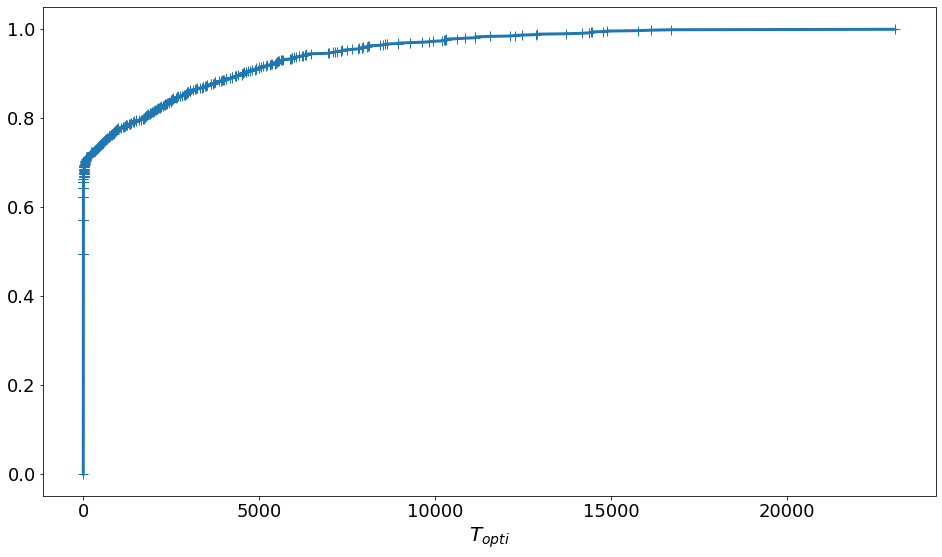

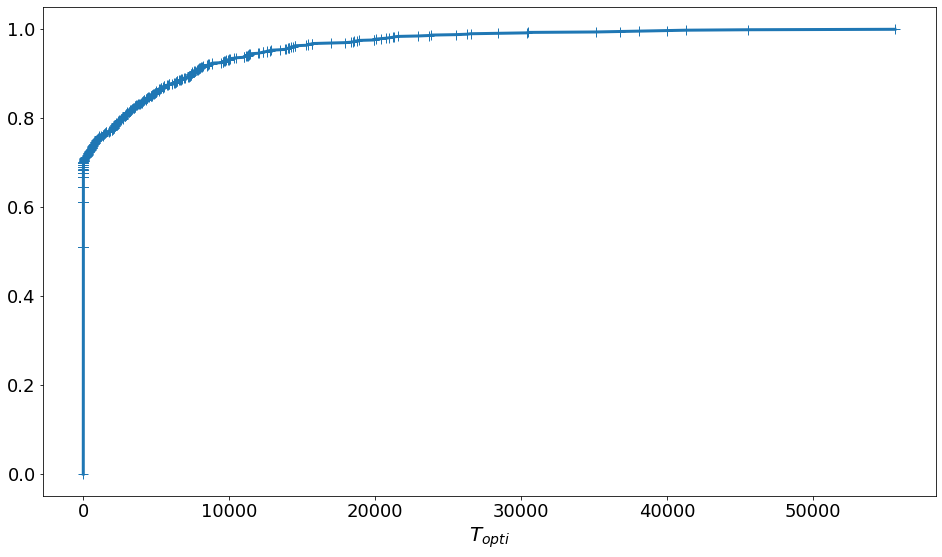

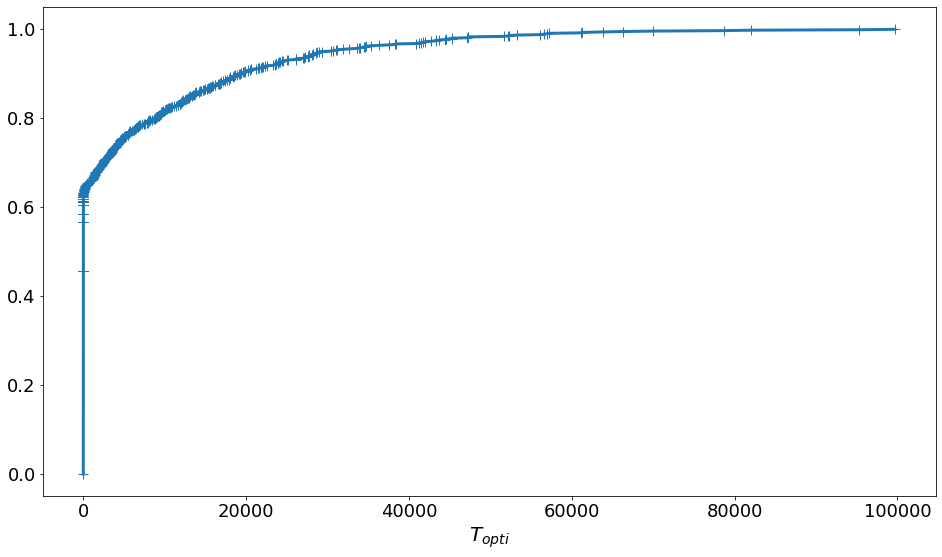

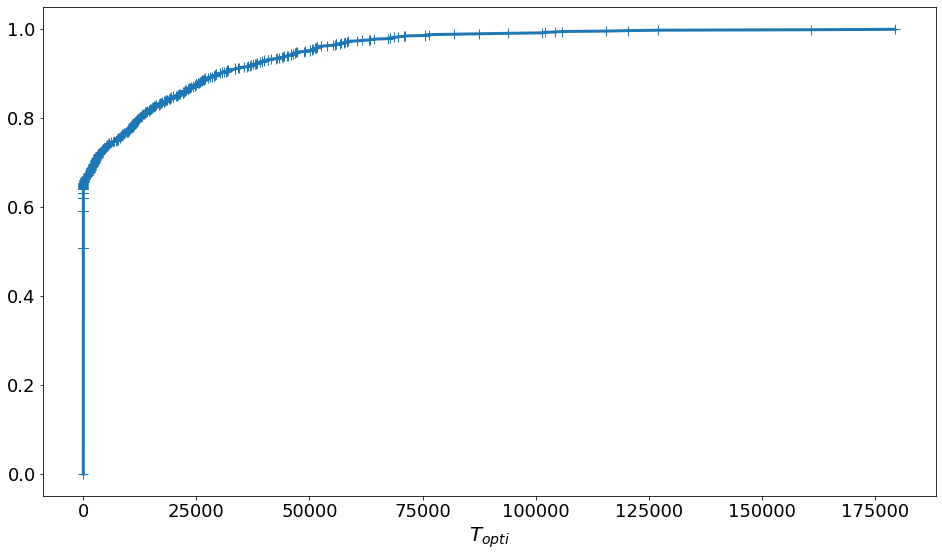

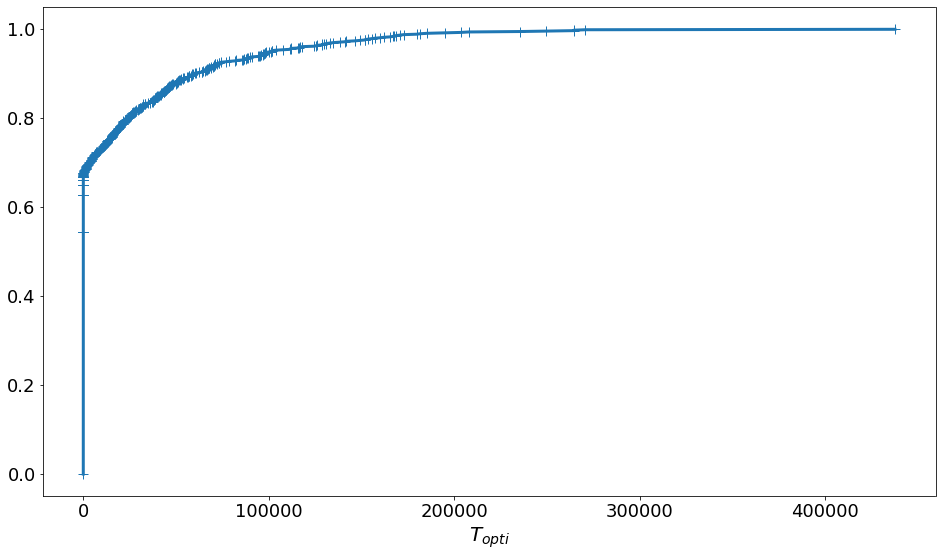

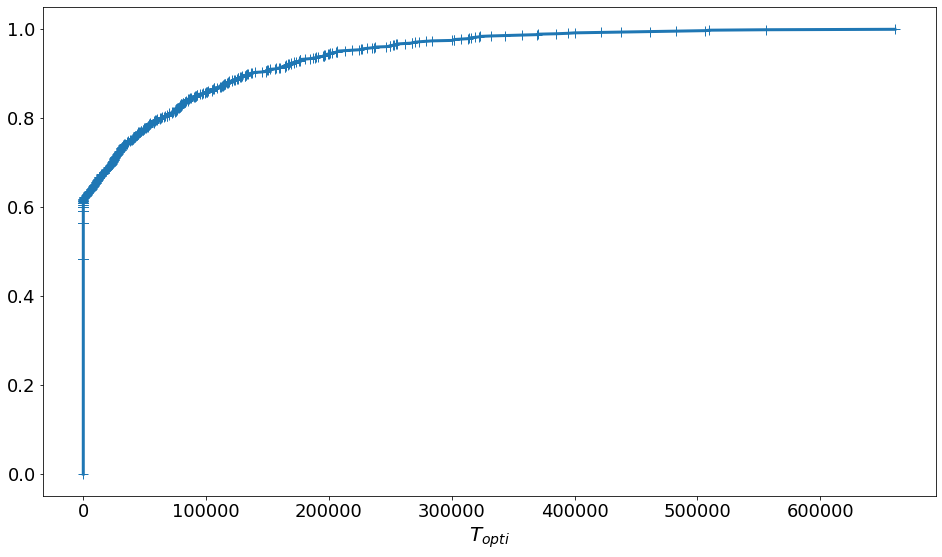

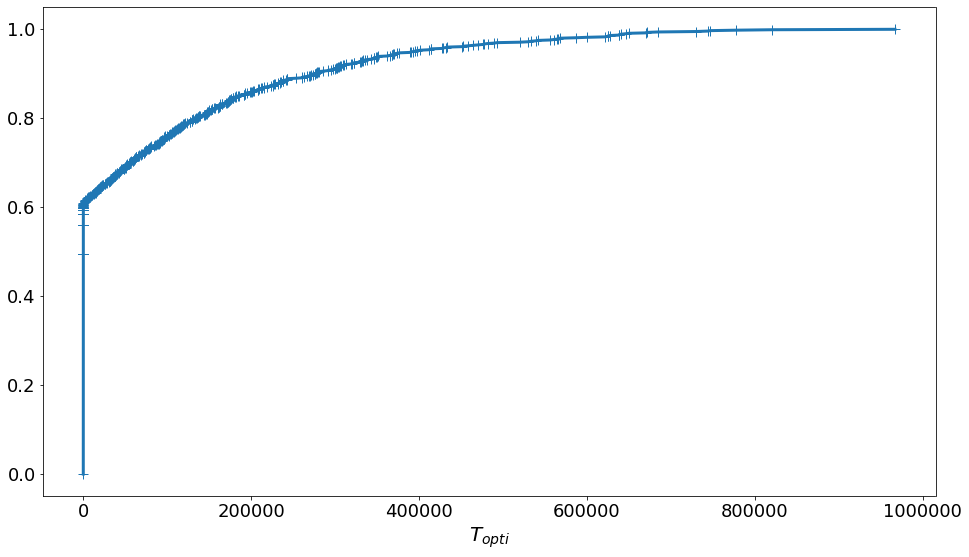

In [171]:
# testing the first time optimal is played

# Params
jump = 10
ms = list(range(100,161,jump))
n_trial = 1000 
a=1
b=0.6
n_init = 0
random_variable = "bernoulli"
post_distrib = "beta"

Param_dict = {}

Param_dict["ms"] = ms
Param_dict["n_trial"] = n_trial
Param_dict["a"] = a
Param_dict["b"] = b
Param_dict["random_variable"] = random_variable
Param_dict["post_distrib"] = post_distrib

upper_limit = 20000000

# Save Folder
experimentfolder = "Experience_opti_{}_{}_{}_a{:.3f}b{:.3f}".format(ms[0],ms[-1],jump,a,b)

if not os.path.exists(experimentfolder):
    os.makedirs(experimentfolder)

f = open(experimentfolder + "\\params.pkl","wb")
pickle.dump(Param_dict,f)
f.close()

distrib_first_optimal = [[] for m in ms]


for i,m in enumerate(ms[::-1]):
    print("m = ",m) 
    for iteration in range(n_trial):
        if iteration%100 == 0:
            print("begin_trial {}".format(iteration))

        env = Two_decision_env(m,a = a,b = b)
        player = CTS_exp(m,n_init = n_init)

        counter = 0
        while player.initialization:
                decision = player.play()
                reward_dict, regret = env.draw(decision)
                player.update(reward_dict)
        
        while player.decision and counter < upper_limit:
                decision = player.play()
                reward_dict, regret = env.draw(decision)
                player.update(reward_dict)
                counter += 1

                if counter%2000 == 0:
                    print("Have still not played the optimal arm at time {}".format(counter))

        distrib_first_optimal[-(i+1)].append(counter)   

np.save(experimentfolder +"\\Distribution",distrib_first_optimal)

#plot Result ECDF

for i,m in enumerate(ms):
    plt.figure(i,figsize = (16,9))
    plt.clf()
    cdf = ECDF(distrib_first_optimal[i])
    plt.plot([0]+list(np.sort(distrib_first_optimal[i])),[0]+list(cdf(np.sort(distrib_first_optimal[i]))),"+-",linewidth=3,markersize=10)
#plt.title("Distribution of first optimal play  for b = {:.1f} and d = {:d} ".format(b,d),fontsize=20)   
    plt.xlabel(r'$T_{opti}$', fontsize=20)
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    
    plt.savefig(experimentfolder+'\\ECDF_m{}_l{}.pdf'.format(m,n_init))


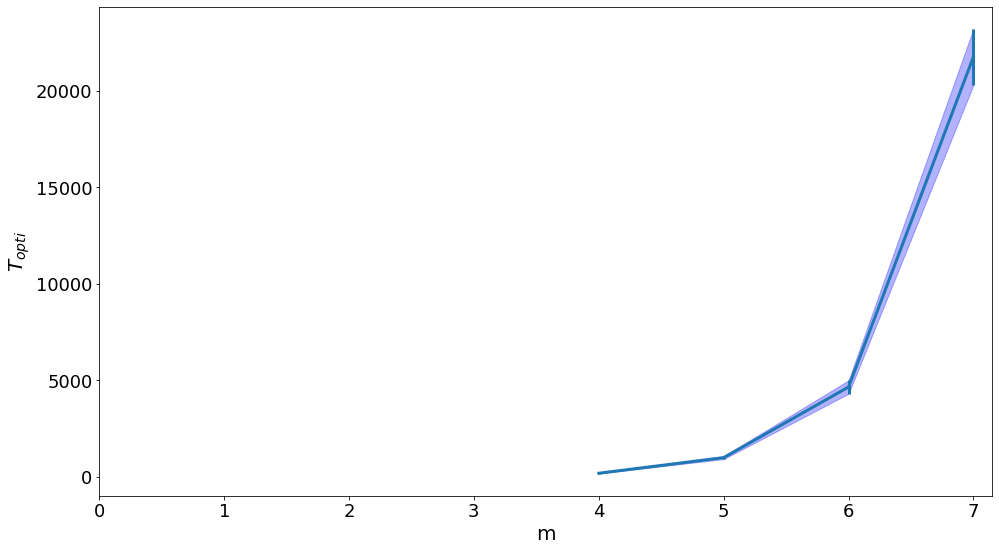

In [17]:
Average_time = np.mean(distrib_first_optimal, axis =1)
std = np.std(distrib_first_optimal, axis =1)/np.sqrt(n_trial)

plt.figure('Average Time',figsize = (16,9))
plt.clf()
plt.errorbar(ms, Average_time, std, linewidth=3)
plt.fill_between(ms,Average_time - std, Average_time + std , color='b', alpha=.3)


plt.xlim(xmin=0)

#plt.title("Average time the optimal decision is played for the first time in function of d",fontsize=20)
plt.ylabel(r'$T_{opti}$', fontsize=20)
plt.xlabel('m', fontsize=20)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

plt.savefig(experimentfolder +"\\Averagel{}.pdf".format(n_init))

### Average time for different delta



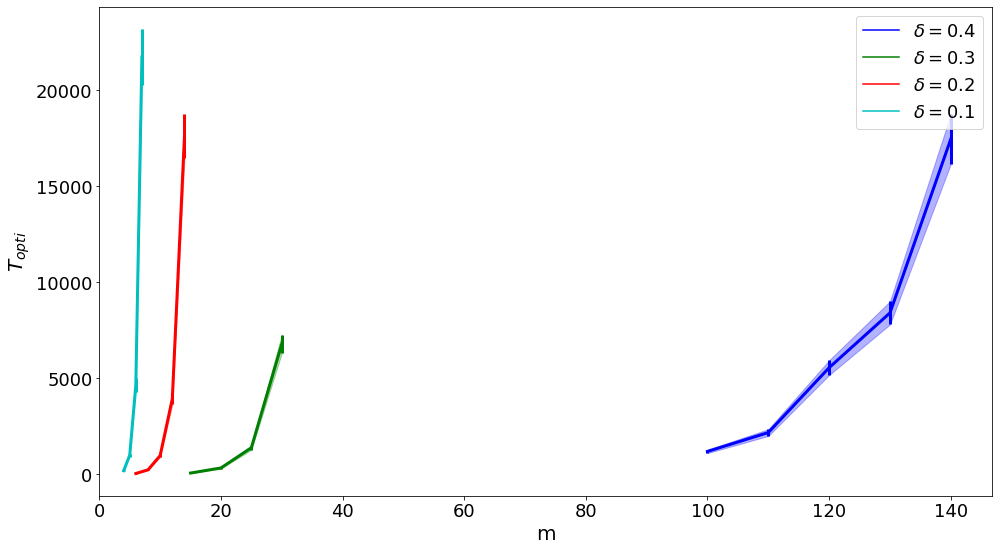

In [199]:



plt.figure('Average Time',figsize = (16,9))
plt.clf()

distrib_first_optimal = np.load("Experience_opti_100_160_10_a1.000b0.600\\Distribution.npy")[:-2:,::]
Average_time = np.mean(distrib_first_optimal, axis =1)
std = np.std(distrib_first_optimal, axis =1)/np.sqrt(n_trial)
ms = range(100,141,10)
plt.errorbar(ms, Average_time, std, linewidth=3, color='b')
plt.fill_between(ms,Average_time - std, Average_time + std , color='b', alpha=.3)
plt.plot(ms, Average_time, color='b', label = r"$\delta = 0.4$")


distrib_first_optimal = np.load("Experience_opti_15_30_5_a1.000b0.700\\Distribution.npy")
Average_time = np.mean(distrib_first_optimal, axis =1)
std = np.std(distrib_first_optimal, axis =1)/np.sqrt(n_trial)
ms = range(15,31,5)
plt.errorbar(ms, Average_time, std, linewidth=3, color='g')
plt.fill_between(ms,Average_time - std, Average_time + std , color='g', alpha=.3)
plt.plot(ms, Average_time, color='g', label = r"$\delta = 0.3$")


distrib_first_optimal = np.load("Experience_opti_6_14_2_a1.000b0.800\\Distribution.npy")
Average_time = np.mean(distrib_first_optimal, axis =1)
std = np.std(distrib_first_optimal, axis =1)/np.sqrt(n_trial)
ms = range(6,15,2)
plt.errorbar(ms, Average_time, std, linewidth=3,color='r')
plt.fill_between(ms,Average_time - std, Average_time + std , color='r', alpha=.3)
plt.plot(ms, Average_time,color='r', label = r"$\delta = 0.2$")



distrib_first_optimal = np.load("Experience_opti_4_7_1_a1.000b0.900\\Distribution.npy")
Average_time = np.mean(distrib_first_optimal, axis =1)
std = np.std(distrib_first_optimal, axis =1)/np.sqrt(n_trial)
ms = range(4,8,1)
plt.errorbar(ms, Average_time, std, linewidth=3,color='c')
plt.fill_between(ms,Average_time - std, Average_time + std , color='c', alpha=.3)
plt.plot(ms, Average_time, color = 'c', label = r"$\delta = 0.1$")





plt.xlim(xmin=0)

#plt.title("Average time the optimal decision is played for the first time in function of d",fontsize=20)
plt.ylabel(r'$T_{opti}$', fontsize=20)
plt.xlabel('m', fontsize=20)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.legend(fontsize = 18)

plt.savefig("First_playing time_Average_different_delta_2decision.pdf") 

## Warm Start

m =  10
begin_trial 0
begin_trial 100
begin_trial 200
begin_trial 300
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 3600

Have still not played the optimal arm at time 312000
Have still not played the optimal arm at time 314000
Have still not played the optimal arm at time 316000
Have still not played the optimal arm at time 318000
Have still not played the optimal arm at time 320000
Have still not played the optimal arm at time 322000
Have still not played the optimal arm at time 324000
Have still not played the optimal arm at time 326000
Have still not played the optimal arm at time 328000
Have still not played the optimal arm at time 330000
Have still not played the optimal arm at time 332000
Have still not played the optimal arm at time 334000
Have still not played the optimal arm at time 336000
Have still not played the optimal arm at time 338000
Have still not played the optimal arm at time 340000
Have still not played the optimal arm at time 342000
Have still not played the optimal arm at time 344000
Have still not played the optimal arm at time 346000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 622000
Have still not played the optimal arm at time 624000
Have still not played the optimal arm at time 626000
Have still not played the optimal arm at time 628000
Have still not played the optimal arm at time 630000
Have still not played the optimal arm at time 632000
Have still not played the optimal arm at time 634000
Have still not played the optimal arm at time 636000
Have still not played the optimal arm at time 638000
Have still not played the optimal arm at time 640000
Have still not played the optimal arm at time 642000
Have still not played the optimal arm at time 644000
Have still not played the optimal arm at time 646000
Have still not played the optimal arm at time 648000
Have still not played the optimal arm at time 650000
Have still not played the optimal arm at time 652000
Have still not played the optimal arm at time 654000
Have still not played the optimal arm at time 656000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 932000
Have still not played the optimal arm at time 934000
Have still not played the optimal arm at time 936000
Have still not played the optimal arm at time 938000
Have still not played the optimal arm at time 940000
Have still not played the optimal arm at time 942000
Have still not played the optimal arm at time 944000
Have still not played the optimal arm at time 946000
Have still not played the optimal arm at time 948000
Have still not played the optimal arm at time 950000
Have still not played the optimal arm at time 952000
Have still not played the optimal arm at time 954000
Have still not played the optimal arm at time 956000
Have still not played the optimal arm at time 958000
Have still not played the optimal arm at time 960000
Have still not played the optimal arm at time 962000
Have still not played the optimal arm at time 964000
Have still not played the optimal arm at time 966000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 1238000
Have still not played the optimal arm at time 1240000
Have still not played the optimal arm at time 1242000
Have still not played the optimal arm at time 1244000
Have still not played the optimal arm at time 1246000
Have still not played the optimal arm at time 1248000
Have still not played the optimal arm at time 1250000
Have still not played the optimal arm at time 1252000
Have still not played the optimal arm at time 1254000
Have still not played the optimal arm at time 1256000
Have still not played the optimal arm at time 1258000
Have still not played the optimal arm at time 1260000
Have still not played the optimal arm at time 1262000
Have still not played the optimal arm at time 1264000
Have still not played the optimal arm at time 1266000
Have still not played the optimal arm at time 1268000
Have still not played the optimal arm at time 1270000
Have still not played the optimal arm at time 1272000
Have still not played the op

Have still not played the optimal arm at time 1542000
Have still not played the optimal arm at time 1544000
Have still not played the optimal arm at time 1546000
Have still not played the optimal arm at time 1548000
Have still not played the optimal arm at time 1550000
Have still not played the optimal arm at time 1552000
Have still not played the optimal arm at time 1554000
Have still not played the optimal arm at time 1556000
Have still not played the optimal arm at time 1558000
Have still not played the optimal arm at time 1560000
Have still not played the optimal arm at time 1562000
Have still not played the optimal arm at time 1564000
Have still not played the optimal arm at time 1566000
Have still not played the optimal arm at time 1568000
Have still not played the optimal arm at time 1570000
Have still not played the optimal arm at time 1572000
Have still not played the optimal arm at time 1574000
Have still not played the optimal arm at time 1576000
Have still not played the op

Have still not played the optimal arm at time 1846000
Have still not played the optimal arm at time 1848000
Have still not played the optimal arm at time 1850000
Have still not played the optimal arm at time 1852000
Have still not played the optimal arm at time 1854000
Have still not played the optimal arm at time 1856000
Have still not played the optimal arm at time 1858000
Have still not played the optimal arm at time 1860000
Have still not played the optimal arm at time 1862000
Have still not played the optimal arm at time 1864000
Have still not played the optimal arm at time 1866000
Have still not played the optimal arm at time 1868000
Have still not played the optimal arm at time 1870000
Have still not played the optimal arm at time 1872000
Have still not played the optimal arm at time 1874000
Have still not played the optimal arm at time 1876000
Have still not played the optimal arm at time 1878000
Have still not played the optimal arm at time 1880000
Have still not played the op

Have still not played the optimal arm at time 2150000
Have still not played the optimal arm at time 2152000
Have still not played the optimal arm at time 2154000
Have still not played the optimal arm at time 2156000
Have still not played the optimal arm at time 2158000
Have still not played the optimal arm at time 2160000
Have still not played the optimal arm at time 2162000
Have still not played the optimal arm at time 2164000
Have still not played the optimal arm at time 2166000
Have still not played the optimal arm at time 2168000
Have still not played the optimal arm at time 2170000
Have still not played the optimal arm at time 2172000
Have still not played the optimal arm at time 2174000
Have still not played the optimal arm at time 2176000
Have still not played the optimal arm at time 2178000
Have still not played the optimal arm at time 2180000
Have still not played the optimal arm at time 2182000
Have still not played the optimal arm at time 2184000
Have still not played the op

Have still not played the optimal arm at time 2454000
Have still not played the optimal arm at time 2456000
Have still not played the optimal arm at time 2458000
Have still not played the optimal arm at time 2460000
Have still not played the optimal arm at time 2462000
Have still not played the optimal arm at time 2464000
Have still not played the optimal arm at time 2466000
Have still not played the optimal arm at time 2468000
Have still not played the optimal arm at time 2470000
Have still not played the optimal arm at time 2472000
Have still not played the optimal arm at time 2474000
Have still not played the optimal arm at time 2476000
Have still not played the optimal arm at time 2478000
Have still not played the optimal arm at time 2480000
Have still not played the optimal arm at time 2482000
Have still not played the optimal arm at time 2484000
Have still not played the optimal arm at time 2486000
Have still not played the optimal arm at time 2488000
Have still not played the op

Have still not played the optimal arm at time 2758000
Have still not played the optimal arm at time 2760000
Have still not played the optimal arm at time 2762000
Have still not played the optimal arm at time 2764000
Have still not played the optimal arm at time 2766000
Have still not played the optimal arm at time 2768000
Have still not played the optimal arm at time 2770000
Have still not played the optimal arm at time 2772000
Have still not played the optimal arm at time 2774000
Have still not played the optimal arm at time 2776000
Have still not played the optimal arm at time 2778000
Have still not played the optimal arm at time 2780000
Have still not played the optimal arm at time 2782000
Have still not played the optimal arm at time 2784000
Have still not played the optimal arm at time 2786000
Have still not played the optimal arm at time 2788000
Have still not played the optimal arm at time 2790000
Have still not played the optimal arm at time 2792000
Have still not played the op

Have still not played the optimal arm at time 3062000
Have still not played the optimal arm at time 3064000
Have still not played the optimal arm at time 3066000
Have still not played the optimal arm at time 3068000
Have still not played the optimal arm at time 3070000
Have still not played the optimal arm at time 3072000
Have still not played the optimal arm at time 3074000
Have still not played the optimal arm at time 3076000
Have still not played the optimal arm at time 3078000
Have still not played the optimal arm at time 3080000
Have still not played the optimal arm at time 3082000
Have still not played the optimal arm at time 3084000
Have still not played the optimal arm at time 3086000
Have still not played the optimal arm at time 3088000
Have still not played the optimal arm at time 3090000
Have still not played the optimal arm at time 3092000
Have still not played the optimal arm at time 3094000
Have still not played the optimal arm at time 3096000
Have still not played the op

Have still not played the optimal arm at time 3366000
Have still not played the optimal arm at time 3368000
Have still not played the optimal arm at time 3370000
Have still not played the optimal arm at time 3372000
Have still not played the optimal arm at time 3374000
Have still not played the optimal arm at time 3376000
Have still not played the optimal arm at time 3378000
Have still not played the optimal arm at time 3380000
Have still not played the optimal arm at time 3382000
Have still not played the optimal arm at time 3384000
Have still not played the optimal arm at time 3386000
Have still not played the optimal arm at time 3388000
Have still not played the optimal arm at time 3390000
Have still not played the optimal arm at time 3392000
Have still not played the optimal arm at time 3394000
Have still not played the optimal arm at time 3396000
Have still not played the optimal arm at time 3398000
Have still not played the optimal arm at time 3400000
Have still not played the op

Have still not played the optimal arm at time 3670000
Have still not played the optimal arm at time 3672000
Have still not played the optimal arm at time 3674000
Have still not played the optimal arm at time 3676000
Have still not played the optimal arm at time 3678000
Have still not played the optimal arm at time 3680000
Have still not played the optimal arm at time 3682000
Have still not played the optimal arm at time 3684000
Have still not played the optimal arm at time 3686000
Have still not played the optimal arm at time 3688000
Have still not played the optimal arm at time 3690000
Have still not played the optimal arm at time 3692000
Have still not played the optimal arm at time 3694000
Have still not played the optimal arm at time 3696000
Have still not played the optimal arm at time 3698000
Have still not played the optimal arm at time 3700000
Have still not played the optimal arm at time 3702000
Have still not played the optimal arm at time 3704000
Have still not played the op

Have still not played the optimal arm at time 3974000
Have still not played the optimal arm at time 3976000
Have still not played the optimal arm at time 3978000
Have still not played the optimal arm at time 3980000
Have still not played the optimal arm at time 3982000
Have still not played the optimal arm at time 3984000
Have still not played the optimal arm at time 3986000
Have still not played the optimal arm at time 3988000
Have still not played the optimal arm at time 3990000
Have still not played the optimal arm at time 3992000
Have still not played the optimal arm at time 3994000
Have still not played the optimal arm at time 3996000
Have still not played the optimal arm at time 3998000
Have still not played the optimal arm at time 4000000
Have still not played the optimal arm at time 4002000
Have still not played the optimal arm at time 4004000
Have still not played the optimal arm at time 4006000
Have still not played the optimal arm at time 4008000
Have still not played the op

Have still not played the optimal arm at time 240000
Have still not played the optimal arm at time 242000
Have still not played the optimal arm at time 244000
Have still not played the optimal arm at time 246000
Have still not played the optimal arm at time 248000
Have still not played the optimal arm at time 250000
Have still not played the optimal arm at time 252000
Have still not played the optimal arm at time 254000
Have still not played the optimal arm at time 256000
Have still not played the optimal arm at time 258000
Have still not played the optimal arm at time 260000
Have still not played the optimal arm at time 262000
Have still not played the optimal arm at time 264000
Have still not played the optimal arm at time 266000
Have still not played the optimal arm at time 268000
Have still not played the optimal arm at time 270000
Have still not played the optimal arm at time 272000
Have still not played the optimal arm at time 274000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 550000
Have still not played the optimal arm at time 552000
Have still not played the optimal arm at time 554000
Have still not played the optimal arm at time 556000
Have still not played the optimal arm at time 558000
Have still not played the optimal arm at time 560000
Have still not played the optimal arm at time 562000
Have still not played the optimal arm at time 564000
Have still not played the optimal arm at time 566000
Have still not played the optimal arm at time 568000
Have still not played the optimal arm at time 570000
Have still not played the optimal arm at time 572000
Have still not played the optimal arm at time 574000
Have still not played the optimal arm at time 576000
Have still not played the optimal arm at time 578000
Have still not played the optimal arm at time 580000
Have still not played the optimal arm at time 582000
Have still not played the optimal arm at time 584000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 860000
Have still not played the optimal arm at time 862000
Have still not played the optimal arm at time 864000
Have still not played the optimal arm at time 866000
Have still not played the optimal arm at time 868000
Have still not played the optimal arm at time 870000
Have still not played the optimal arm at time 872000
Have still not played the optimal arm at time 874000
Have still not played the optimal arm at time 876000
Have still not played the optimal arm at time 878000
Have still not played the optimal arm at time 880000
Have still not played the optimal arm at time 882000
Have still not played the optimal arm at time 884000
Have still not played the optimal arm at time 886000
Have still not played the optimal arm at time 888000
Have still not played the optimal arm at time 890000
Have still not played the optimal arm at time 892000
Have still not played the optimal arm at time 894000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 1168000
Have still not played the optimal arm at time 1170000
Have still not played the optimal arm at time 1172000
Have still not played the optimal arm at time 1174000
Have still not played the optimal arm at time 1176000
Have still not played the optimal arm at time 1178000
Have still not played the optimal arm at time 1180000
Have still not played the optimal arm at time 1182000
Have still not played the optimal arm at time 1184000
Have still not played the optimal arm at time 1186000
Have still not played the optimal arm at time 1188000
Have still not played the optimal arm at time 1190000
Have still not played the optimal arm at time 1192000
Have still not played the optimal arm at time 1194000
Have still not played the optimal arm at time 1196000
Have still not played the optimal arm at time 1198000
Have still not played the optimal arm at time 1200000
Have still not played the optimal arm at time 1202000
Have still not played the op

Have still not played the optimal arm at time 1472000
Have still not played the optimal arm at time 1474000
Have still not played the optimal arm at time 1476000
Have still not played the optimal arm at time 1478000
Have still not played the optimal arm at time 1480000
Have still not played the optimal arm at time 1482000
Have still not played the optimal arm at time 1484000
Have still not played the optimal arm at time 1486000
Have still not played the optimal arm at time 1488000
Have still not played the optimal arm at time 1490000
Have still not played the optimal arm at time 1492000
Have still not played the optimal arm at time 1494000
Have still not played the optimal arm at time 1496000
Have still not played the optimal arm at time 1498000
Have still not played the optimal arm at time 1500000
Have still not played the optimal arm at time 1502000
Have still not played the optimal arm at time 1504000
Have still not played the optimal arm at time 1506000
Have still not played the op

Have still not played the optimal arm at time 1776000
Have still not played the optimal arm at time 1778000
Have still not played the optimal arm at time 1780000
Have still not played the optimal arm at time 1782000
Have still not played the optimal arm at time 1784000
Have still not played the optimal arm at time 1786000
Have still not played the optimal arm at time 1788000
Have still not played the optimal arm at time 1790000
Have still not played the optimal arm at time 1792000
Have still not played the optimal arm at time 1794000
Have still not played the optimal arm at time 1796000
Have still not played the optimal arm at time 1798000
Have still not played the optimal arm at time 1800000
Have still not played the optimal arm at time 1802000
Have still not played the optimal arm at time 1804000
Have still not played the optimal arm at time 1806000
Have still not played the optimal arm at time 1808000
Have still not played the optimal arm at time 1810000
Have still not played the op

Have still not played the optimal arm at time 2080000
Have still not played the optimal arm at time 2082000
Have still not played the optimal arm at time 2084000
Have still not played the optimal arm at time 2086000
Have still not played the optimal arm at time 2088000
Have still not played the optimal arm at time 2090000
Have still not played the optimal arm at time 2092000
Have still not played the optimal arm at time 2094000
Have still not played the optimal arm at time 2096000
Have still not played the optimal arm at time 2098000
Have still not played the optimal arm at time 2100000
Have still not played the optimal arm at time 2102000
Have still not played the optimal arm at time 2104000
Have still not played the optimal arm at time 2106000
Have still not played the optimal arm at time 2108000
Have still not played the optimal arm at time 2110000
Have still not played the optimal arm at time 2112000
Have still not played the optimal arm at time 2114000
Have still not played the op

Have still not played the optimal arm at time 2384000
Have still not played the optimal arm at time 2386000
Have still not played the optimal arm at time 2388000
Have still not played the optimal arm at time 2390000
Have still not played the optimal arm at time 2392000
Have still not played the optimal arm at time 2394000
Have still not played the optimal arm at time 2396000
Have still not played the optimal arm at time 2398000
Have still not played the optimal arm at time 2400000
Have still not played the optimal arm at time 2402000
Have still not played the optimal arm at time 2404000
Have still not played the optimal arm at time 2406000
Have still not played the optimal arm at time 2408000
Have still not played the optimal arm at time 2410000
Have still not played the optimal arm at time 2412000
Have still not played the optimal arm at time 2414000
Have still not played the optimal arm at time 2416000
Have still not played the optimal arm at time 2418000
Have still not played the op

Have still not played the optimal arm at time 2688000
Have still not played the optimal arm at time 2690000
Have still not played the optimal arm at time 2692000
Have still not played the optimal arm at time 2694000
Have still not played the optimal arm at time 2696000
Have still not played the optimal arm at time 2698000
Have still not played the optimal arm at time 2700000
Have still not played the optimal arm at time 2702000
Have still not played the optimal arm at time 2704000
Have still not played the optimal arm at time 2706000
Have still not played the optimal arm at time 2708000
Have still not played the optimal arm at time 2710000
Have still not played the optimal arm at time 2712000
Have still not played the optimal arm at time 2714000
Have still not played the optimal arm at time 2716000
Have still not played the optimal arm at time 2718000
Have still not played the optimal arm at time 2720000
Have still not played the optimal arm at time 2722000
Have still not played the op

Have still not played the optimal arm at time 2992000
Have still not played the optimal arm at time 2994000
Have still not played the optimal arm at time 2996000
Have still not played the optimal arm at time 2998000
Have still not played the optimal arm at time 3000000
Have still not played the optimal arm at time 3002000
Have still not played the optimal arm at time 3004000
Have still not played the optimal arm at time 3006000
Have still not played the optimal arm at time 3008000
Have still not played the optimal arm at time 3010000
Have still not played the optimal arm at time 3012000
Have still not played the optimal arm at time 3014000
Have still not played the optimal arm at time 3016000
Have still not played the optimal arm at time 3018000
Have still not played the optimal arm at time 3020000
Have still not played the optimal arm at time 3022000
Have still not played the optimal arm at time 3024000
Have still not played the optimal arm at time 3026000
Have still not played the op

Have still not played the optimal arm at time 3296000
Have still not played the optimal arm at time 3298000
Have still not played the optimal arm at time 3300000
Have still not played the optimal arm at time 3302000
Have still not played the optimal arm at time 3304000
Have still not played the optimal arm at time 3306000
Have still not played the optimal arm at time 3308000
Have still not played the optimal arm at time 3310000
Have still not played the optimal arm at time 3312000
Have still not played the optimal arm at time 3314000
Have still not played the optimal arm at time 3316000
Have still not played the optimal arm at time 3318000
Have still not played the optimal arm at time 3320000
Have still not played the optimal arm at time 3322000
Have still not played the optimal arm at time 3324000
Have still not played the optimal arm at time 3326000
Have still not played the optimal arm at time 3328000
Have still not played the optimal arm at time 3330000
Have still not played the op

Have still not played the optimal arm at time 3600000
Have still not played the optimal arm at time 3602000
Have still not played the optimal arm at time 3604000
Have still not played the optimal arm at time 3606000
Have still not played the optimal arm at time 3608000
Have still not played the optimal arm at time 3610000
Have still not played the optimal arm at time 3612000
Have still not played the optimal arm at time 3614000
Have still not played the optimal arm at time 3616000
Have still not played the optimal arm at time 3618000
Have still not played the optimal arm at time 3620000
Have still not played the optimal arm at time 3622000
Have still not played the optimal arm at time 3624000
Have still not played the optimal arm at time 3626000
Have still not played the optimal arm at time 3628000
Have still not played the optimal arm at time 3630000
Have still not played the optimal arm at time 3632000
Have still not played the optimal arm at time 3634000
Have still not played the op

Have still not played the optimal arm at time 3904000
Have still not played the optimal arm at time 3906000
Have still not played the optimal arm at time 3908000
Have still not played the optimal arm at time 3910000
Have still not played the optimal arm at time 3912000
Have still not played the optimal arm at time 3914000
Have still not played the optimal arm at time 3916000
Have still not played the optimal arm at time 3918000
Have still not played the optimal arm at time 3920000
Have still not played the optimal arm at time 3922000
Have still not played the optimal arm at time 3924000
Have still not played the optimal arm at time 3926000
Have still not played the optimal arm at time 3928000
Have still not played the optimal arm at time 3930000
Have still not played the optimal arm at time 3932000
Have still not played the optimal arm at time 3934000
Have still not played the optimal arm at time 3936000
Have still not played the optimal arm at time 3938000
Have still not played the op

Have still not played the optimal arm at time 4208000
Have still not played the optimal arm at time 4210000
Have still not played the optimal arm at time 4212000
Have still not played the optimal arm at time 4214000
Have still not played the optimal arm at time 4216000
Have still not played the optimal arm at time 4218000
Have still not played the optimal arm at time 4220000
Have still not played the optimal arm at time 4222000
Have still not played the optimal arm at time 4224000
Have still not played the optimal arm at time 4226000
Have still not played the optimal arm at time 4228000
Have still not played the optimal arm at time 4230000
Have still not played the optimal arm at time 4232000
Have still not played the optimal arm at time 4234000
Have still not played the optimal arm at time 4236000
Have still not played the optimal arm at time 4238000
Have still not played the optimal arm at time 4240000
Have still not played the optimal arm at time 4242000
Have still not played the op

Have still not played the optimal arm at time 4512000
Have still not played the optimal arm at time 4514000
Have still not played the optimal arm at time 4516000
Have still not played the optimal arm at time 4518000
Have still not played the optimal arm at time 4520000
Have still not played the optimal arm at time 4522000
Have still not played the optimal arm at time 4524000
Have still not played the optimal arm at time 4526000
Have still not played the optimal arm at time 4528000
Have still not played the optimal arm at time 4530000
Have still not played the optimal arm at time 4532000
Have still not played the optimal arm at time 4534000
Have still not played the optimal arm at time 4536000
Have still not played the optimal arm at time 4538000
Have still not played the optimal arm at time 4540000
Have still not played the optimal arm at time 4542000
Have still not played the optimal arm at time 4544000
Have still not played the optimal arm at time 4546000
Have still not played the op

Have still not played the optimal arm at time 4816000
Have still not played the optimal arm at time 4818000
Have still not played the optimal arm at time 4820000
Have still not played the optimal arm at time 4822000
Have still not played the optimal arm at time 4824000
Have still not played the optimal arm at time 4826000
Have still not played the optimal arm at time 4828000
Have still not played the optimal arm at time 4830000
Have still not played the optimal arm at time 4832000
Have still not played the optimal arm at time 4834000
Have still not played the optimal arm at time 4836000
Have still not played the optimal arm at time 4838000
Have still not played the optimal arm at time 4840000
Have still not played the optimal arm at time 4842000
Have still not played the optimal arm at time 4844000
Have still not played the optimal arm at time 4846000
Have still not played the optimal arm at time 4848000
Have still not played the optimal arm at time 4850000
Have still not played the op

Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 434000
Have still not played the optimal arm at time 436000
Have still not played the optimal arm at time 438000
Have still not played the optimal arm at time 440000
Have still not played the optimal arm at time 442000
Have still not played the optimal arm at time 444000
Have still not played the optimal arm at time 446000
Have still not played the optimal arm at time 448000
Have still not played the optimal arm at time 450000
Have still not played the optimal arm at time 452000
Have still not played the optimal arm at time 454000
Have still not played the optimal arm at time 456000
Have still not played the optimal arm at time 458000
Have still not played the optimal arm at time 460000
Have still not played the optimal arm at time 462000
Have still not played the optimal arm at time 464000
Have still not played the optimal arm at time 466000
Have still not played the optimal arm at time 468000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 744000
Have still not played the optimal arm at time 746000
Have still not played the optimal arm at time 748000
Have still not played the optimal arm at time 750000
Have still not played the optimal arm at time 752000
Have still not played the optimal arm at time 754000
Have still not played the optimal arm at time 756000
Have still not played the optimal arm at time 758000
Have still not played the optimal arm at time 760000
Have still not played the optimal arm at time 762000
Have still not played the optimal arm at time 764000
Have still not played the optimal arm at time 766000
Have still not played the optimal arm at time 768000
Have still not played the optimal arm at time 770000
Have still not played the optimal arm at time 772000
Have still not played the optimal arm at time 774000
Have still not played the optimal arm at time 776000
Have still not played the optimal arm at time 778000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 1054000
Have still not played the optimal arm at time 1056000
Have still not played the optimal arm at time 1058000
Have still not played the optimal arm at time 1060000
Have still not played the optimal arm at time 1062000
Have still not played the optimal arm at time 1064000
Have still not played the optimal arm at time 1066000
Have still not played the optimal arm at time 1068000
Have still not played the optimal arm at time 1070000
Have still not played the optimal arm at time 1072000
Have still not played the optimal arm at time 1074000
Have still not played the optimal arm at time 1076000
Have still not played the optimal arm at time 1078000
Have still not played the optimal arm at time 1080000
Have still not played the optimal arm at time 1082000
Have still not played the optimal arm at time 1084000
Have still not played the optimal arm at time 1086000
Have still not played the optimal arm at time 1088000
Have still not played the op

Have still not played the optimal arm at time 1358000
Have still not played the optimal arm at time 1360000
Have still not played the optimal arm at time 1362000
Have still not played the optimal arm at time 1364000
Have still not played the optimal arm at time 1366000
Have still not played the optimal arm at time 1368000
Have still not played the optimal arm at time 1370000
Have still not played the optimal arm at time 1372000
Have still not played the optimal arm at time 1374000
Have still not played the optimal arm at time 1376000
Have still not played the optimal arm at time 1378000
Have still not played the optimal arm at time 1380000
Have still not played the optimal arm at time 1382000
Have still not played the optimal arm at time 1384000
Have still not played the optimal arm at time 1386000
Have still not played the optimal arm at time 1388000
Have still not played the optimal arm at time 1390000
Have still not played the optimal arm at time 1392000
Have still not played the op

Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 12600

Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 440000
Have still not played the optimal arm at time 442000
Have still not played the optimal arm at time 444000
Have still not played the optimal arm at time 446000
Have still not played the optimal arm at time 448000
Have still not played the optimal arm at time 450000
Have still not played the optimal arm at time 452000
Have still not played the optimal arm at time 454000
Have still not played the optimal arm at time 456000
Have still not played the optimal arm at time 458000
Have still not played the optimal arm at time 460000
Have still not played the optimal arm at time 462000
Have still not played the optimal arm at time 464000
Have still not played the optimal arm at time 466000
Have still not played the optimal arm at time 468000
Have still not played the optimal arm at time 470000
Have still not played the optimal arm at time 472000
Have still not played the optimal arm at time 474000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 750000
Have still not played the optimal arm at time 752000
Have still not played the optimal arm at time 754000
Have still not played the optimal arm at time 756000
Have still not played the optimal arm at time 758000
Have still not played the optimal arm at time 760000
Have still not played the optimal arm at time 762000
Have still not played the optimal arm at time 764000
Have still not played the optimal arm at time 766000
Have still not played the optimal arm at time 768000
Have still not played the optimal arm at time 770000
Have still not played the optimal arm at time 772000
Have still not played the optimal arm at time 774000
Have still not played the optimal arm at time 776000
Have still not played the optimal arm at time 778000
Have still not played the optimal arm at time 780000
Have still not played the optimal arm at time 782000
Have still not played the optimal arm at time 784000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 1060000
Have still not played the optimal arm at time 1062000
Have still not played the optimal arm at time 1064000
Have still not played the optimal arm at time 1066000
Have still not played the optimal arm at time 1068000
Have still not played the optimal arm at time 1070000
Have still not played the optimal arm at time 1072000
Have still not played the optimal arm at time 1074000
Have still not played the optimal arm at time 1076000
Have still not played the optimal arm at time 1078000
Have still not played the optimal arm at time 1080000
Have still not played the optimal arm at time 1082000
Have still not played the optimal arm at time 1084000
Have still not played the optimal arm at time 1086000
Have still not played the optimal arm at time 1088000
Have still not played the optimal arm at time 1090000
Have still not played the optimal arm at time 1092000
Have still not played the optimal arm at time 1094000
Have still not played the op

Have still not played the optimal arm at time 1364000
Have still not played the optimal arm at time 1366000
Have still not played the optimal arm at time 1368000
Have still not played the optimal arm at time 1370000
Have still not played the optimal arm at time 1372000
Have still not played the optimal arm at time 1374000
Have still not played the optimal arm at time 1376000
Have still not played the optimal arm at time 1378000
Have still not played the optimal arm at time 1380000
Have still not played the optimal arm at time 1382000
Have still not played the optimal arm at time 1384000
Have still not played the optimal arm at time 1386000
Have still not played the optimal arm at time 1388000
Have still not played the optimal arm at time 1390000
Have still not played the optimal arm at time 1392000
Have still not played the optimal arm at time 1394000
Have still not played the optimal arm at time 1396000
Have still not played the optimal arm at time 1398000
Have still not played the op

Have still not played the optimal arm at time 1668000
Have still not played the optimal arm at time 1670000
Have still not played the optimal arm at time 1672000
Have still not played the optimal arm at time 1674000
Have still not played the optimal arm at time 1676000
Have still not played the optimal arm at time 1678000
Have still not played the optimal arm at time 1680000
Have still not played the optimal arm at time 1682000
Have still not played the optimal arm at time 1684000
Have still not played the optimal arm at time 1686000
Have still not played the optimal arm at time 1688000
Have still not played the optimal arm at time 1690000
Have still not played the optimal arm at time 1692000
Have still not played the optimal arm at time 1694000
Have still not played the optimal arm at time 1696000
Have still not played the optimal arm at time 1698000
Have still not played the optimal arm at time 1700000
Have still not played the optimal arm at time 1702000
Have still not played the op

Have still not played the optimal arm at time 1972000
Have still not played the optimal arm at time 1974000
Have still not played the optimal arm at time 1976000
Have still not played the optimal arm at time 1978000
Have still not played the optimal arm at time 1980000
Have still not played the optimal arm at time 1982000
Have still not played the optimal arm at time 1984000
Have still not played the optimal arm at time 1986000
Have still not played the optimal arm at time 1988000
Have still not played the optimal arm at time 1990000
Have still not played the optimal arm at time 1992000
Have still not played the optimal arm at time 1994000
Have still not played the optimal arm at time 1996000
Have still not played the optimal arm at time 1998000
Have still not played the optimal arm at time 2000000
Have still not played the optimal arm at time 2002000
Have still not played the optimal arm at time 2004000
Have still not played the optimal arm at time 2006000
Have still not played the op

Have still not played the optimal arm at time 2276000
Have still not played the optimal arm at time 2278000
Have still not played the optimal arm at time 2280000
Have still not played the optimal arm at time 2282000
Have still not played the optimal arm at time 2284000
Have still not played the optimal arm at time 2286000
Have still not played the optimal arm at time 2288000
Have still not played the optimal arm at time 2290000
Have still not played the optimal arm at time 2292000
Have still not played the optimal arm at time 2294000
Have still not played the optimal arm at time 2296000
Have still not played the optimal arm at time 2298000
Have still not played the optimal arm at time 2300000
Have still not played the optimal arm at time 2302000
Have still not played the optimal arm at time 2304000
Have still not played the optimal arm at time 2306000
Have still not played the optimal arm at time 2308000
Have still not played the optimal arm at time 2310000
Have still not played the op

Have still not played the optimal arm at time 2580000
Have still not played the optimal arm at time 2582000
Have still not played the optimal arm at time 2584000
Have still not played the optimal arm at time 2586000
Have still not played the optimal arm at time 2588000
Have still not played the optimal arm at time 2590000
Have still not played the optimal arm at time 2592000
Have still not played the optimal arm at time 2594000
Have still not played the optimal arm at time 2596000
Have still not played the optimal arm at time 2598000
Have still not played the optimal arm at time 2600000
Have still not played the optimal arm at time 2602000
Have still not played the optimal arm at time 2604000
Have still not played the optimal arm at time 2606000
Have still not played the optimal arm at time 2608000
Have still not played the optimal arm at time 2610000
Have still not played the optimal arm at time 2612000
Have still not played the optimal arm at time 2614000
Have still not played the op

Have still not played the optimal arm at time 2884000
Have still not played the optimal arm at time 2886000
Have still not played the optimal arm at time 2888000
Have still not played the optimal arm at time 2890000
Have still not played the optimal arm at time 2892000
Have still not played the optimal arm at time 2894000
Have still not played the optimal arm at time 2896000
Have still not played the optimal arm at time 2898000
Have still not played the optimal arm at time 2900000
Have still not played the optimal arm at time 2902000
Have still not played the optimal arm at time 2904000
Have still not played the optimal arm at time 2906000
Have still not played the optimal arm at time 2908000
Have still not played the optimal arm at time 2910000
Have still not played the optimal arm at time 2912000
Have still not played the optimal arm at time 2914000
Have still not played the optimal arm at time 2916000
Have still not played the optimal arm at time 2918000
Have still not played the op

Have still not played the optimal arm at time 3188000
Have still not played the optimal arm at time 3190000
Have still not played the optimal arm at time 3192000
Have still not played the optimal arm at time 3194000
Have still not played the optimal arm at time 3196000
Have still not played the optimal arm at time 3198000
Have still not played the optimal arm at time 3200000
Have still not played the optimal arm at time 3202000
Have still not played the optimal arm at time 3204000
Have still not played the optimal arm at time 3206000
Have still not played the optimal arm at time 3208000
Have still not played the optimal arm at time 3210000
Have still not played the optimal arm at time 3212000
Have still not played the optimal arm at time 3214000
Have still not played the optimal arm at time 3216000
Have still not played the optimal arm at time 3218000
Have still not played the optimal arm at time 3220000
Have still not played the optimal arm at time 3222000
Have still not played the op

Have still not played the optimal arm at time 3492000
Have still not played the optimal arm at time 3494000
Have still not played the optimal arm at time 3496000
Have still not played the optimal arm at time 3498000
Have still not played the optimal arm at time 3500000
Have still not played the optimal arm at time 3502000
Have still not played the optimal arm at time 3504000
Have still not played the optimal arm at time 3506000
Have still not played the optimal arm at time 3508000
Have still not played the optimal arm at time 3510000
Have still not played the optimal arm at time 3512000
Have still not played the optimal arm at time 3514000
Have still not played the optimal arm at time 3516000
Have still not played the optimal arm at time 3518000
Have still not played the optimal arm at time 3520000
Have still not played the optimal arm at time 3522000
Have still not played the optimal arm at time 3524000
Have still not played the optimal arm at time 3526000
Have still not played the op

Have still not played the optimal arm at time 3796000
Have still not played the optimal arm at time 3798000
Have still not played the optimal arm at time 3800000
Have still not played the optimal arm at time 3802000
Have still not played the optimal arm at time 3804000
Have still not played the optimal arm at time 3806000
Have still not played the optimal arm at time 3808000
Have still not played the optimal arm at time 3810000
Have still not played the optimal arm at time 3812000
Have still not played the optimal arm at time 3814000
Have still not played the optimal arm at time 3816000
Have still not played the optimal arm at time 3818000
Have still not played the optimal arm at time 3820000
Have still not played the optimal arm at time 3822000
Have still not played the optimal arm at time 3824000
Have still not played the optimal arm at time 3826000
Have still not played the optimal arm at time 3828000
Have still not played the optimal arm at time 3830000
Have still not played the op

Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 182000
Have still not played the optimal arm at time 184000
Have still not played the optimal arm at time 186000
Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 196000
Have still not played the optimal arm at time 198000
Have still not played the optimal arm at time 200000
Have still not played the optimal arm at time 202000
Have still not played the optimal arm at time 204000
Have still not played the optimal arm at time 206000
Have still not played the optimal arm at time 208000
Have still not played the optimal arm at time 210000
Have still not played the optimal arm at time 212000
Have still not played the optimal arm at time 214000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 178000
Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 182000
Have still not played the optimal arm at time 184000
Have still not played the optimal arm at time 186000
Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 196000
Have still not played the optimal arm at time 198000
Have still not played the optimal arm at time 200000
Have still not played the optimal arm at time 202000
Have still not played the optimal arm at time 204000
Have still not played the optimal arm at time 206000
Have still not played the optimal arm at time 208000
Have still not played the optimal arm at time 210000
Have still not played the optimal arm at time 212000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 13

Have still not played the optimal arm at time 406000
Have still not played the optimal arm at time 408000
Have still not played the optimal arm at time 410000
Have still not played the optimal arm at time 412000
Have still not played the optimal arm at time 414000
Have still not played the optimal arm at time 416000
Have still not played the optimal arm at time 418000
Have still not played the optimal arm at time 420000
Have still not played the optimal arm at time 422000
Have still not played the optimal arm at time 424000
Have still not played the optimal arm at time 426000
Have still not played the optimal arm at time 428000
Have still not played the optimal arm at time 430000
Have still not played the optimal arm at time 432000
Have still not played the optimal arm at time 434000
Have still not played the optimal arm at time 436000
Have still not played the optimal arm at time 438000
Have still not played the optimal arm at time 440000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 266000
Have still not played the optimal arm at time 268000
Have still not played the optimal arm at time 270000
Have still not played the optimal arm at time 272000
Have still not played the optimal arm at time 274000
Have still not played the optimal arm at time 276000
Have still not played the optimal arm at time 278000
Have still not played the optimal arm at time 280000
Have still not played the optimal arm at time 282000
Have still not played the optimal arm at time 284000
Have still not played the optimal arm at time 286000
Have still not played the optimal arm at time 288000
Have still not played the optimal arm at time 290000
Have still not played the optimal arm at time 292000
Have still not played the optimal arm at time 294000
Have still not played the optimal arm at time 296000
Have still not played the optimal arm at time 298000
Have still not played the optimal arm at time 300000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 576000
Have still not played the optimal arm at time 578000
Have still not played the optimal arm at time 580000
Have still not played the optimal arm at time 582000
Have still not played the optimal arm at time 584000
Have still not played the optimal arm at time 586000
Have still not played the optimal arm at time 588000
Have still not played the optimal arm at time 590000
Have still not played the optimal arm at time 592000
Have still not played the optimal arm at time 594000
Have still not played the optimal arm at time 596000
Have still not played the optimal arm at time 598000
Have still not played the optimal arm at time 600000
Have still not played the optimal arm at time 602000
Have still not played the optimal arm at time 604000
Have still not played the optimal arm at time 606000
Have still not played the optimal arm at time 608000
Have still not played the optimal arm at time 610000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 886000
Have still not played the optimal arm at time 888000
Have still not played the optimal arm at time 890000
Have still not played the optimal arm at time 892000
Have still not played the optimal arm at time 894000
Have still not played the optimal arm at time 896000
Have still not played the optimal arm at time 898000
Have still not played the optimal arm at time 900000
Have still not played the optimal arm at time 902000
Have still not played the optimal arm at time 904000
Have still not played the optimal arm at time 906000
Have still not played the optimal arm at time 908000
Have still not played the optimal arm at time 910000
Have still not played the optimal arm at time 912000
Have still not played the optimal arm at time 914000
Have still not played the optimal arm at time 916000
Have still not played the optimal arm at time 918000
Have still not played the optimal arm at time 920000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 1192000
Have still not played the optimal arm at time 1194000
Have still not played the optimal arm at time 1196000
Have still not played the optimal arm at time 1198000
Have still not played the optimal arm at time 1200000
Have still not played the optimal arm at time 1202000
Have still not played the optimal arm at time 1204000
Have still not played the optimal arm at time 1206000
Have still not played the optimal arm at time 1208000
Have still not played the optimal arm at time 1210000
Have still not played the optimal arm at time 1212000
Have still not played the optimal arm at time 1214000
Have still not played the optimal arm at time 1216000
Have still not played the optimal arm at time 1218000
Have still not played the optimal arm at time 1220000
Have still not played the optimal arm at time 1222000
Have still not played the optimal arm at time 1224000
Have still not played the optimal arm at time 1226000
Have still not played the op

Have still not played the optimal arm at time 1496000
Have still not played the optimal arm at time 1498000
Have still not played the optimal arm at time 1500000
Have still not played the optimal arm at time 1502000
Have still not played the optimal arm at time 1504000
Have still not played the optimal arm at time 1506000
Have still not played the optimal arm at time 1508000
Have still not played the optimal arm at time 1510000
Have still not played the optimal arm at time 1512000
Have still not played the optimal arm at time 1514000
Have still not played the optimal arm at time 1516000
Have still not played the optimal arm at time 1518000
Have still not played the optimal arm at time 1520000
Have still not played the optimal arm at time 1522000
Have still not played the optimal arm at time 1524000
Have still not played the optimal arm at time 1526000
Have still not played the optimal arm at time 1528000
Have still not played the optimal arm at time 1530000
Have still not played the op

Have still not played the optimal arm at time 1800000
Have still not played the optimal arm at time 1802000
Have still not played the optimal arm at time 1804000
Have still not played the optimal arm at time 1806000
Have still not played the optimal arm at time 1808000
Have still not played the optimal arm at time 1810000
Have still not played the optimal arm at time 1812000
Have still not played the optimal arm at time 1814000
Have still not played the optimal arm at time 1816000
Have still not played the optimal arm at time 1818000
Have still not played the optimal arm at time 1820000
Have still not played the optimal arm at time 1822000
Have still not played the optimal arm at time 1824000
Have still not played the optimal arm at time 1826000
Have still not played the optimal arm at time 1828000
Have still not played the optimal arm at time 1830000
Have still not played the optimal arm at time 1832000
Have still not played the optimal arm at time 1834000
Have still not played the op

Have still not played the optimal arm at time 2104000
Have still not played the optimal arm at time 2106000
Have still not played the optimal arm at time 2108000
Have still not played the optimal arm at time 2110000
Have still not played the optimal arm at time 2112000
Have still not played the optimal arm at time 2114000
Have still not played the optimal arm at time 2116000
Have still not played the optimal arm at time 2118000
Have still not played the optimal arm at time 2120000
Have still not played the optimal arm at time 2122000
Have still not played the optimal arm at time 2124000
Have still not played the optimal arm at time 2126000
Have still not played the optimal arm at time 2128000
Have still not played the optimal arm at time 2130000
Have still not played the optimal arm at time 2132000
Have still not played the optimal arm at time 2134000
Have still not played the optimal arm at time 2136000
Have still not played the optimal arm at time 2138000
Have still not played the op

Have still not played the optimal arm at time 2408000
Have still not played the optimal arm at time 2410000
Have still not played the optimal arm at time 2412000
Have still not played the optimal arm at time 2414000
Have still not played the optimal arm at time 2416000
Have still not played the optimal arm at time 2418000
Have still not played the optimal arm at time 2420000
Have still not played the optimal arm at time 2422000
Have still not played the optimal arm at time 2424000
Have still not played the optimal arm at time 2426000
Have still not played the optimal arm at time 2428000
Have still not played the optimal arm at time 2430000
Have still not played the optimal arm at time 2432000
Have still not played the optimal arm at time 2434000
Have still not played the optimal arm at time 2436000
Have still not played the optimal arm at time 2438000
Have still not played the optimal arm at time 2440000
Have still not played the optimal arm at time 2442000
Have still not played the op

Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Hav

Have still not played the optimal arm at time 390000
Have still not played the optimal arm at time 392000
Have still not played the optimal arm at time 394000
Have still not played the optimal arm at time 396000
Have still not played the optimal arm at time 398000
Have still not played the optimal arm at time 400000
Have still not played the optimal arm at time 402000
Have still not played the optimal arm at time 404000
Have still not played the optimal arm at time 406000
Have still not played the optimal arm at time 408000
Have still not played the optimal arm at time 410000
Have still not played the optimal arm at time 412000
Have still not played the optimal arm at time 414000
Have still not played the optimal arm at time 416000
Have still not played the optimal arm at time 418000
Have still not played the optimal arm at time 420000
Have still not played the optimal arm at time 422000
Have still not played the optimal arm at time 424000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 700000
Have still not played the optimal arm at time 702000
Have still not played the optimal arm at time 704000
Have still not played the optimal arm at time 706000
Have still not played the optimal arm at time 708000
Have still not played the optimal arm at time 710000
Have still not played the optimal arm at time 712000
Have still not played the optimal arm at time 714000
Have still not played the optimal arm at time 716000
Have still not played the optimal arm at time 718000
Have still not played the optimal arm at time 720000
Have still not played the optimal arm at time 722000
Have still not played the optimal arm at time 724000
Have still not played the optimal arm at time 726000
Have still not played the optimal arm at time 728000
Have still not played the optimal arm at time 730000
Have still not played the optimal arm at time 732000
Have still not played the optimal arm at time 734000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 1010000
Have still not played the optimal arm at time 1012000
Have still not played the optimal arm at time 1014000
Have still not played the optimal arm at time 1016000
Have still not played the optimal arm at time 1018000
Have still not played the optimal arm at time 1020000
Have still not played the optimal arm at time 1022000
Have still not played the optimal arm at time 1024000
Have still not played the optimal arm at time 1026000
Have still not played the optimal arm at time 1028000
Have still not played the optimal arm at time 1030000
Have still not played the optimal arm at time 1032000
Have still not played the optimal arm at time 1034000
Have still not played the optimal arm at time 1036000
Have still not played the optimal arm at time 1038000
Have still not played the optimal arm at time 1040000
Have still not played the optimal arm at time 1042000
Have still not played the optimal arm at time 1044000
Have still not played the op

Have still not played the optimal arm at time 1314000
Have still not played the optimal arm at time 1316000
Have still not played the optimal arm at time 1318000
Have still not played the optimal arm at time 1320000
Have still not played the optimal arm at time 1322000
Have still not played the optimal arm at time 1324000
Have still not played the optimal arm at time 1326000
Have still not played the optimal arm at time 1328000
Have still not played the optimal arm at time 1330000
Have still not played the optimal arm at time 1332000
Have still not played the optimal arm at time 1334000
Have still not played the optimal arm at time 1336000
Have still not played the optimal arm at time 1338000
Have still not played the optimal arm at time 1340000
Have still not played the optimal arm at time 1342000
Have still not played the optimal arm at time 1344000
Have still not played the optimal arm at time 1346000
Have still not played the optimal arm at time 1348000
Have still not played the op

Have still not played the optimal arm at time 1618000
Have still not played the optimal arm at time 1620000
Have still not played the optimal arm at time 1622000
Have still not played the optimal arm at time 1624000
Have still not played the optimal arm at time 1626000
Have still not played the optimal arm at time 1628000
Have still not played the optimal arm at time 1630000
Have still not played the optimal arm at time 1632000
Have still not played the optimal arm at time 1634000
Have still not played the optimal arm at time 1636000
Have still not played the optimal arm at time 1638000
Have still not played the optimal arm at time 1640000
Have still not played the optimal arm at time 1642000
Have still not played the optimal arm at time 1644000
Have still not played the optimal arm at time 1646000
Have still not played the optimal arm at time 1648000
Have still not played the optimal arm at time 1650000
Have still not played the optimal arm at time 1652000
Have still not played the op

Have still not played the optimal arm at time 1922000
Have still not played the optimal arm at time 1924000
Have still not played the optimal arm at time 1926000
Have still not played the optimal arm at time 1928000
Have still not played the optimal arm at time 1930000
Have still not played the optimal arm at time 1932000
Have still not played the optimal arm at time 1934000
Have still not played the optimal arm at time 1936000
Have still not played the optimal arm at time 1938000
Have still not played the optimal arm at time 1940000
Have still not played the optimal arm at time 1942000
Have still not played the optimal arm at time 1944000
Have still not played the optimal arm at time 1946000
Have still not played the optimal arm at time 1948000
Have still not played the optimal arm at time 1950000
Have still not played the optimal arm at time 1952000
Have still not played the optimal arm at time 1954000
Have still not played the optimal arm at time 1956000
Have still not played the op

Have still not played the optimal arm at time 2226000
Have still not played the optimal arm at time 2228000
Have still not played the optimal arm at time 2230000
Have still not played the optimal arm at time 2232000
Have still not played the optimal arm at time 2234000
Have still not played the optimal arm at time 2236000
Have still not played the optimal arm at time 2238000
Have still not played the optimal arm at time 2240000
Have still not played the optimal arm at time 2242000
Have still not played the optimal arm at time 2244000
Have still not played the optimal arm at time 2246000
Have still not played the optimal arm at time 2248000
Have still not played the optimal arm at time 2250000
Have still not played the optimal arm at time 2252000
Have still not played the optimal arm at time 2254000
Have still not played the optimal arm at time 2256000
Have still not played the optimal arm at time 2258000
Have still not played the optimal arm at time 2260000
Have still not played the op

Have still not played the optimal arm at time 2530000
Have still not played the optimal arm at time 2532000
Have still not played the optimal arm at time 2534000
Have still not played the optimal arm at time 2536000
Have still not played the optimal arm at time 2538000
Have still not played the optimal arm at time 2540000
Have still not played the optimal arm at time 2542000
Have still not played the optimal arm at time 2544000
Have still not played the optimal arm at time 2546000
Have still not played the optimal arm at time 2548000
Have still not played the optimal arm at time 2550000
Have still not played the optimal arm at time 2552000
Have still not played the optimal arm at time 2554000
Have still not played the optimal arm at time 2556000
Have still not played the optimal arm at time 2558000
Have still not played the optimal arm at time 2560000
Have still not played the optimal arm at time 2562000
Have still not played the optimal arm at time 2564000
Have still not played the op

Have still not played the optimal arm at time 2834000
Have still not played the optimal arm at time 2836000
Have still not played the optimal arm at time 2838000
Have still not played the optimal arm at time 2840000
Have still not played the optimal arm at time 2842000
Have still not played the optimal arm at time 2844000
Have still not played the optimal arm at time 2846000
Have still not played the optimal arm at time 2848000
Have still not played the optimal arm at time 2850000
Have still not played the optimal arm at time 2852000
Have still not played the optimal arm at time 2854000
Have still not played the optimal arm at time 2856000
Have still not played the optimal arm at time 2858000
Have still not played the optimal arm at time 2860000
Have still not played the optimal arm at time 2862000
Have still not played the optimal arm at time 2864000
Have still not played the optimal arm at time 2866000
Have still not played the optimal arm at time 2868000
Have still not played the op

Have still not played the optimal arm at time 3138000
Have still not played the optimal arm at time 3140000
Have still not played the optimal arm at time 3142000
Have still not played the optimal arm at time 3144000
Have still not played the optimal arm at time 3146000
Have still not played the optimal arm at time 3148000
Have still not played the optimal arm at time 3150000
Have still not played the optimal arm at time 3152000
Have still not played the optimal arm at time 3154000
Have still not played the optimal arm at time 3156000
Have still not played the optimal arm at time 3158000
Have still not played the optimal arm at time 3160000
Have still not played the optimal arm at time 3162000
Have still not played the optimal arm at time 3164000
Have still not played the optimal arm at time 3166000
Have still not played the optimal arm at time 3168000
Have still not played the optimal arm at time 3170000
Have still not played the optimal arm at time 3172000
Have still not played the op

Have still not played the optimal arm at time 3442000
Have still not played the optimal arm at time 3444000
Have still not played the optimal arm at time 3446000
Have still not played the optimal arm at time 3448000
Have still not played the optimal arm at time 3450000
Have still not played the optimal arm at time 3452000
Have still not played the optimal arm at time 3454000
Have still not played the optimal arm at time 3456000
Have still not played the optimal arm at time 3458000
Have still not played the optimal arm at time 3460000
Have still not played the optimal arm at time 3462000
Have still not played the optimal arm at time 3464000
Have still not played the optimal arm at time 3466000
Have still not played the optimal arm at time 3468000
Have still not played the optimal arm at time 3470000
Have still not played the optimal arm at time 3472000
Have still not played the optimal arm at time 3474000
Have still not played the optimal arm at time 3476000
Have still not played the op

Have still not played the optimal arm at time 3746000
Have still not played the optimal arm at time 3748000
Have still not played the optimal arm at time 3750000
Have still not played the optimal arm at time 3752000
Have still not played the optimal arm at time 3754000
Have still not played the optimal arm at time 3756000
Have still not played the optimal arm at time 3758000
Have still not played the optimal arm at time 3760000
Have still not played the optimal arm at time 3762000
Have still not played the optimal arm at time 3764000
Have still not played the optimal arm at time 3766000
Have still not played the optimal arm at time 3768000
Have still not played the optimal arm at time 3770000
Have still not played the optimal arm at time 3772000
Have still not played the optimal arm at time 3774000
Have still not played the optimal arm at time 3776000
Have still not played the optimal arm at time 3778000
Have still not played the optimal arm at time 3780000
Have still not played the op

Have still not played the optimal arm at time 4050000
Have still not played the optimal arm at time 4052000
Have still not played the optimal arm at time 4054000
Have still not played the optimal arm at time 4056000
Have still not played the optimal arm at time 4058000
Have still not played the optimal arm at time 4060000
Have still not played the optimal arm at time 4062000
Have still not played the optimal arm at time 4064000
Have still not played the optimal arm at time 4066000
Have still not played the optimal arm at time 4068000
Have still not played the optimal arm at time 4070000
Have still not played the optimal arm at time 4072000
Have still not played the optimal arm at time 4074000
Have still not played the optimal arm at time 4076000
Have still not played the optimal arm at time 4078000
Have still not played the optimal arm at time 4080000
Have still not played the optimal arm at time 4082000
Have still not played the optimal arm at time 4084000
Have still not played the op

Have still not played the optimal arm at time 4354000
Have still not played the optimal arm at time 4356000
Have still not played the optimal arm at time 4358000
Have still not played the optimal arm at time 4360000
Have still not played the optimal arm at time 4362000
Have still not played the optimal arm at time 4364000
Have still not played the optimal arm at time 4366000
Have still not played the optimal arm at time 4368000
Have still not played the optimal arm at time 4370000
Have still not played the optimal arm at time 4372000
Have still not played the optimal arm at time 4374000
Have still not played the optimal arm at time 4376000
Have still not played the optimal arm at time 4378000
Have still not played the optimal arm at time 4380000
Have still not played the optimal arm at time 4382000
Have still not played the optimal arm at time 4384000
Have still not played the optimal arm at time 4386000
Have still not played the optimal arm at time 4388000
Have still not played the op

Have still not played the optimal arm at time 4658000
Have still not played the optimal arm at time 4660000
Have still not played the optimal arm at time 4662000
Have still not played the optimal arm at time 4664000
Have still not played the optimal arm at time 4666000
Have still not played the optimal arm at time 4668000
Have still not played the optimal arm at time 4670000
Have still not played the optimal arm at time 4672000
Have still not played the optimal arm at time 4674000
Have still not played the optimal arm at time 4676000
Have still not played the optimal arm at time 4678000
Have still not played the optimal arm at time 4680000
Have still not played the optimal arm at time 4682000
Have still not played the optimal arm at time 4684000
Have still not played the optimal arm at time 4686000
Have still not played the optimal arm at time 4688000
Have still not played the optimal arm at time 4690000
Have still not played the optimal arm at time 4692000
Have still not played the op

Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 442000
Have still not played the optimal arm at time 444000
Have still not played the optimal arm at time 446000
Have still not played the optimal arm at time 448000
Have still not played the optimal arm at time 450000
Have still not played the optimal arm at time 452000
Have still not played the optimal arm at time 454000
Have still not played the optimal arm at time 456000
Have still not played the optimal arm at time 458000
Have still not played the optimal arm at time 460000
Have still not played the optimal arm at time 462000
Have still not played the optimal arm at time 464000
Have still not played the optimal arm at time 466000
Have still not played the optimal arm at time 468000
Have still not played the optimal arm at time 470000
Have still not played the optimal arm at time 472000
Have still not played the optimal arm at time 474000
Have still not played the optimal arm at time 476000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 752000
Have still not played the optimal arm at time 754000
Have still not played the optimal arm at time 756000
Have still not played the optimal arm at time 758000
Have still not played the optimal arm at time 760000
Have still not played the optimal arm at time 762000
Have still not played the optimal arm at time 764000
Have still not played the optimal arm at time 766000
Have still not played the optimal arm at time 768000
Have still not played the optimal arm at time 770000
Have still not played the optimal arm at time 772000
Have still not played the optimal arm at time 774000
Have still not played the optimal arm at time 776000
Have still not played the optimal arm at time 778000
Have still not played the optimal arm at time 780000
Have still not played the optimal arm at time 782000
Have still not played the optimal arm at time 784000
Have still not played the optimal arm at time 786000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 1062000
Have still not played the optimal arm at time 1064000
Have still not played the optimal arm at time 1066000
Have still not played the optimal arm at time 1068000
Have still not played the optimal arm at time 1070000
Have still not played the optimal arm at time 1072000
Have still not played the optimal arm at time 1074000
Have still not played the optimal arm at time 1076000
Have still not played the optimal arm at time 1078000
Have still not played the optimal arm at time 1080000
Have still not played the optimal arm at time 1082000
Have still not played the optimal arm at time 1084000
Have still not played the optimal arm at time 1086000
Have still not played the optimal arm at time 1088000
Have still not played the optimal arm at time 1090000
Have still not played the optimal arm at time 1092000
Have still not played the optimal arm at time 1094000
Have still not played the optimal arm at time 1096000
Have still not played the op

Have still not played the optimal arm at time 1366000
Have still not played the optimal arm at time 1368000
Have still not played the optimal arm at time 1370000
Have still not played the optimal arm at time 1372000
Have still not played the optimal arm at time 1374000
Have still not played the optimal arm at time 1376000
Have still not played the optimal arm at time 1378000
Have still not played the optimal arm at time 1380000
Have still not played the optimal arm at time 1382000
Have still not played the optimal arm at time 1384000
Have still not played the optimal arm at time 1386000
Have still not played the optimal arm at time 1388000
Have still not played the optimal arm at time 1390000
Have still not played the optimal arm at time 1392000
Have still not played the optimal arm at time 1394000
Have still not played the optimal arm at time 1396000
Have still not played the optimal arm at time 1398000
Have still not played the optimal arm at time 1400000
Have still not played the op

Have still not played the optimal arm at time 1670000
Have still not played the optimal arm at time 1672000
Have still not played the optimal arm at time 1674000
Have still not played the optimal arm at time 1676000
Have still not played the optimal arm at time 1678000
Have still not played the optimal arm at time 1680000
Have still not played the optimal arm at time 1682000
Have still not played the optimal arm at time 1684000
Have still not played the optimal arm at time 1686000
Have still not played the optimal arm at time 1688000
Have still not played the optimal arm at time 1690000
Have still not played the optimal arm at time 1692000
Have still not played the optimal arm at time 1694000
Have still not played the optimal arm at time 1696000
Have still not played the optimal arm at time 1698000
Have still not played the optimal arm at time 1700000
Have still not played the optimal arm at time 1702000
Have still not played the optimal arm at time 1704000
Have still not played the op

Have still not played the optimal arm at time 1974000
Have still not played the optimal arm at time 1976000
Have still not played the optimal arm at time 1978000
Have still not played the optimal arm at time 1980000
Have still not played the optimal arm at time 1982000
Have still not played the optimal arm at time 1984000
Have still not played the optimal arm at time 1986000
Have still not played the optimal arm at time 1988000
Have still not played the optimal arm at time 1990000
Have still not played the optimal arm at time 1992000
Have still not played the optimal arm at time 1994000
Have still not played the optimal arm at time 1996000
Have still not played the optimal arm at time 1998000
Have still not played the optimal arm at time 2000000
Have still not played the optimal arm at time 2002000
Have still not played the optimal arm at time 2004000
Have still not played the optimal arm at time 2006000
Have still not played the optimal arm at time 2008000
Have still not played the op

Have still not played the optimal arm at time 2278000
Have still not played the optimal arm at time 2280000
Have still not played the optimal arm at time 2282000
Have still not played the optimal arm at time 2284000
Have still not played the optimal arm at time 2286000
Have still not played the optimal arm at time 2288000
Have still not played the optimal arm at time 2290000
Have still not played the optimal arm at time 2292000
Have still not played the optimal arm at time 2294000
Have still not played the optimal arm at time 2296000
Have still not played the optimal arm at time 2298000
Have still not played the optimal arm at time 2300000
Have still not played the optimal arm at time 2302000
Have still not played the optimal arm at time 2304000
Have still not played the optimal arm at time 2306000
Have still not played the optimal arm at time 2308000
Have still not played the optimal arm at time 2310000
Have still not played the optimal arm at time 2312000
Have still not played the op

Have still not played the optimal arm at time 2582000
Have still not played the optimal arm at time 2584000
Have still not played the optimal arm at time 2586000
Have still not played the optimal arm at time 2588000
Have still not played the optimal arm at time 2590000
Have still not played the optimal arm at time 2592000
Have still not played the optimal arm at time 2594000
Have still not played the optimal arm at time 2596000
Have still not played the optimal arm at time 2598000
Have still not played the optimal arm at time 2600000
Have still not played the optimal arm at time 2602000
Have still not played the optimal arm at time 2604000
Have still not played the optimal arm at time 2606000
Have still not played the optimal arm at time 2608000
Have still not played the optimal arm at time 2610000
Have still not played the optimal arm at time 2612000
Have still not played the optimal arm at time 2614000
Have still not played the optimal arm at time 2616000
Have still not played the op

Have still not played the optimal arm at time 2886000
Have still not played the optimal arm at time 2888000
Have still not played the optimal arm at time 2890000
Have still not played the optimal arm at time 2892000
Have still not played the optimal arm at time 2894000
Have still not played the optimal arm at time 2896000
Have still not played the optimal arm at time 2898000
Have still not played the optimal arm at time 2900000
Have still not played the optimal arm at time 2902000
Have still not played the optimal arm at time 2904000
Have still not played the optimal arm at time 2906000
Have still not played the optimal arm at time 2908000
Have still not played the optimal arm at time 2910000
Have still not played the optimal arm at time 2912000
Have still not played the optimal arm at time 2914000
Have still not played the optimal arm at time 2916000
Have still not played the optimal arm at time 2918000
Have still not played the optimal arm at time 2920000
Have still not played the op

Have still not played the optimal arm at time 3190000
Have still not played the optimal arm at time 3192000
Have still not played the optimal arm at time 3194000
Have still not played the optimal arm at time 3196000
Have still not played the optimal arm at time 3198000
Have still not played the optimal arm at time 3200000
Have still not played the optimal arm at time 3202000
Have still not played the optimal arm at time 3204000
Have still not played the optimal arm at time 3206000
Have still not played the optimal arm at time 3208000
Have still not played the optimal arm at time 3210000
Have still not played the optimal arm at time 3212000
Have still not played the optimal arm at time 3214000
Have still not played the optimal arm at time 3216000
Have still not played the optimal arm at time 3218000
Have still not played the optimal arm at time 3220000
Have still not played the optimal arm at time 3222000
Have still not played the optimal arm at time 3224000
Have still not played the op

Have still not played the optimal arm at time 3494000
Have still not played the optimal arm at time 3496000
Have still not played the optimal arm at time 3498000
Have still not played the optimal arm at time 3500000
Have still not played the optimal arm at time 3502000
Have still not played the optimal arm at time 3504000
Have still not played the optimal arm at time 3506000
Have still not played the optimal arm at time 3508000
Have still not played the optimal arm at time 3510000
Have still not played the optimal arm at time 3512000
Have still not played the optimal arm at time 3514000
Have still not played the optimal arm at time 3516000
Have still not played the optimal arm at time 3518000
Have still not played the optimal arm at time 3520000
Have still not played the optimal arm at time 3522000
Have still not played the optimal arm at time 3524000
Have still not played the optimal arm at time 3526000
Have still not played the optimal arm at time 3528000
Have still not played the op

Have still not played the optimal arm at time 3798000
Have still not played the optimal arm at time 3800000
Have still not played the optimal arm at time 3802000
Have still not played the optimal arm at time 3804000
Have still not played the optimal arm at time 3806000
Have still not played the optimal arm at time 3808000
Have still not played the optimal arm at time 3810000
Have still not played the optimal arm at time 3812000
Have still not played the optimal arm at time 3814000
Have still not played the optimal arm at time 3816000
Have still not played the optimal arm at time 3818000
Have still not played the optimal arm at time 3820000
Have still not played the optimal arm at time 3822000
Have still not played the optimal arm at time 3824000
Have still not played the optimal arm at time 3826000
Have still not played the optimal arm at time 3828000
Have still not played the optimal arm at time 3830000
Have still not played the optimal arm at time 3832000
Have still not played the op

Have still not played the optimal arm at time 4102000
Have still not played the optimal arm at time 4104000
Have still not played the optimal arm at time 4106000
Have still not played the optimal arm at time 4108000
Have still not played the optimal arm at time 4110000
Have still not played the optimal arm at time 4112000
Have still not played the optimal arm at time 4114000
Have still not played the optimal arm at time 4116000
Have still not played the optimal arm at time 4118000
Have still not played the optimal arm at time 4120000
Have still not played the optimal arm at time 4122000
Have still not played the optimal arm at time 4124000
Have still not played the optimal arm at time 4126000
Have still not played the optimal arm at time 4128000
Have still not played the optimal arm at time 4130000
Have still not played the optimal arm at time 4132000
Have still not played the optimal arm at time 4134000
Have still not played the optimal arm at time 4136000
Have still not played the op

Have still not played the optimal arm at time 4406000
Have still not played the optimal arm at time 4408000
Have still not played the optimal arm at time 4410000
Have still not played the optimal arm at time 4412000
Have still not played the optimal arm at time 4414000
Have still not played the optimal arm at time 4416000
Have still not played the optimal arm at time 4418000
Have still not played the optimal arm at time 4420000
Have still not played the optimal arm at time 4422000
Have still not played the optimal arm at time 4424000
Have still not played the optimal arm at time 4426000
Have still not played the optimal arm at time 4428000
Have still not played the optimal arm at time 4430000
Have still not played the optimal arm at time 4432000
Have still not played the optimal arm at time 4434000
Have still not played the optimal arm at time 4436000
Have still not played the optimal arm at time 4438000
Have still not played the optimal arm at time 4440000
Have still not played the op

Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Ha

Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130

Have still not played the optimal arm at time 404000
Have still not played the optimal arm at time 406000
Have still not played the optimal arm at time 408000
Have still not played the optimal arm at time 410000
Have still not played the optimal arm at time 412000
Have still not played the optimal arm at time 414000
Have still not played the optimal arm at time 416000
Have still not played the optimal arm at time 418000
Have still not played the optimal arm at time 420000
Have still not played the optimal arm at time 422000
Have still not played the optimal arm at time 424000
Have still not played the optimal arm at time 426000
Have still not played the optimal arm at time 428000
Have still not played the optimal arm at time 430000
Have still not played the optimal arm at time 432000
Have still not played the optimal arm at time 434000
Have still not played the optimal arm at time 436000
Have still not played the optimal arm at time 438000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 714000
Have still not played the optimal arm at time 716000
Have still not played the optimal arm at time 718000
Have still not played the optimal arm at time 720000
Have still not played the optimal arm at time 722000
Have still not played the optimal arm at time 724000
Have still not played the optimal arm at time 726000
Have still not played the optimal arm at time 728000
Have still not played the optimal arm at time 730000
Have still not played the optimal arm at time 732000
Have still not played the optimal arm at time 734000
Have still not played the optimal arm at time 736000
Have still not played the optimal arm at time 738000
Have still not played the optimal arm at time 740000
Have still not played the optimal arm at time 742000
Have still not played the optimal arm at time 744000
Have still not played the optimal arm at time 746000
Have still not played the optimal arm at time 748000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 262000
Have still not played the optimal arm at time 264000
Have still not played the optimal arm at time 266000
Have still not played the optimal arm at time 268000
Have still not played the optimal arm at time 270000
Have still not played the optimal arm at time 272000
Have still not played the optimal arm at time 274000
Have still not played the optimal arm at time 276000
Have still not played the optimal arm at time 278000
Have still not played the optimal arm at time 280000
Have still not played the optimal arm at time 282000
Have still not played the optimal arm at time 284000
Have still not played the optimal arm at time 286000
Have still not played the optimal arm at time 288000
Have still not played the optimal arm at time 290000
Have still not played the optimal arm at time 292000
Have still not played the optimal arm at time 294000
Have still not played the optimal arm at time 296000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 572000
Have still not played the optimal arm at time 574000
Have still not played the optimal arm at time 576000
Have still not played the optimal arm at time 578000
Have still not played the optimal arm at time 580000
Have still not played the optimal arm at time 582000
Have still not played the optimal arm at time 584000
Have still not played the optimal arm at time 586000
Have still not played the optimal arm at time 588000
Have still not played the optimal arm at time 590000
Have still not played the optimal arm at time 592000
Have still not played the optimal arm at time 594000
Have still not played the optimal arm at time 596000
Have still not played the optimal arm at time 598000
Have still not played the optimal arm at time 600000
Have still not played the optimal arm at time 602000
Have still not played the optimal arm at time 604000
Have still not played the optimal arm at time 606000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 882000
Have still not played the optimal arm at time 884000
Have still not played the optimal arm at time 886000
Have still not played the optimal arm at time 888000
Have still not played the optimal arm at time 890000
Have still not played the optimal arm at time 892000
Have still not played the optimal arm at time 894000
Have still not played the optimal arm at time 896000
Have still not played the optimal arm at time 898000
Have still not played the optimal arm at time 900000
Have still not played the optimal arm at time 902000
Have still not played the optimal arm at time 904000
Have still not played the optimal arm at time 906000
Have still not played the optimal arm at time 908000
Have still not played the optimal arm at time 910000
Have still not played the optimal arm at time 912000
Have still not played the optimal arm at time 914000
Have still not played the optimal arm at time 916000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 426000
Have still not played the optimal arm at time 428000
Have still not played the optimal arm at time 430000
Have still not played the optimal arm at time 432000
Have still not played the optimal arm at time 434000
Have still not played the optimal arm at time 436000
Have still not played the optimal arm at time 438000
Have still not played the optimal arm at time 440000
Have still not played the optimal arm at time 442000
Have still not played the optimal arm at time 444000
Have still not played the optimal arm at time 446000
Have still not played the optimal arm at time 448000
Have still not played the optimal arm at time 450000
Have still not played the optimal arm at time 452000
Have still not played the optimal arm at time 454000
Have still not played the optimal arm at time 456000
Have still not played the optimal arm at time 458000
Have still not played the optimal arm at time 460000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 736000
Have still not played the optimal arm at time 738000
Have still not played the optimal arm at time 740000
Have still not played the optimal arm at time 742000
Have still not played the optimal arm at time 744000
Have still not played the optimal arm at time 746000
Have still not played the optimal arm at time 748000
Have still not played the optimal arm at time 750000
Have still not played the optimal arm at time 752000
Have still not played the optimal arm at time 754000
Have still not played the optimal arm at time 756000
Have still not played the optimal arm at time 758000
Have still not played the optimal arm at time 760000
Have still not played the optimal arm at time 762000
Have still not played the optimal arm at time 764000
Have still not played the optimal arm at time 766000
Have still not played the optimal arm at time 768000
Have still not played the optimal arm at time 770000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 170000
Have still not played the optimal arm at time 172000
Have still not played the optimal arm at time 174000
Have still not played the optimal arm at time 176000
Have still not played the optimal arm at time 178000
Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 182000
Have still not played the optimal arm at time 184000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not 

Have still not played the optimal arm at time 316000
Have still not played the optimal arm at time 318000
Have still not played the optimal arm at time 320000
Have still not played the optimal arm at time 322000
Have still not played the optimal arm at time 324000
Have still not played the optimal arm at time 326000
Have still not played the optimal arm at time 328000
Have still not played the optimal arm at time 330000
Have still not played the optimal arm at time 332000
Have still not played the optimal arm at time 334000
Have still not played the optimal arm at time 336000
Have still not played the optimal arm at time 338000
Have still not played the optimal arm at time 340000
begin_trial 500
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm a

Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still no

Have still not played the optimal arm at time 308000
Have still not played the optimal arm at time 310000
Have still not played the optimal arm at time 312000
Have still not played the optimal arm at time 314000
Have still not played the optimal arm at time 316000
Have still not played the optimal arm at time 318000
Have still not played the optimal arm at time 320000
Have still not played the optimal arm at time 322000
Have still not played the optimal arm at time 324000
Have still not played the optimal arm at time 326000
Have still not played the optimal arm at time 328000
Have still not played the optimal arm at time 330000
Have still not played the optimal arm at time 332000
Have still not played the optimal arm at time 334000
Have still not played the optimal arm at time 336000
Have still not played the optimal arm at time 338000
Have still not played the optimal arm at time 340000
Have still not played the optimal arm at time 342000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
begin_trial 100
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Ha

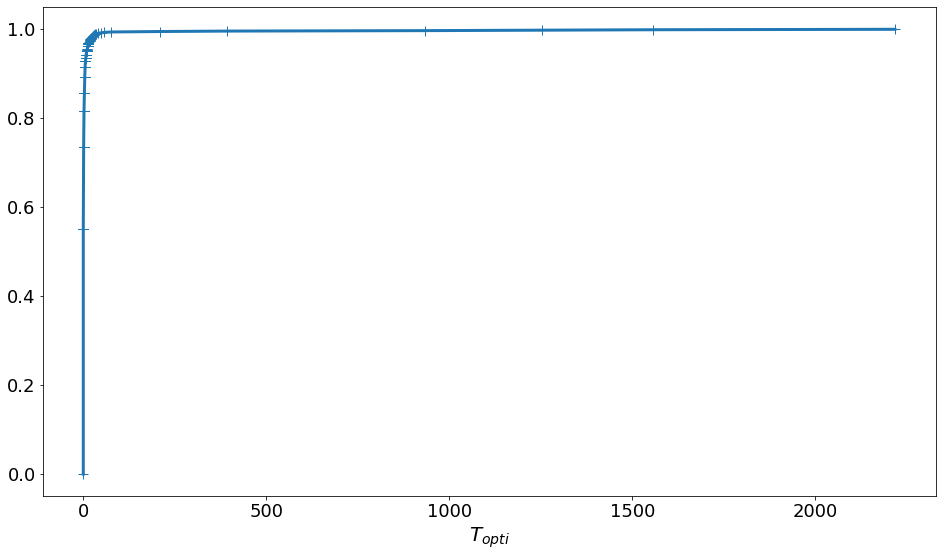

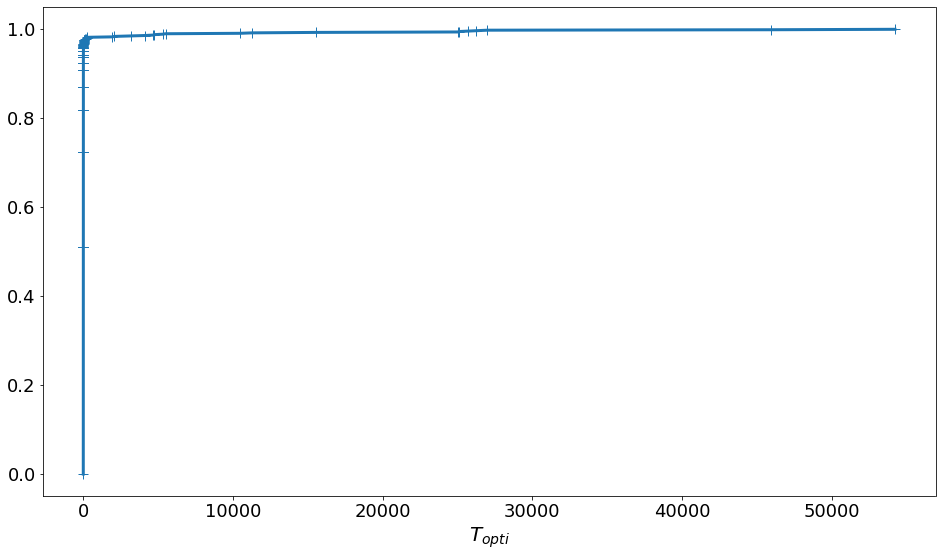

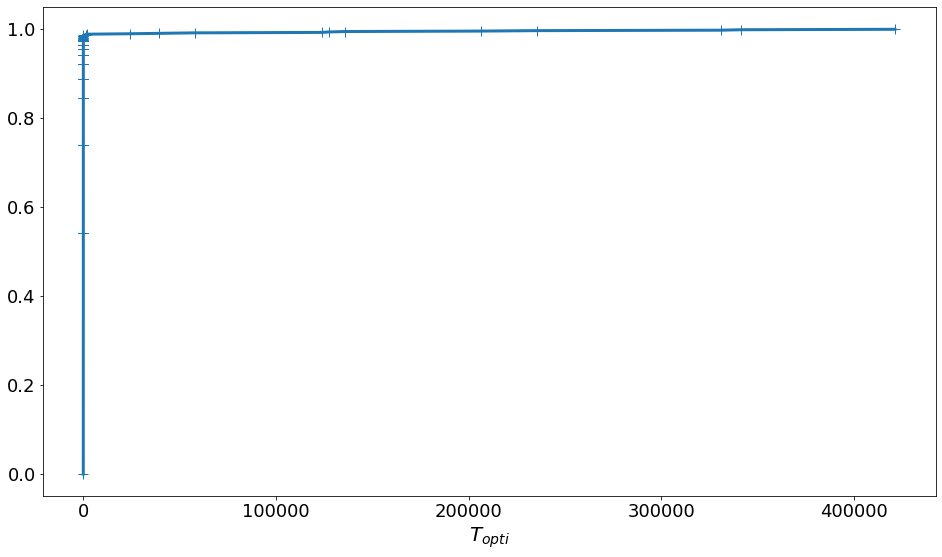

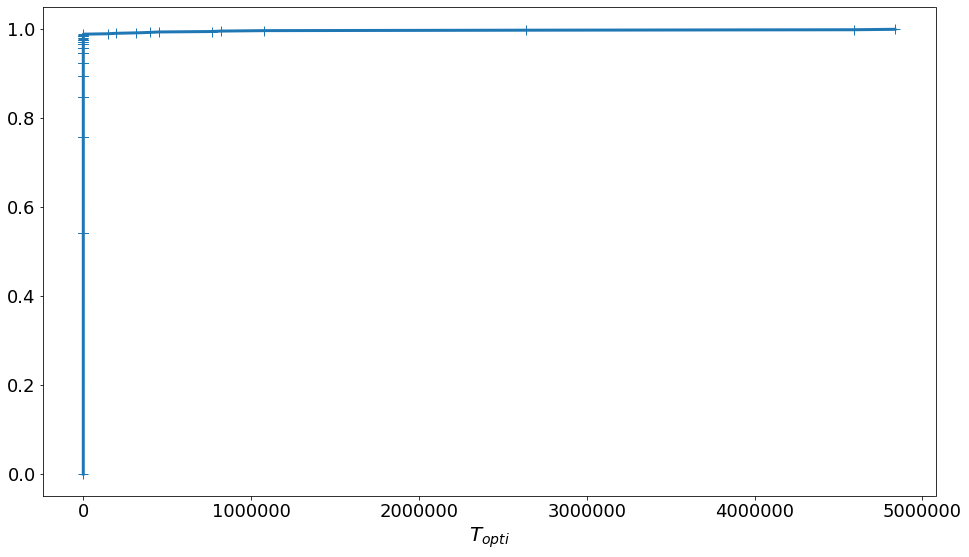

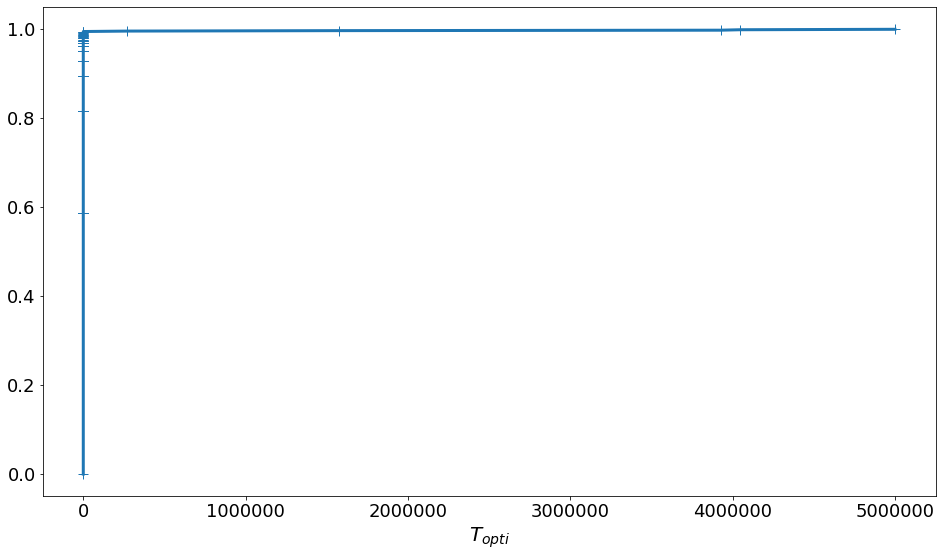

In [260]:
# testing the first time optimal is played

# Params
jump = 2
ms = list(range(2,12,jump))
n_trial = 1000 
a=1
b=0.99
n_init = 3
random_variable = "bernoulli"
post_distrib = "beta"

Param_dict = {}

Param_dict["ms"] = ms
Param_dict["n_trial"] = n_trial
Param_dict["a"] = a
Param_dict["b"] = b
Param_dict["random_variable"] = random_variable
Param_dict["post_distrib"] = post_distrib
Param_dict["n_init"] = n_init
Param_dict["varl"] = 1
Param_dict["vard"] = 0

upper_limit = 5000000

# Save Folder
experimentfolder = "Experience_opti_{}_{}_{}_a{:.5f}b{:.3f}l{}varl{}vardelta{}".format(ms[0],ms[-1],jump,a,b,2*n_init,Param_dict["varl"],Param_dict["vard"])

if not os.path.exists(experimentfolder):
    os.makedirs(experimentfolder)

f = open(experimentfolder + "\\params.pkl","wb")
pickle.dump(Param_dict,f)
f.close()

distrib_first_optimal = [[] for m in ms]


for i,m in enumerate(ms[::-1]):
    print("m = ",m)
    if Param_dict["vard"]:
        b = 1- Param_dict["vard"]/m
    if Param_dict["varl"]:
        n_init = m*Param_dict["varl"]
    for iteration in range(n_trial):
        if iteration%100 == 0:
            print("begin_trial {}".format(iteration))

        env = Two_decision_env(m,a = a,b = b)
        player = CTS_exp(m,n_init = n_init)

        counter = 0
        while player.initialization:
                decision = player.play()
                reward_dict, regret = env.draw(decision)
                player.update(reward_dict)
        
        while player.decision and counter < upper_limit:
                decision = player.play()
                reward_dict, regret = env.draw(decision)
                player.update(reward_dict)
                counter += 1

                if counter%2000 == 0:
                    print("Have still not played the optimal arm at time {}".format(counter))

        distrib_first_optimal[-(i+1)].append(counter)   

np.save(experimentfolder +"\\Distribution",distrib_first_optimal)

#plot Result ECDF



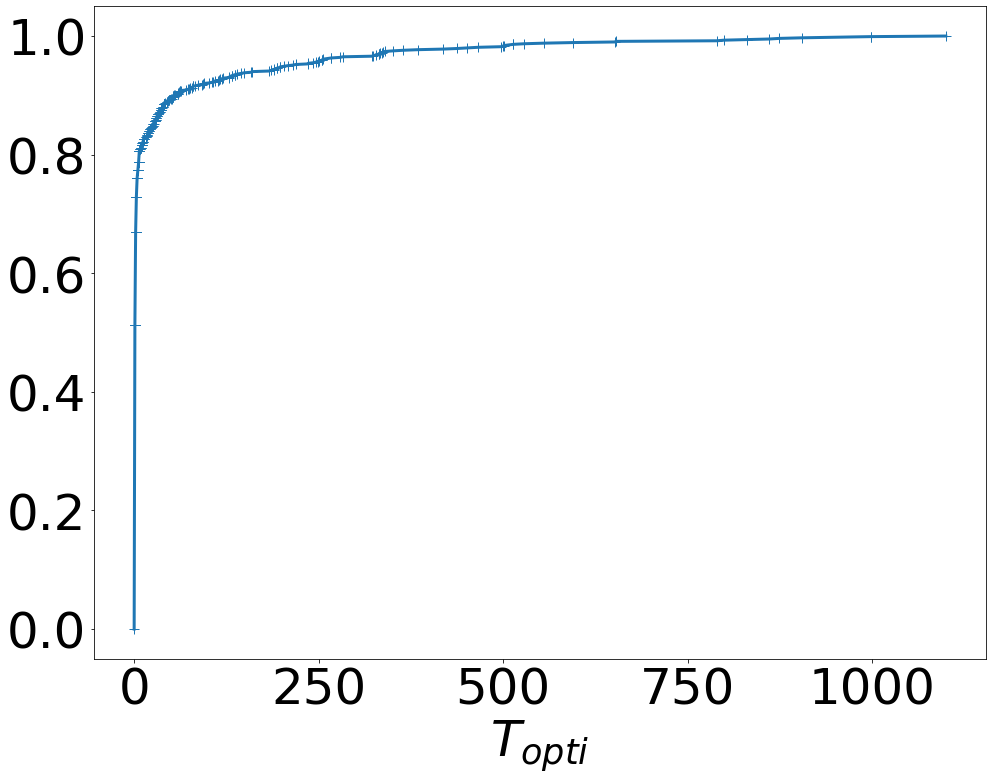

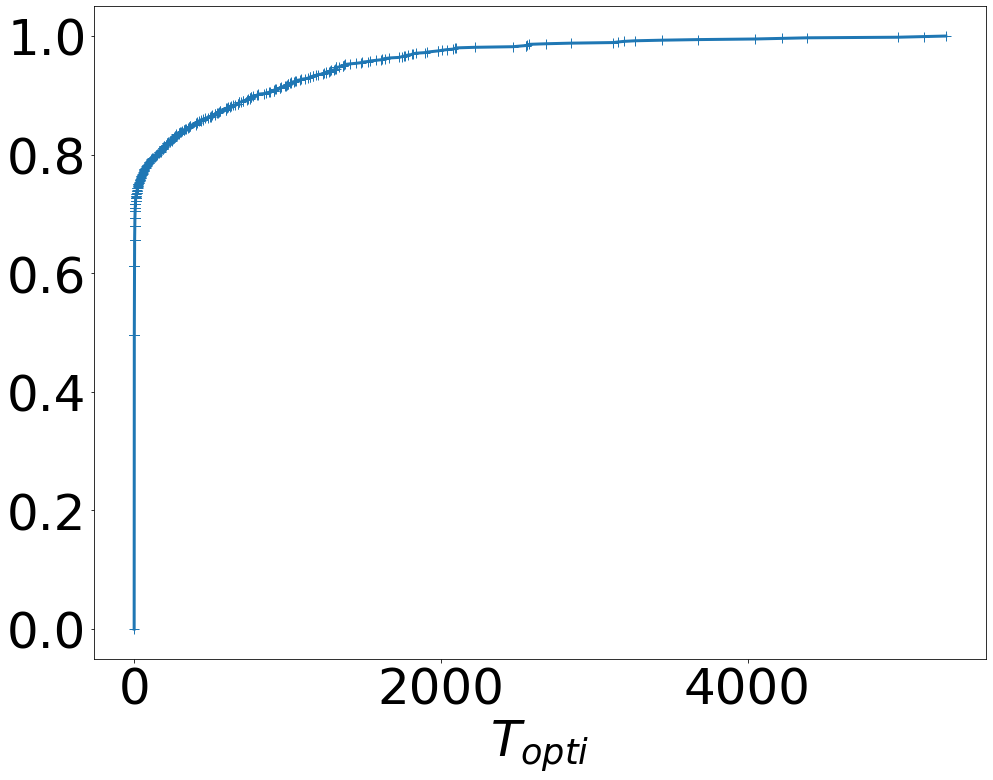

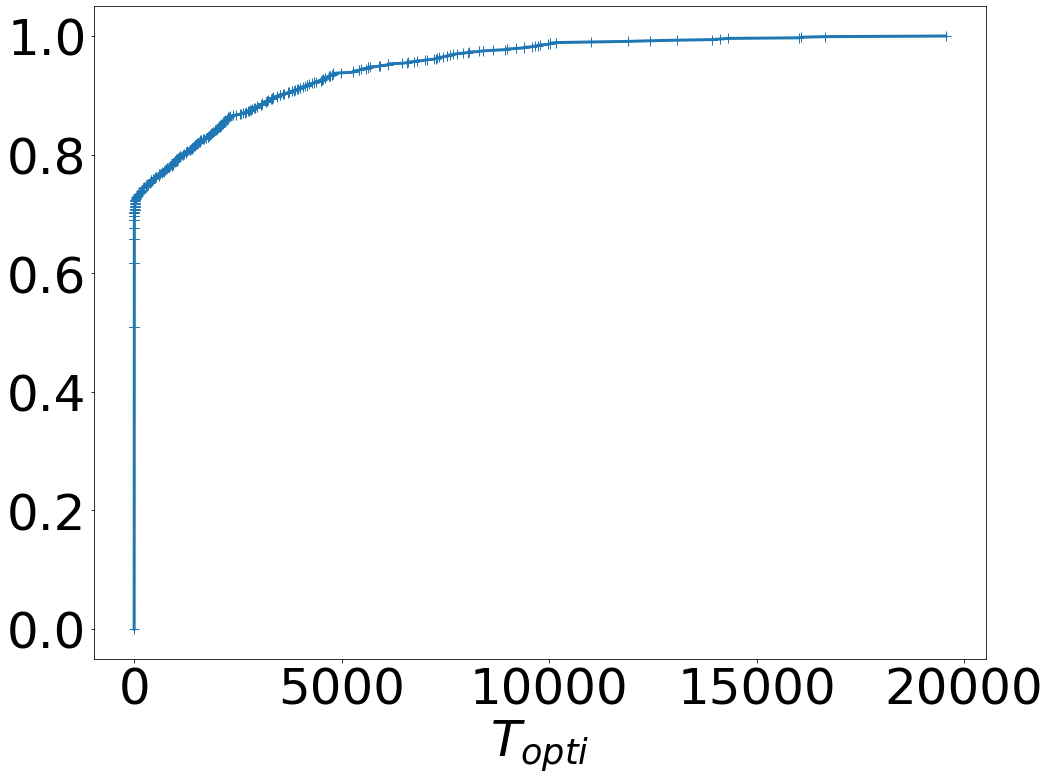

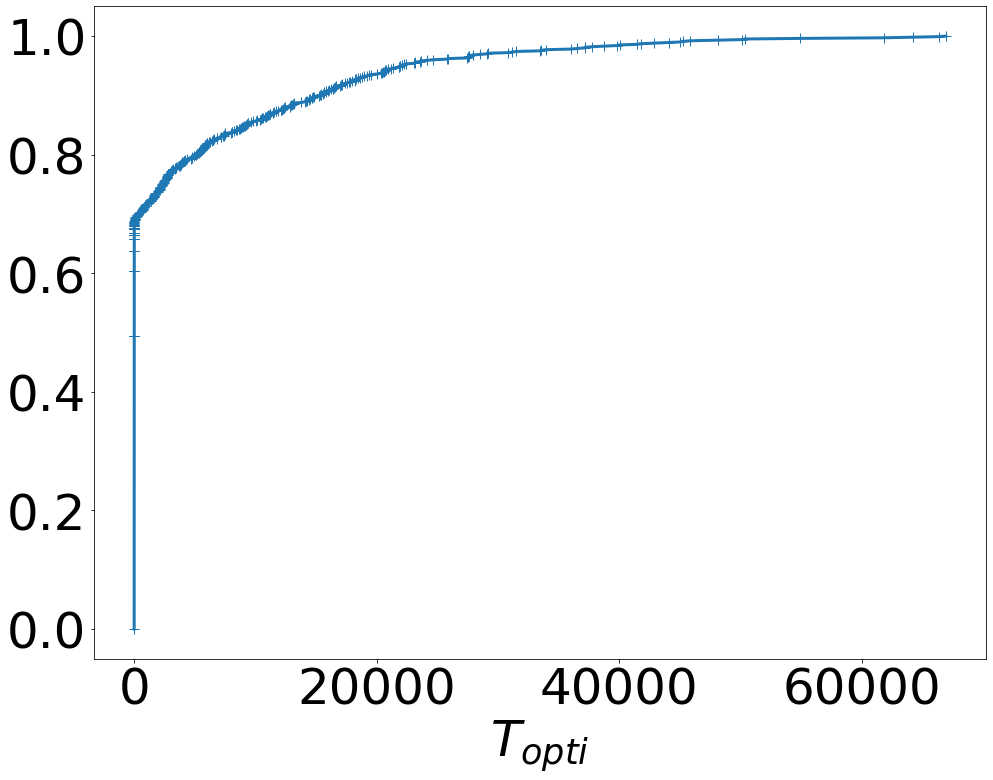

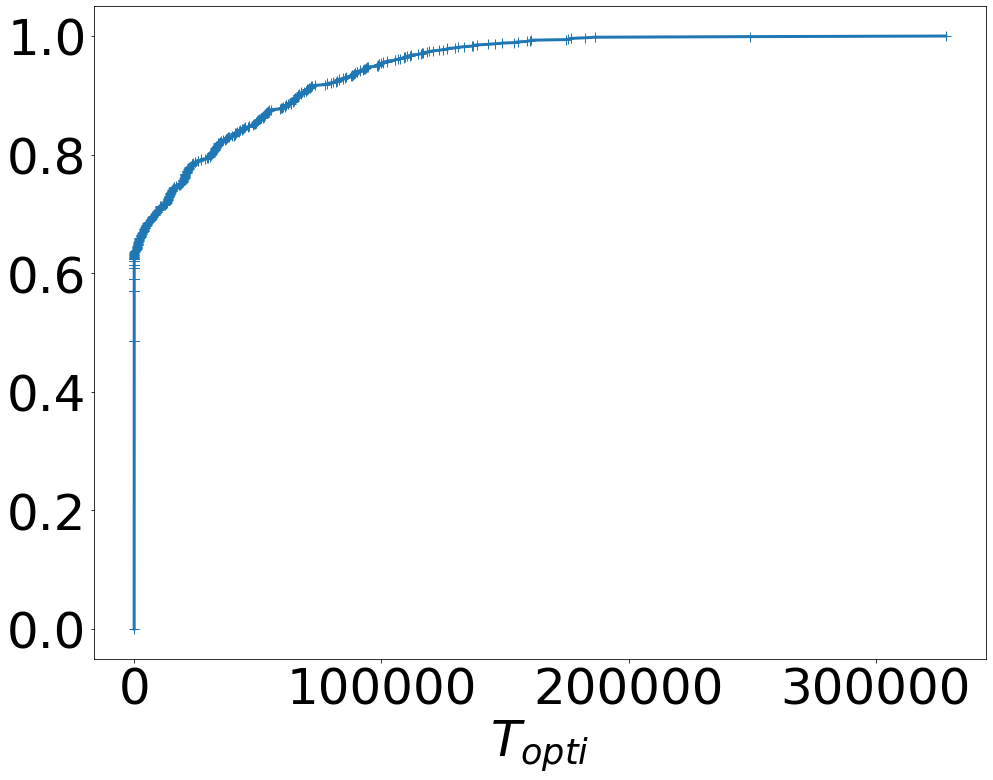

In [303]:
experimentfolder = "Experience_opti_6_14_2_a1.000b0.800"
distrib_first_optimal = np.load(experimentfolder + "\\Distribution.npy")
ms = range(6,15,2)
n_trial = 1000

for i,m in enumerate(ms):
#     if Param_dict["varl"]:
#         n_init = Param_dict["varl"]*m
#     if Param_dict["vard"]:
#         b = 1-Param_dict["vard"]/m
    plt.figure(i,figsize = (16,12))
    plt.clf()
    cdf = ECDF(distrib_first_optimal[i])
    plt.plot([0]+list(np.sort(distrib_first_optimal[i])),[0]+list(cdf(np.sort(distrib_first_optimal[i]))),"+-",linewidth=3,markersize=10)
#plt.title("Distribution of first optimal play  for b = {:.1f} and d = {:d} ".format(b,d),fontsize=20)   
    plt.xlabel(r'$T_{opti}$', fontsize=50)
    plt.tick_params(axis='x', labelsize=50)
    plt.tick_params(axis='y', labelsize=50)
    
    plt.savefig(experimentfolder+'\\ECDF_m{}_l{}.pdf'.format(m,n_init))
    plt.savefig(experimentfolder+'\\ECDF_m{}_l{}'.format(m,n_init))

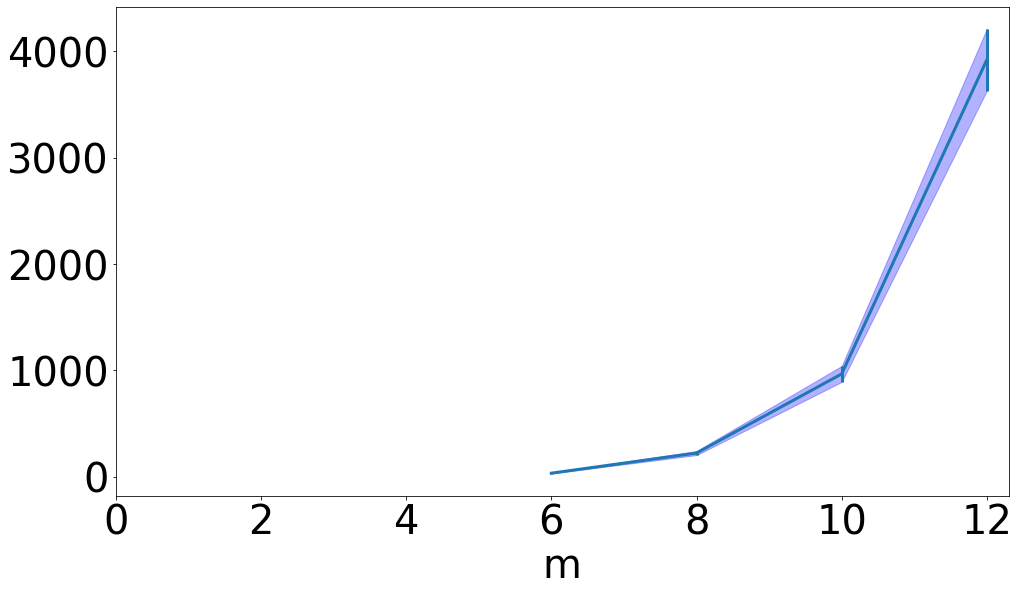

In [302]:
# experimentfolder = "Experience_opti_2_10_2_a1.00000b0.990l6varl1vardelta0"
# distrib_first_optimal = np.load(experimentfolder + "\\Distribution.npy")
# ms = range(2,11,2)
# n_trial = 1000

Average_time = np.mean(distrib_first_optimal, axis =1)
std = np.std(distrib_first_optimal, axis =1)/np.sqrt(n_trial)

plt.figure('Average Time',figsize = (16,9))
plt.clf()
plt.errorbar(ms[:-1], Average_time[:-1], std[:-1], linewidth=3)
plt.fill_between(ms[:-1],Average_time[:-1] - std[:-1], Average_time[:-1] + std[:-1] , color='b', alpha=.3)


plt.xlim(xmin=0)

#plt.title("Average time the optimal decision is played for the first time in function of d",fontsize=20)
# plt.ylabel(r'$T_{opti}$', fontsize=40)
plt.xlabel('m', fontsize=40)
plt.tick_params(axis='x', labelsize=40)
plt.tick_params(axis='y', labelsize=40)

plt.savefig(experimentfolder +"\\Averagel{}.pdf".format(n_init))
plt.savefig(experimentfolder +"\\Averagel{}".format(n_init))

## Exploit those results

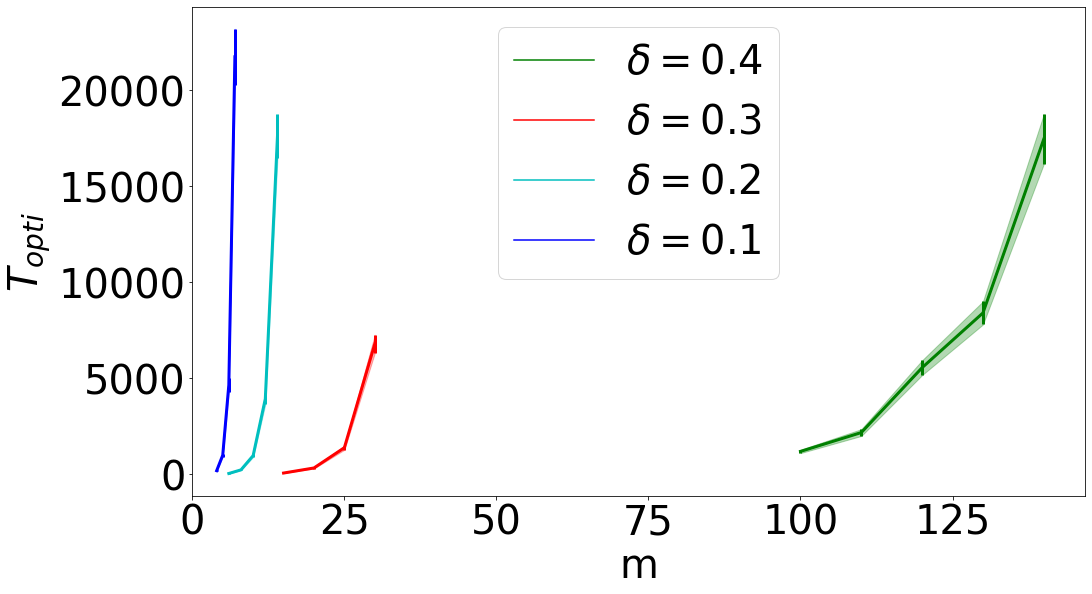

In [277]:
plt.figure('Average Time',figsize = (16,9))
plt.clf()
n_trial = 1000


distrib_first_optimal = np.load("Experience_opti_100_160_10_a1.000b0.600\\Distribution.npy")[:-2]
Average_time = np.mean(distrib_first_optimal, axis =1)
std = np.std(distrib_first_optimal, axis =1)/np.sqrt(n_trial)
ms = range(100,141,10)
plt.errorbar(ms, Average_time, std, linewidth=3, color='g')
plt.fill_between(ms,Average_time - std, Average_time + std , color='g', alpha=.3)
plt.plot(ms, Average_time, color='g', label = r"$\delta = 0.4$")


distrib_first_optimal = np.load("Experience_opti_15_30_5_a1.000b0.700\\Distribution.npy")
Average_time = np.mean(distrib_first_optimal, axis =1)
std = np.std(distrib_first_optimal, axis =1)/np.sqrt(n_trial)
ms = range(15,31,5)
plt.errorbar(ms, Average_time, std, linewidth=3,color='r')
plt.fill_between(ms,Average_time - std, Average_time + std , color='r', alpha=.3)
plt.plot(ms, Average_time,color='r', label = r"$\delta = 0.3$")



distrib_first_optimal = np.load("Experience_opti_6_14_2_a1.000b0.800\\Distribution.npy")
Average_time = np.mean(distrib_first_optimal, axis =1)
std = np.std(distrib_first_optimal, axis =1)/np.sqrt(n_trial)
ms = range(6,15,2)
plt.errorbar(ms, Average_time, std, linewidth=3,color='c')
plt.fill_between(ms,Average_time - std, Average_time + std , color='c', alpha=.3)
plt.plot(ms, Average_time, color = 'c', label = r"$\delta = 0.2$")

distrib_first_optimal = np.load("Experience_opti_4_7_1_a1.000b0.900\\Distribution.npy")
Average_time = np.mean(distrib_first_optimal, axis =1)
std = np.std(distrib_first_optimal, axis =1)/np.sqrt(n_trial)
ms = range(4,8,1)
plt.errorbar(ms, Average_time, std, linewidth=3,color='b')
plt.fill_between(ms,Average_time - std, Average_time + std , color='b', alpha=.3)
plt.plot(ms, Average_time, color = 'b', label = r"$\delta = 0.1$")




plt.xlim(xmin=0)

#plt.title("Average time the optimal decision is played for the first time in function of d",fontsize=20)
plt.ylabel(r'$T_{opti}$', fontsize=40)
plt.xlabel('m', fontsize=40)
plt.tick_params(axis='x', labelsize=40)
plt.tick_params(axis='y', labelsize=40)
plt.legend(fontsize = 40, loc =9)

plt.savefig("First_playing_time_Average_different_delta_2decision.pdf") 
plt.savefig("First_playing_time_Average_different_delta_2decision.") 

# Regret

Simulate some regret trajectories either with Thompson,Thompson warm start or ESCB

In [263]:
# Param


# Params
jump = 2
ms = list(range(1,12,jump))

n_trial = 40
upper_limit = 400000
a=1
b=0.9
n_init = 0
random_variable = "bernoulli"
post_distrib = "beta"

Param_dict = {}

Param_dict["ms"] = ms
Param_dict["n_trial"] = n_trial
Param_dict["a"] = a
Param_dict["b"] = b
Param_dict["random_variable"] = random_variable
Param_dict["post_distrib"] = post_distrib
Param_dict["n_init"] = n_init
Param_dict["upper_limit"] = upper_limit
Param_dict["Vard"] = 1



# Save Folder
experimentfolder = "Experience_regret_{}_{}_{}_a{:.3f}b{:.3f}vardelta{}".format(ms[0],ms[-1],jump,a,b,Param_dict["Vard"])

if not os.path.exists(experimentfolder):
    os.makedirs(experimentfolder)

f = open(experimentfolder + "\\params.pkl","wb")
pickle.dump(Param_dict,f)
f.close()


## TS Coldstart

m =  1
begin_trial 0
play number 5000
play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
play number 125000
play number 130000
play number 135000
play number 140000
play number 145000
play number 150000
play number 155000
play number 160000
play number 165000
play number 170000
play number 175000
play number 180000
play number 185000
play number 190000
play number 195000
play number 200000
play number 5000
play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play n

play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
play number 125000
play number 130000
play number 135000
play number 140000
play number 145000
play number 150000
play number 155000
play number 160000
play number 165000
play number 170000
play number 175000
play number 180000
play number 185000
play number 190000
play number 195000
play number 200000
play number 5000
play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play num

play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
play number 125000
play number 130000
play number 135000
play number 140000
play number 145000
play number 150000
play number 155000
play number 160000
play number 165000
play number 170000
play number 175000
play number 180000
play number 185000
play number 190000
play number 195000
play number 200000
play number 5000
play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play num

play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
play number 125000
play number 130000
play number 135000
play number 140000
play number 145000
play number 150000
play number 155000
play number 160000
play number 165000
play number 170000
play number 175000
play number 180000
play number 185000
play number 190000
play number 195000
play number 200000
play number 5000
play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play 

play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
play number 125000
play number 130000
play number 135000
play number 140000
play number 145000
play number 150000
play number 155000
play number 160000
play number 165000
play number 170000
play number 175000
play number 180000
play number 185000
play number 190000
play number 195000
play number 200000
play number 5000
play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
pla

play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
play number 125000
play number 130000
play number 135000
play number 140000
play number 145000
play number 150000
play number 155000
play number 160000
play number 165000
play number 170000
play number 175000
play number 180000
play number 185000
play number 190000
play number 195000
play number 200000
play number 5000
play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
play number 125000
play number 130000
play number 135000


play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
play number 125000
play number 130000
play number 135000
play number 140000
play number 145000
play number 150000
play number 155000
play number 160000
play number 165000
play number 170000
play number 175000
play number 180000
play number 185000
play number 190000
play number 195000
play number 200000
play number 5000
play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
play number 125000
play number 130000
play number 135000
play number 140000
play number 145000
play number 1500

play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
play number 125000
play number 130000
play number 135000
play number 140000
play number 145000
play number 150000
play number 155000
play number 160000
play number 165000
play number 170000
play number 175000
play number 180000
play number 185000
play number 190000
play number 195000
play number 200000
play number 5000
play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
play number 125000
play number 130000
play number 135000
play number 140000
play number 145000
play number 150000
play number 155000
play number 160000
play number 1

play number 110000
play number 115000
play number 120000
play number 125000
play number 130000
play number 135000
play number 140000
play number 145000
play number 150000
play number 155000
play number 160000
play number 165000
play number 170000
play number 175000
play number 180000
play number 185000
play number 190000
play number 195000
play number 200000
play number 5000
play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
play number 125000
play number 130000
play number 135000
play number 140000
play number 145000
play number 150000
play number 155000
play number 160000
play number 165000
play number 170000
play number 1

play number 125000
play number 130000
play number 135000
play number 140000
play number 145000
play number 150000
play number 155000
play number 160000
play number 165000
play number 170000
play number 175000
play number 180000
play number 185000
play number 190000
play number 195000
play number 200000
play number 5000
play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
play number 125000
play number 130000
play number 135000
play number 140000
play number 145000
play number 150000
play number 155000
play number 160000
play number 165000
play number 170000
play number 175000
play number 180000
play number 185000
play number 1

play number 140000
play number 145000
play number 150000
play number 155000
play number 160000
play number 165000
play number 170000
play number 175000
play number 180000
play number 185000
play number 190000
play number 195000
play number 200000
play number 5000
play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
play number 125000
play number 130000
play number 135000
play number 140000
play number 145000
play number 150000
play number 155000
play number 160000
play number 165000
play number 170000
play number 175000
play number 180000
play number 185000
play number 190000
play number 195000
play number 200000
play number 5

play number 150000
play number 155000
play number 160000
play number 165000
play number 170000
play number 175000
play number 180000
play number 185000
play number 190000
play number 195000
play number 200000
play number 5000
play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
play number 125000
play number 130000
play number 135000
play number 140000
play number 145000
play number 150000
play number 155000
play number 160000
play number 165000
play number 170000
play number 175000
play number 180000
play number 185000
play number 190000
play number 195000
play number 200000
play number 5000
play number 10000
play number 1500

play number 165000
play number 170000
play number 175000
play number 180000
play number 185000
play number 190000
play number 195000
play number 200000
play number 5000
play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
play number 125000
play number 130000
play number 135000
play number 140000
play number 145000
play number 150000
play number 155000
play number 160000
play number 165000
play number 170000
play number 175000
play number 180000
play number 185000
play number 190000
play number 195000
play number 200000
play number 5000
play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
p

play number 180000
play number 185000
play number 190000
play number 195000
play number 200000
play number 5000
play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
play number 125000
play number 130000
play number 135000
play number 140000
play number 145000
play number 150000
play number 155000
play number 160000
play number 165000
play number 170000
play number 175000
play number 180000
play number 185000
play number 190000
play number 195000
play number 200000
play number 5000
play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play

play number 195000
play number 200000
play number 5000
play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
play number 125000
play number 130000
play number 135000
play number 140000
play number 145000
play number 150000
play number 155000
play number 160000
play number 165000
play number 170000
play number 175000
play number 180000
play number 185000
play number 190000
play number 195000
play number 200000
play number 5000
play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play nu

play number 5000
play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
play number 125000
play number 130000
play number 135000
play number 140000
play number 145000
play number 150000
play number 155000
play number 160000
play number 165000
play number 170000
play number 175000
play number 180000
play number 185000
play number 190000
play number 195000
play number 200000
play number 5000
play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play numb

play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
play number 125000
play number 130000
play number 135000
play number 140000
play number 145000
play number 150000
play number 155000
play number 160000
play number 165000
play number 170000
play number 175000
play number 180000
play number 185000
play number 190000
play number 195000
play number 200000
play number 5000
play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play num

play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
play number 125000
play number 130000
play number 135000
play number 140000
play number 145000
play number 150000
play number 155000
play number 160000
play number 165000
play number 170000
play number 175000
play number 180000
play number 185000
play number 190000
play number 195000
play number 200000
play number 5000
play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play nu

play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
play number 125000
play number 130000
play number 135000
play number 140000
play number 145000
play number 150000
play number 155000
play number 160000
play number 165000
play number 170000
play number 175000
play number 180000
play number 185000
play number 190000
play number 195000
play number 200000
m =  11
begin_trial 0
play number 5000
play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
p

play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
play number 125000
play number 130000
play number 135000
play number 140000
play number 145000
play number 150000
play number 155000
play number 160000
play number 165000
play number 170000
play number 175000
play number 180000
play number 185000
play number 190000
play number 195000
play number 200000
play number 5000
play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
play number 125000
pl

play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
play number 125000
play number 130000
play number 135000
play number 140000
play number 145000
play number 150000
play number 155000
play number 160000
play number 165000
play number 170000
play number 175000
play number 180000
play number 185000
play number 190000
play number 195000
play number 200000
play number 5000
play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
play number 125000
play number 130000
play number 135000
play number 140000

play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
play number 125000
play number 130000
play number 135000
play number 140000
play number 145000
play number 150000
play number 155000
play number 160000
play number 165000
play number 170000
play number 175000
play number 180000
play number 185000
play number 190000
play number 195000
play number 200000
play number 5000
play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
play number 125000
play number 130000
play number 135000
play number 140000
play number 145000
play number 150000
play number 155

C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: 

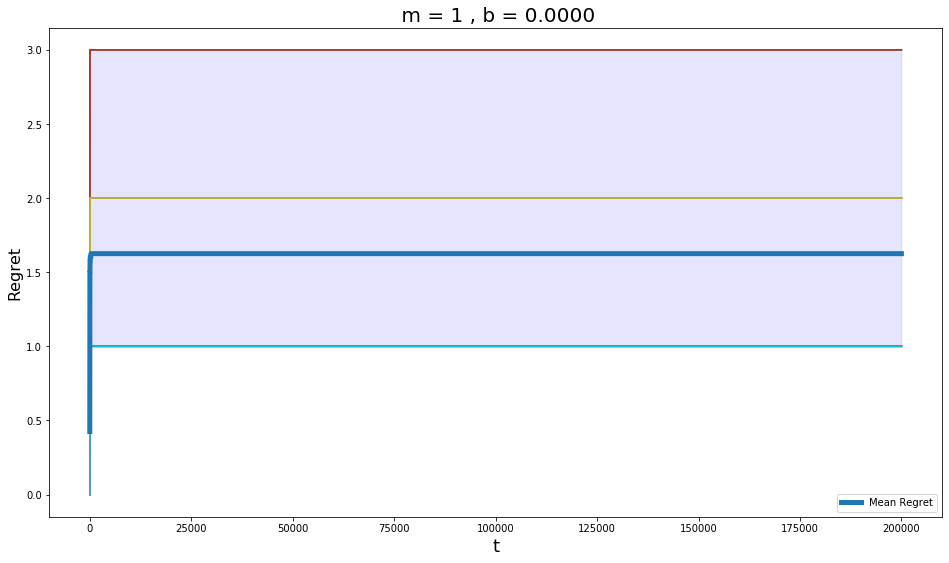

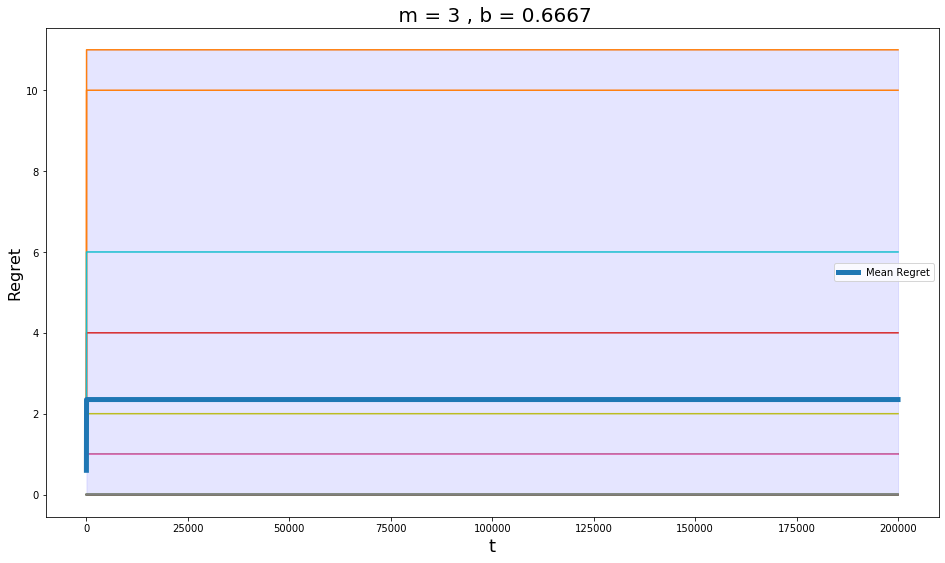

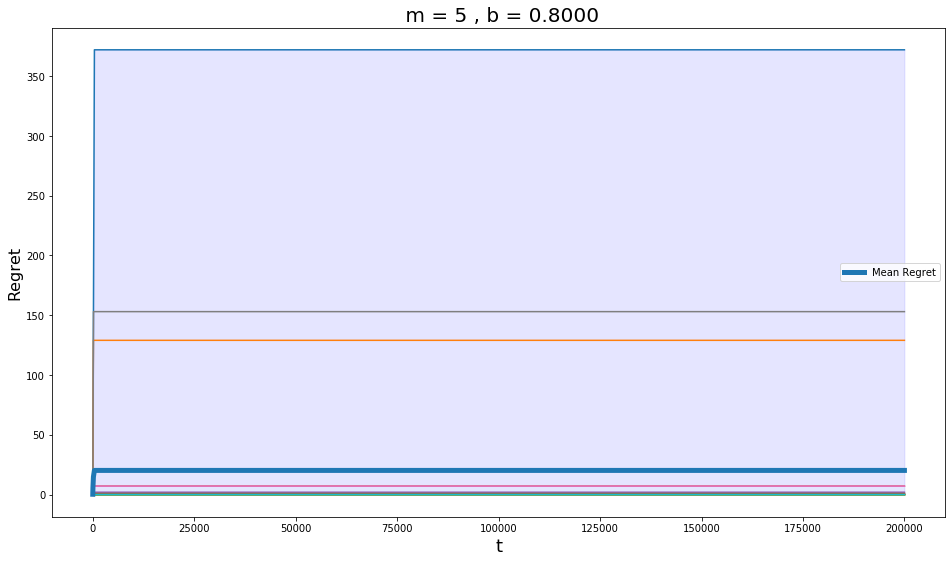

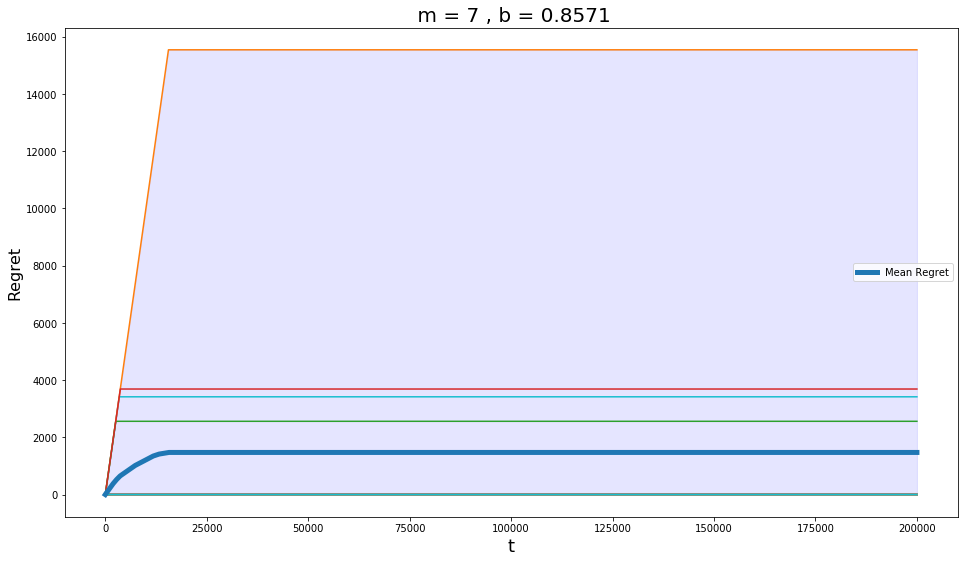

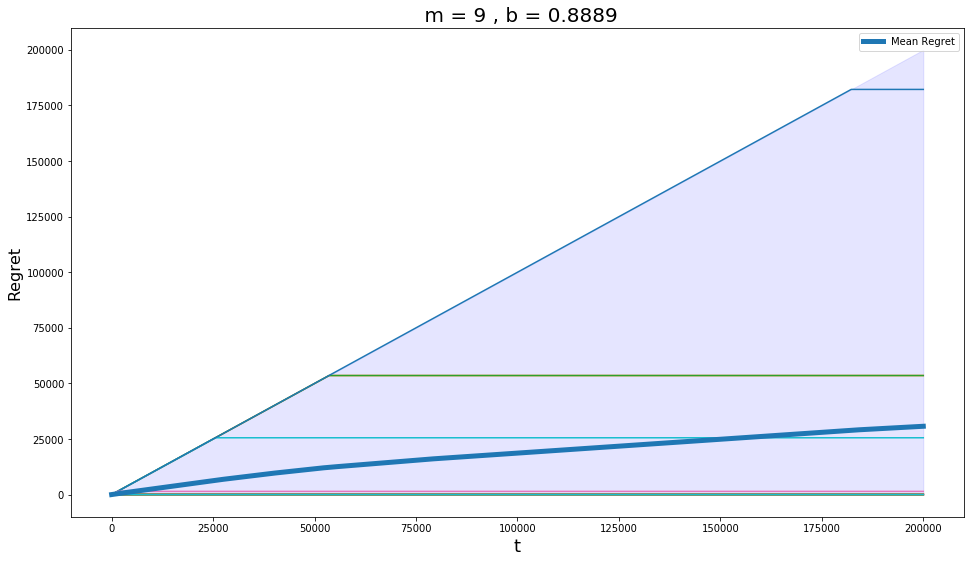

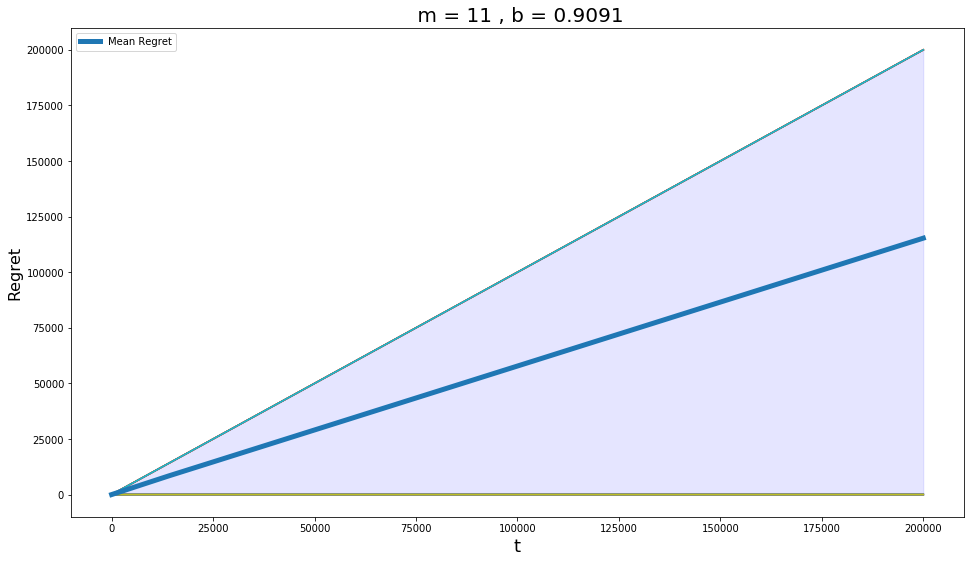

In [162]:

regrets = np.zeros((len(ms),n_trial,upper_limit))

for i,m in enumerate(ms):
    print("m = ",m)
    if Param_dict["Vard"]:
        b = 1- Param_dict["Vard"]/m
    for iteration in range(n_trial):
        if iteration%100 == 0:
            print("begin_trial {}".format(iteration))

        env = Two_decision_env(m,a = a,b = b,sigma = 1, random_variable = random_variable)
        player = CTS_exp(m,n_init = 0, post_distrib = post_distrib)

        counter = 0
    
        
        while counter < upper_limit:
                decision = player.play()
                reward_dict, regret = env.draw(decision)
                player.update(reward_dict)
                counter += 1
                

                if counter%5000 == 0:
                    print("play number {}".format(counter))

        regrets[i,iteration,::] = np.array(player.playhist)*m*(a-b)

np.save(experimentfolder +"\\TSregrets",regrets)
cumulative_regretsTS = np.cumsum(regrets, axis = 2)
        
for i,m in enumerate(ms):
    if Param_dict["Var"]:
        b = 1- 1/m
    plt.figure(i,figsize = (16,9))
    plt.clf()
    plt.title(" m = {} , b = {:.4f}".format(m,b), fontsize=20)
    for k in np.random.randint(0,n_trial,20):
        plt.plot(cumulative_regretsTS[i,k,::])
    plt.plot(np.mean(cumulative_regretsTS[i,::,::],axis = 0), label = "Mean Regret",linewidth=5)
    maxi95 = np.argsort(cumulative_regretsTS[i,::,-1])[int(n_trial*0.975)]
    maxi95 = cumulative_regretsTS[i,maxi95,::]
    
    mini95 = np.argsort(cumulative_regretsTS[i,::,-1])[int(n_trial*0.025)]
    mini95 = cumulative_regretsTS[i,mini95,::]
    
    plt.fill_between(range(upper_limit),mini95,maxi95, color='b', alpha=.1)
    
    plt.xlabel('t', fontsize=18)
    plt.ylabel('Regret', fontsize=16)
    plt.legend()
    plt.savefig(experimentfolder+'\\TS_regret_m{}_l{}.pdf'.format(m,0))
    

## TS Warm Start

In [ ]:
regrets = np.zeros((len(ds),n_trial,upper_limit))

for i,m in enumerate(ms):
    print("m = ",m)
    n_init = 2*m
    
    for iteration in range(n_trial):
        if iteration%100 == 0:
            print("begin_trial {}".format(iteration))

        env = Two_decision_env(m,a = a,b = b,sigma = 1, random_variable = random_variable)
        player = CTS_exp(m,n_init = 0, post_distrib = post_distrib)

        counter = 0
    
        
        while counter < upper_limit:
                decision = player.play()
                reward_dict, regret = env.draw(decision)
                player.update(reward_dict)
                counter += 1
                

                if counter%5000 == 0:
                    print("play number {}".format(counter))

        regrets[i,iteration,::] = np.array(player.playhist)*m*(a-b)

        
for i,m in enumerate(ms):
    plt.figure(i,figsize = (16,9))
    plt.clf()
    plt.title(" m = {} , b = {:.4f}".format(m,b), fontsize=20)
    for k in np.random.randint(0,n_trial,20):
        plt.plot(cumulative_regrets[i,k,::])
    plt.plot(np.mean(cumulative_regrets[i,::,::],axis = 0), label = "Mean Regret",linewidth=5)
    maxi95 = np.argsort(cumulative_regrets[i,::,-1])[int(n_trial*0.975)]
    maxi95 = cumulative_regrets[i,maxi95,::]
    
    mini95 = np.argsort(cumulative_regrets[i,::,-1])[int(n_trial*0.025)]
    mini95 = cumulative_regrets[i,mini95,::]
    
    plt.fill_between(range(upper_limit),mini95,maxi95, color='b', alpha=.1)
    
    plt.xlabel('t', fontsize=18)
    plt.ylabel('Regret', fontsize=16)
    plt.legend()
    plt.savefig(experimentfolder+'\\TS_regret_m{}_l{}.pdf'.format(m,2*m))
    

## ESCB

m =  1
begin_trial 0


C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in sqrt
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in sqrt


play number 5000
play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
play number 125000
play number 130000
play number 135000
play number 140000
play number 145000
play number 150000
play number 155000
play number 160000
play number 165000
play number 170000
play number 175000
play number 180000
play number 185000
play number 190000
play number 195000
play number 200000
play number 5000
play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play numb

play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
play number 125000
play number 130000
play number 135000
play number 140000
play number 145000
play number 150000
play number 155000
play number 160000
play number 165000
play number 170000
play number 175000
play number 180000
play number 185000
play number 190000
play number 195000
play number 200000
m =  7
begin_trial 0
play number 5000
play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play 

play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play number 80000
play number 85000
play number 90000
play number 95000
play number 100000
play number 105000
play number 110000
play number 115000
play number 120000
play number 125000
play number 130000
play number 135000
play number 140000
play number 145000
play number 150000
play number 155000
play number 160000
play number 165000
play number 170000
play number 175000
play number 180000
play number 185000
play number 190000
play number 195000
play number 200000
play number 5000
play number 10000
play number 15000
play number 20000
play number 25000
play number 30000
play number 35000
play number 40000
play number 45000
play number 50000
play number 55000
play number 60000
play number 65000
play number 70000
play number 75000
play num

C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: 

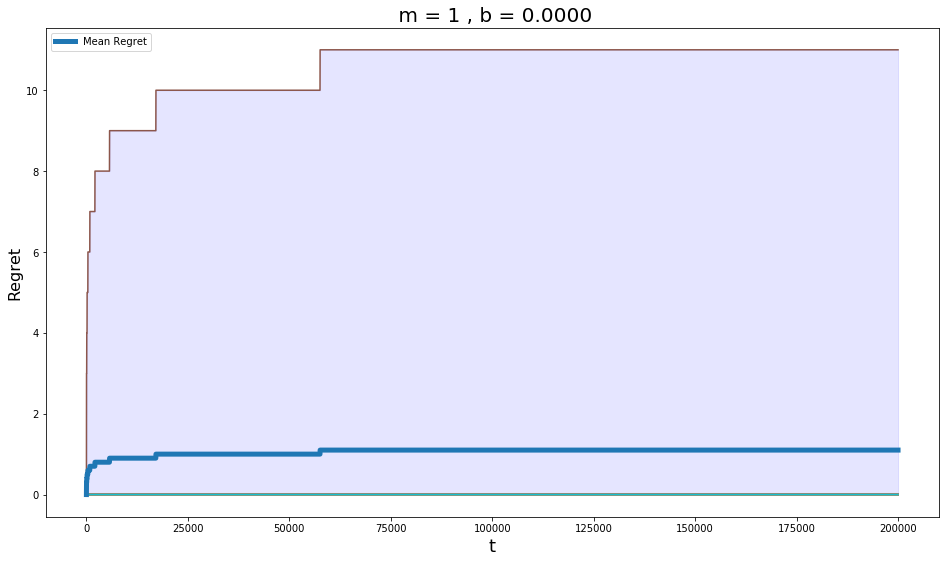

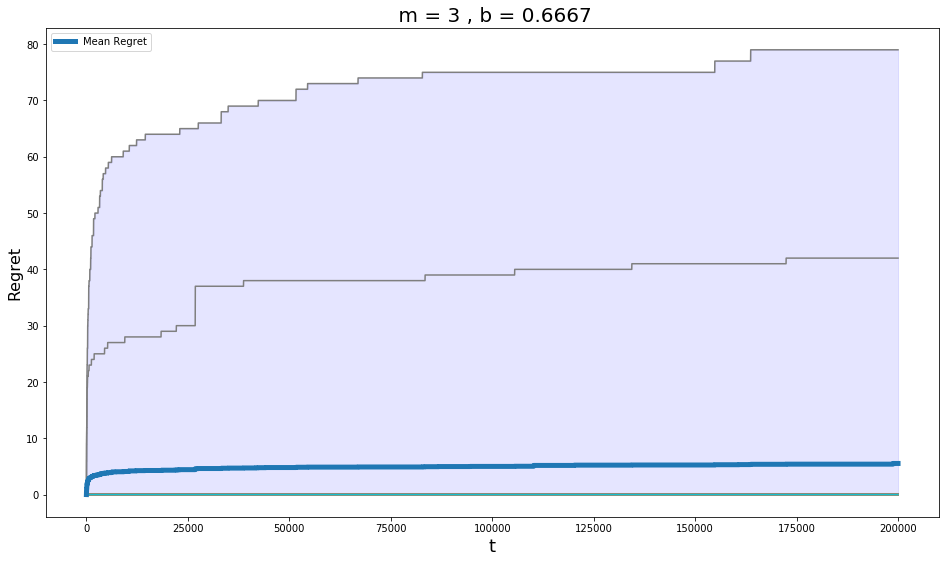

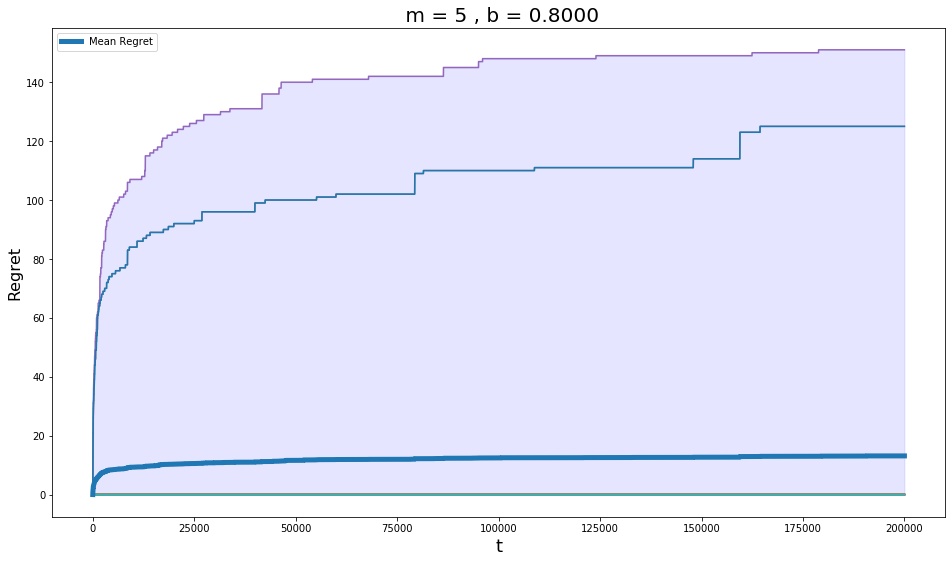

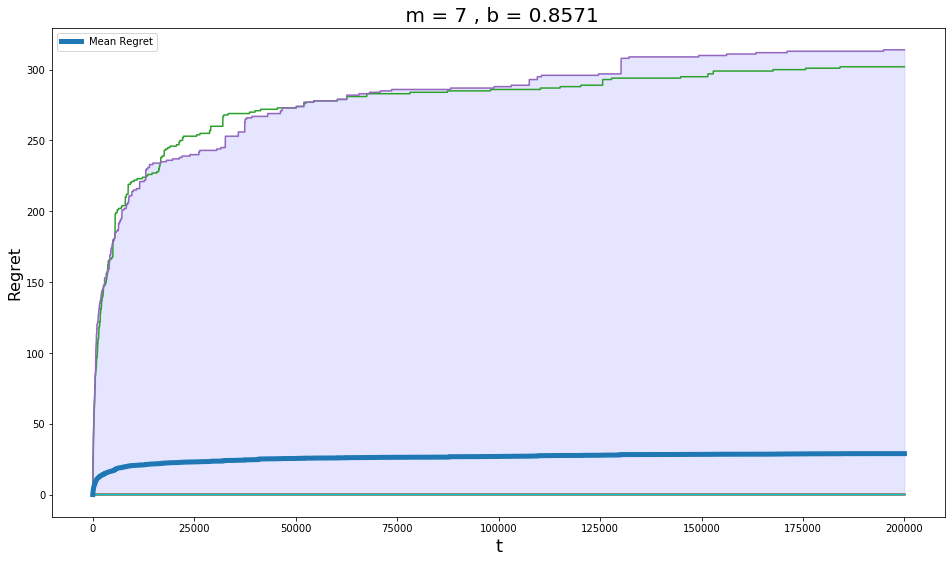

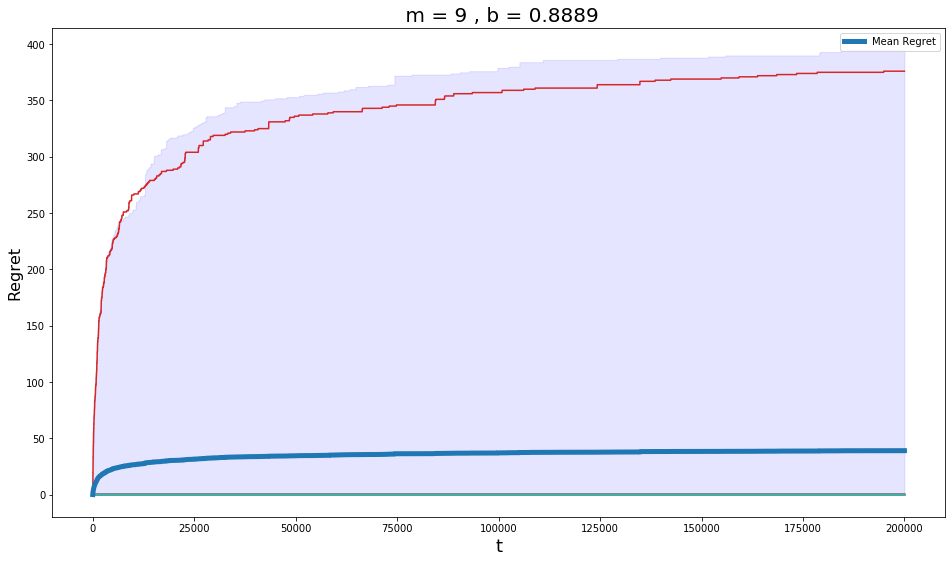

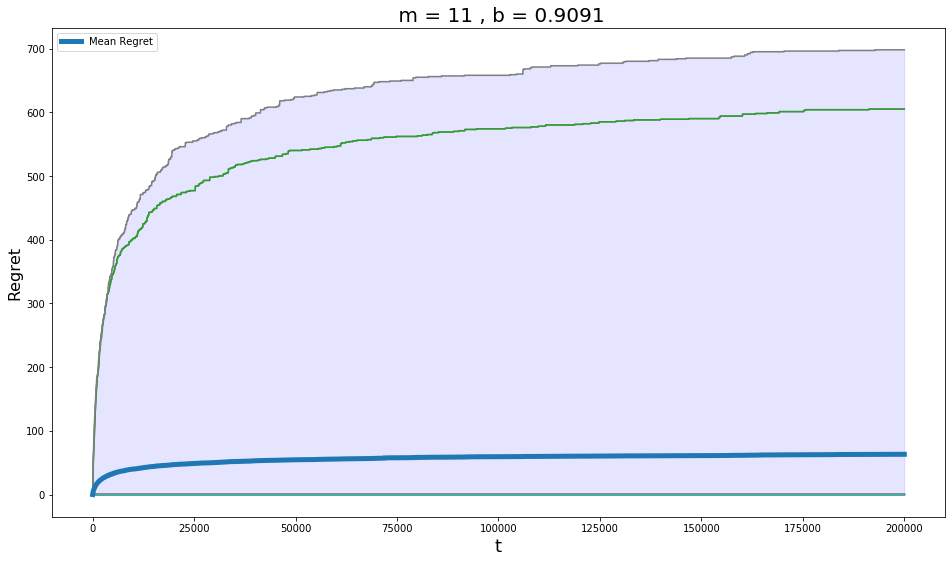

In [163]:

regrets = np.zeros((len(ms),n_trial,upper_limit))



for i,m in enumerate(ms):
    print("m = ",m)
    if Param_dict["Vard"]:
        b = 1- 1/m
    
    for iteration in range(int(n_trial/10)):
        if iteration%100 == 0:
            print("begin_trial {}".format(iteration))

        env = Two_decision_env(m,a = a,b = b,sigma = 1, random_variable = random_variable)
        player = ESCB(m,n_init = 1,index = 2)

        counter = 0
    
        
        while counter < upper_limit:
                decision = player.play()
                reward_dict, regret = env.draw(decision)
                player.update(reward_dict)
                counter += 1
                
                if counter%5000 == 0:
                    print("play number {}".format(counter))

        regrets[i,iteration,::] = np.array(player.playhist)*m*(a-b)

np.save(experimentfolder +"\\ESCBregrets",regrets)
cumulative_regretsESCB = np.cumsum(regrets, axis = 2)

for i,m in enumerate(ms):
    if Param_dict["Vard"]:
        b = 1- 1/m
    plt.figure(i,figsize = (16,9))
    plt.clf()
    plt.title(" m = {} , b = {:.4f}".format(m,b), fontsize=20)
    for k in np.random.randint(0,n_trial,20):
        plt.plot(cumulative_regretsESCB[i,k,::])
    plt.plot(np.mean(cumulative_regretsESCB[i,::,::],axis = 0), label = "Mean Regret",linewidth=5)
    maxi95 = np.argsort(cumulative_regretsESCB[i,::,-1])[int(n_trial*0.975)]
    maxi95 = cumulative_regretsESCB[i,maxi95,::]
    
    mini95 = np.argsort(cumulative_regretsESCB[i,::,-1])[int(n_trial*0.025)]
    mini95 = cumulative_regretsESCB[i,mini95,::]
    
    plt.fill_between(range(upper_limit),mini95,maxi95, color='b', alpha=.1)
    
    plt.xlabel('t', fontsize=18)
    plt.ylabel('Regret', fontsize=16)
    plt.legend()
    plt.savefig(experimentfolder+'\\ESCB_regret_m{}.pdf'.format(m))

### Merge result

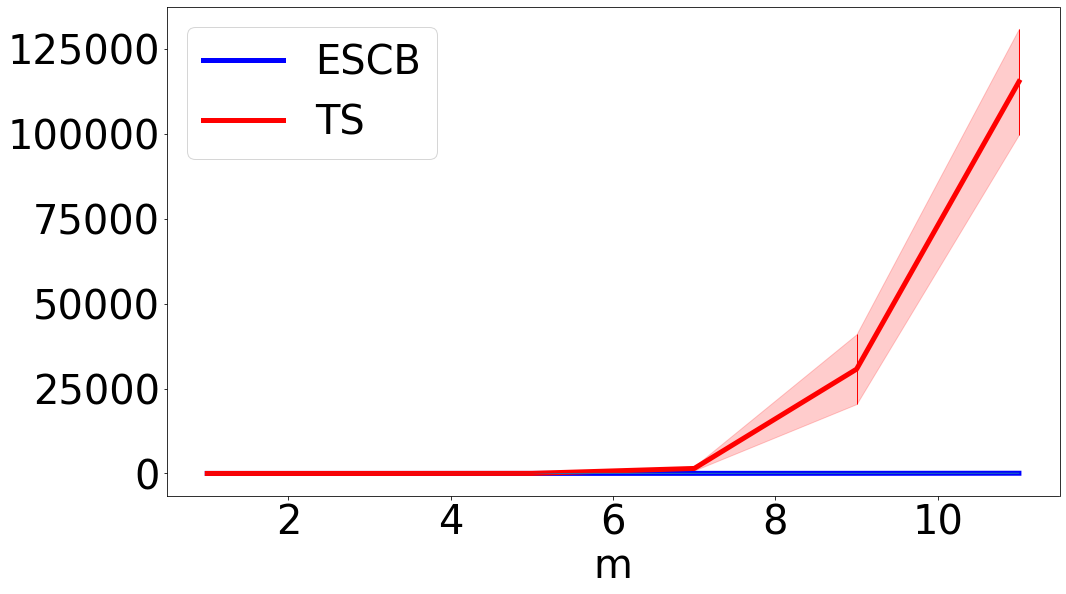

In [291]:
experimentfolder = "Experience_regret_1_11_2_a1.000b0.900var1"
n_trial = 40

regrets = np.load(experimentfolder+"\\ESCBregrets.npy")
cumulative_regretsESCB = np.cumsum(regrets, axis = 2)
RegretESCB = np.mean(cumulative_regretsESCB[::,::,-1],axis = 1)
stdESCB = np.std(cumulative_regretsESCB[::,::,-1], axis =1)/np.sqrt(n_trial/10)

regrets = np.load(experimentfolder+"\\TSregrets.npy")
cumulative_regretsTS = np.cumsum(regrets, axis = 2)
RegretTS = np.mean(cumulative_regretsTS[::,::,-1],axis = 1)
stdTS = np.std(cumulative_regretsTS[::,::,-1], axis =1)/np.sqrt(n_trial)


ms = range(1,12,2)

plt.figure("Final regret",figsize = (16,9))
plt.clf()

plt.errorbar(ms, RegretESCB, stdESCB, linewidth=1)
plt.plot(ms,RegretESCB, label = "ESCB",linewidth=5,color='b')
plt.fill_between(ms,RegretESCB - stdESCB, RegretESCB + stdESCB , color='b', alpha=.2)



plt.errorbar(ms, RegretTS, stdTS, linewidth=1,color='r')
plt.plot(ms,RegretTS, label = "TS",linewidth=5,color='r')
plt.fill_between(ms,RegretTS - stdTS, RegretTS + stdTS , color='r', alpha=.2)


plt.xlabel('m', fontsize=40)
#plt.ylabel('Regret', fontsize=40)
plt.tick_params(axis='x', labelsize=40)
plt.tick_params(axis='y', labelsize=40)
plt.legend(fontsize = 40)
plt.savefig(experimentfolder+'\\final_regret_comparison_m{}_{}.pdf'.format(ms[0],ms[-1]))
plt.savefig(experimentfolder+'\\final_regret_comparison_m{}_{}'.format(ms[0],ms[-1]))